In [2]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [3]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys

if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [4]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [5]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [6]:
last_date = '2022-12-31'
covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World']#.query(f'date < "{last_date}"')

syn_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/syn_clade_stats_SARS_CoV_2/'
assert os.path.exists(syn_clade_stats_SARS_CoV_2_folder)

syn_clade_statistics_SARS_CoV_2_World = pd.read_csv(syn_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
syn_clade_statistics_SARS_CoV_2_World = syn_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [7]:
nonsyn_all_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_all_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_all_clade_stats_SARS_CoV_2_folder)

nonsyn_all_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_all_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_all_clade_statistics_SARS_CoV_2_World = nonsyn_all_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')


In [8]:
nonsyn_S_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/nonsyn_S_clade_stats_SARS_CoV_2/'
assert os.path.exists(nonsyn_S_clade_stats_SARS_CoV_2_folder)
nonsyn_S_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')
nonsyn_S_clade_statistics_SARS_CoV_2_World = nonsyn_S_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [9]:
nonsyn_RBD_clade_stats_SARS_CoV_2_folder = os.getcwd()+'/data/RBD_clade_stats_SARS_CoV_2/'

assert os.path.exists(nonsyn_RBD_clade_stats_SARS_CoV_2_folder)

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = pd.read_csv(nonsyn_RBD_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

nonsyn_RBD_clade_statistics_SARS_CoV_2_World = nonsyn_RBD_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

In [10]:
nonsyn_S_clade_statistics_driver_mutations = pd.read_csv(nonsyn_S_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')
nonsyn_RBD_clade_statistics_driver_mutations = pd.read_csv(nonsyn_RBD_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')

In [11]:
set_S_minus_RBD = set(nonsyn_S_clade_statistics_driver_mutations['Driver_Mutation'] ) - set(nonsyn_RBD_clade_statistics_driver_mutations['Driver_Mutation'] )

index_set_S_minus_RBD = nonsyn_S_clade_statistics_driver_mutations['Driver_Mutation'].isin(set_S_minus_RBD)


In [12]:
nonsyn_S_minus_RBD_clade_stats = nonsyn_S_clade_statistics_driver_mutations[index_set_S_minus_RBD]

In [13]:
nonsyn_S_minus_RBD_clade_stats['Max_Freq'] = nonsyn_S_minus_RBD_clade_stats['Max_Realized_Sublineage_Freq']

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_41238/3387389107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonsyn_S_minus_RBD_clade_stats['Max_Freq'] = nonsyn_S_minus_RBD_clade_stats['Max_Realized_Sublineage_Freq']


In [14]:
# nonsyn_S_clade_statistics_driver_mutations[set_S_minus_RBD]

In [15]:
#create a dataframe with columns, clade, time, max_freq, orig_time
syn_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
syn_clade_stats['Clade'] = syn_clade_statistics_SARS_CoV_2_World['Clade']
syn_clade_stats['Max_Freq'] = syn_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
syn_clade_stats['Orig_Time'] = syn_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
syn_clade_stats = syn_clade_stats.drop_duplicates()

In [16]:
x_thresh_vals = [0,1e-5,1e-4,1e-3,1e-2,1e-1]

for x_th in x_thresh_vals:
    syn_clade_stats[f'Time_x_bgr_{x_th}'] = syn_clade_statistics_SARS_CoV_2_World[syn_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']>x_th].groupby('Clade')['Time'].transform('min')

In [17]:
nonsyn_all_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_all_clade_stats['Clade'] = nonsyn_all_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_all_clade_stats['Max_Freq'] = nonsyn_all_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_all_clade_stats['Orig_Time'] = nonsyn_all_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_all_clade_stats = nonsyn_all_clade_stats.drop_duplicates()

nonsyn_S_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_S_clade_stats['Clade'] = nonsyn_S_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_S_clade_stats['Max_Freq'] = nonsyn_S_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_S_clade_stats['Orig_Time'] = nonsyn_S_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_S_clade_stats = nonsyn_S_clade_stats.drop_duplicates()

nonsyn_RBD_clade_stats = pd.DataFrame(columns = ['Clade','Max_Freq','Orig_Time'])
nonsyn_RBD_clade_stats['Clade'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Clade']
nonsyn_RBD_clade_stats['Max_Freq'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Sublineage_Freq'].transform('max')
nonsyn_RBD_clade_stats['Orig_Time'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World.groupby('Clade')['Time'].transform('min')
nonsyn_RBD_clade_stats = nonsyn_RBD_clade_stats.drop_duplicates()



In [18]:
for x_th in tqdm(x_thresh_vals):
    nonsyn_all_clade_stats[f'Time_x_bgr_{x_th}'] = nonsyn_all_clade_statistics_SARS_CoV_2_World[nonsyn_all_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']>x_th].groupby('Clade')['Time'].transform('min')
    nonsyn_S_clade_stats[f'Time_x_bgr_{x_th}'] = nonsyn_S_clade_statistics_SARS_CoV_2_World[nonsyn_S_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']>x_th].groupby('Clade')['Time'].transform('min')
    nonsyn_RBD_clade_stats[f'Time_x_bgr_{x_th}'] = nonsyn_RBD_clade_statistics_SARS_CoV_2_World[nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']>x_th].groupby('Clade')['Time'].transform('min')

100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


x such that ratio>2 for nonsyn all: 2.31e-01
x such that ratio>2 for nonsyn S: 1.02e-01
x such that ratio>2 for nonsyn RBD: 2.01e-02


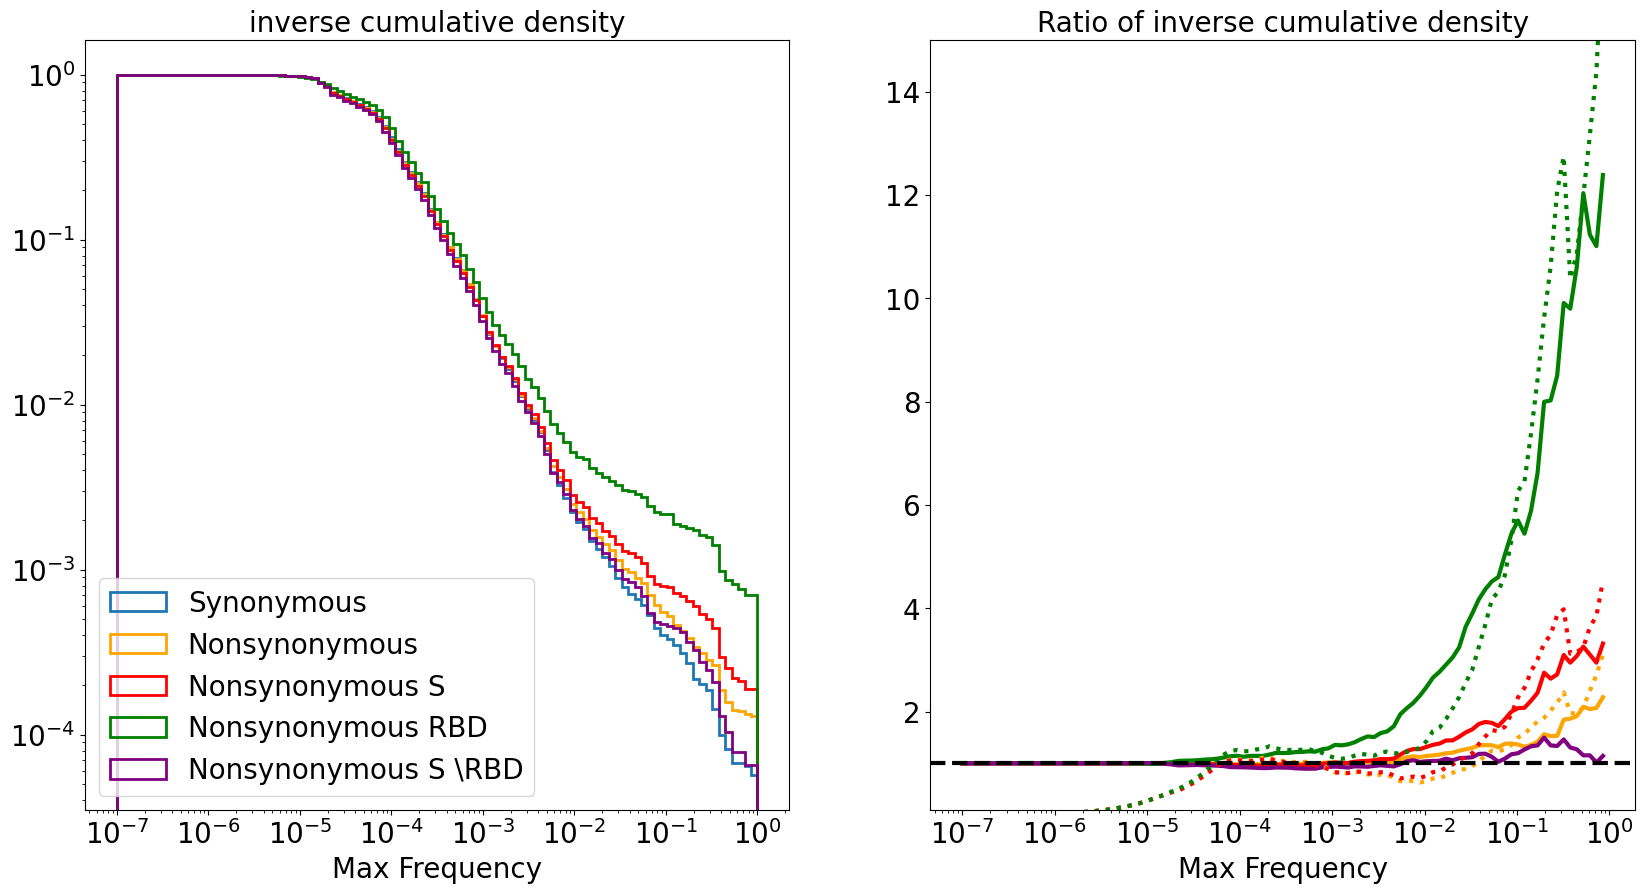

In [40]:
fig, ax = plt.subplots(1,2,figsize = (20,10))

syn_h,syn_b,syn_p = ax[0].hist(syn_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Synonymous',cumulative=-1, histtype = 'step')

nonsyn_all_h,nonsyn_all_b,nonsyn_all_p = ax[0].hist(nonsyn_all_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous',cumulative=-1, histtype = 'step',color='orange')

nonsyn_S_h,nonsyn_S_b,nonsyn_S_p = ax[0].hist(nonsyn_S_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous S',cumulative=-1, histtype = 'step',color='red')

nonsyn_RBD_h,nonsyn_RBD_b,nonsyn_RBD_p = ax[0].hist(nonsyn_RBD_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous RBD',cumulative=-1, histtype = 'step',color='green')

nonsyn_S_minus_RBD_h, nonsyn_S_minus_RBD_b, nonsyn_S_minus_RBD_p = ax[0].hist(nonsyn_S_minus_RBD_clade_stats['Max_Freq'], bins = np.logspace(-7,0,100), density = True, alpha = 1, lw=2, label = 'Nonsynonymous S \RBD',cumulative=-1, histtype = 'step',color='purple')

#fit syn with b/(1+a x)
fitfunc = lambda x,a,b: b/(1+a*x)
popt, pcov = so.curve_fit(fitfunc, syn_b[50:-1],syn_h[50:])
a,b = popt
one_over_x_fit = fitfunc(syn_b[:-1],a,b)
# ax[0].plot(syn_b[:-1],one_over_x_fit, label = r'$1/x$',color='steelblue',linestyle='--')
ax[0].legend(loc='best',fontsize=20)
ax[1].plot(syn_b[:-1],nonsyn_all_h/syn_h, label = 'Synonymous',color='orange')
ax[1].plot(syn_b[:-1],nonsyn_S_h/syn_h, label = 'Nonsynonymous S',color='red')
ax[1].plot(syn_b[:-1],nonsyn_RBD_h/syn_h, label = 'Nonsynonymous RBD',color='green')
ax[1].plot(syn_b[:-1],nonsyn_S_minus_RBD_h/syn_h, label = 'Nonsynonymous S \RBD',color='purple')

ax[1].plot(syn_b[:-1],nonsyn_all_h/one_over_x_fit,color='orange',ls= ':')
ax[1].plot(syn_b[:-1],nonsyn_S_h/one_over_x_fit,color='red',ls= ':')
ax[1].plot(syn_b[:-1],nonsyn_RBD_h/one_over_x_fit,color='green',ls= ':')

print(f'x such that ratio>2 for nonsyn all: {syn_b[np.argwhere(nonsyn_all_h/one_over_x_fit>2)[0][0]]:.2e}')
print(f'x such that ratio>2 for nonsyn S: {syn_b[np.argwhere(nonsyn_S_h/one_over_x_fit>2)[0][0]]:.2e}')
print(f'x such that ratio>2 for nonsyn RBD: {syn_b[np.argwhere(nonsyn_RBD_h/one_over_x_fit>2)[0][0]]:.2e}')

ax[1].set_ylim(.1,15)

ax[1].axhline(1,linestyle='--',color='black')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
# ax[0].set_ylim(10,50)

ax[1].set_xscale('log')

ax[0].set_xlabel('Max Frequency',fontsize=20)
ax[0].set_title('inverse cumulative density',fontsize=20)

ax[1].set_xlabel('Max Frequency',fontsize=20)
ax[1].set_title('Ratio of inverse cumulative density',fontsize=20)
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=20)


In [20]:
34*.4        

13.600000000000001

In [21]:
reference_date = pd.to_datetime('2020-01-01')

syn_clade_stats['day_diff'] = (pd.to_datetime(syn_clade_stats['Orig_Time']) - reference_date).dt.days
nonsyn_all_clade_stats['day_diff'] = (pd.to_datetime(nonsyn_all_clade_stats['Orig_Time']) - reference_date).dt.days
nonsyn_S_clade_stats['day_diff'] = (pd.to_datetime(nonsyn_S_clade_stats['Orig_Time']) - reference_date).dt.days
nonsyn_RBD_clade_stats['day_diff'] = (pd.to_datetime(nonsyn_RBD_clade_stats['Orig_Time']) - reference_date).dt.days

In [22]:
for x_th in tqdm(x_thresh_vals):
    syn_clade_stats[f'day_diff_x_bgr_{x_th}'] = (pd.to_datetime(syn_clade_stats[f'Time_x_bgr_{x_th}']) - reference_date).dt.days
    nonsyn_all_clade_stats[f'day_diff_x_bgr_{x_th}'] = (pd.to_datetime(nonsyn_all_clade_stats[f'Time_x_bgr_{x_th}']) - reference_date).dt.days
    nonsyn_S_clade_stats[f'day_diff_x_bgr_{x_th}'] = (pd.to_datetime(nonsyn_S_clade_stats[f'Time_x_bgr_{x_th}']) - reference_date).dt.days
    nonsyn_RBD_clade_stats[f'day_diff_x_bgr_{x_th}'] = (pd.to_datetime(nonsyn_RBD_clade_stats[f'Time_x_bgr_{x_th}']) - reference_date).dt.days
    

100%|██████████| 6/6 [00:00<00:00, 38.24it/s]


In [23]:
World_cases = 7*covid_data_World['new_cases_smoothed']
World_cases = World_cases[World_cases>0]
World_cases = World_cases[~np.isinf(World_cases)]
World_cases = World_cases[~np.isnan(World_cases)]


covid_data_World['Time_datetime'] = pd.to_datetime(covid_data_World['date'])
covid_data_World['day_diff'] = covid_data_World['Time_datetime']-reference_date

covid_data_World['day_diff'] = covid_data_World['day_diff'].apply(lambda x: x.days)
covid_data_World['weekly_new_cases_smoothed'] = covid_data_World['new_cases_smoothed']*7

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_41238/2451318858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_World['Time_datetime'] = pd.to_datetime(covid_data_World['date'])
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_41238/2451318858.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_World['day_diff'] = covid_data_World['Time_datetime']-reference_date
/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_41238/2451318858.py:10: SettingWithCopyW

In [24]:
wt_alpha_crossover_date = pd.to_datetime('2021-03-15')
alpha_delta_crossover_date = pd.to_datetime('2021-06-21')
delta_ba1_crossover_date = pd.to_datetime('2022-01-03')
ba1_ba2_crossover_date = pd.to_datetime('2022-01-31')
ba2_ba5_crossover_date = pd.to_datetime('2022-06-06')
ba5_xbb_crossover_date = pd.to_datetime('2023-02-27')

wt_alpha_crossover_label = 'WT to Alpha'
alpha_delta_crossover_label = 'Alpha to Delta'
delta_ba1_crossover_label = 'Delta to BA.1'
ba1_ba2_crossover_label = 'BA.1 to BA.2'
ba2_ba5_crossover_label = 'BA.2 to BA.5'
ba5_xbb_crossover_label = 'BA.5 to xBB'

crossover_dates = [alpha_delta_crossover_date,delta_ba1_crossover_date,ba2_ba5_crossover_date]
crossover_labels = [alpha_delta_crossover_label,delta_ba1_crossover_label,ba2_ba5_crossover_label]

In [25]:
day_diff_weekly = covid_data_World['day_diff'][::7]

In [26]:
day_diff_weekly

384403       4
384410      11
384417      18
384424      25
384431      32
          ... 
385929    1530
385936    1537
385943    1544
385950    1551
385957    1558
Name: day_diff, Length: 223, dtype: int64

In [27]:
# b16172_selection = fitness_france['B.1.617.2_fitness_vac'] + fitness_france['B.1.617.2_fitness_vac']

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
World_cases = 7*covid_data_World['new_cases_smoothed']
World_cases = World_cases[World_cases>0]
World_cases = World_cases[~np.isinf(World_cases)]
World_cases = World_cases[~np.isnan(World_cases)]

covid_data_World['Time_datetime'] = pd.to_datetime(covid_data_World['date'])
covid_data_World['day_diff'] = covid_data_World['Time_datetime']-reference_date

covid_data_World['day_diff'] = covid_data_World['day_diff'].apply(lambda x: x.days)
covid_data_World['weekly_new_cases_smoothed'] = covid_data_World['new_cases_smoothed']*7

I_over_time = covid_data_World['weekly_new_cases_smoothed'].values

In [30]:
#import savgol_filter
from scipy.signal import savgol_filter
#import gaussian smoothing
from scipy.ndimage import gaussian_filter1d

# avg_max_x_by_s_smooth = gaussian_filter1d(avg_max_x_by_s, sigma=2)

In [31]:
# s_w_vals = s_w_vals[~np.isnan(avg_max_x_by_s_smooth)]
# avg_max_x_by_s_smooth = avg_max_x_by_s_smooth[~np.isnan(avg_max_x_by_s_smooth)]


In [32]:
# df_pot_selection  = pd.read_csv('data/df_pot_selection.txt',sep = '\t')
fitness_france = pd.read_csv('data/fitness_France_newest.txt',sep = '\t')
# fitness_france_new = pd.read_csv('data/fitness_France_new.txt',sep = '\t')

In [33]:
fitness_france['day_diff'] = (pd.to_datetime(fitness_france['date']) - reference_date).dt.days
fitness_france['s_w'] = fitness_france['av_pot_selection']*7

# fitness_france_new['day_diff'] = (pd.to_datetime(fitness_france_new['date']) - reference_date).dt.days
# fitness_france_new['s_w'] = fitness_france_new['av_pot_selection']*7

In [34]:
cases = 7*covid_data_World['new_cases_smoothed'].values
len(cases)

1559

In [35]:

# avg_pot_selection_old = fitness_france['av_pot_selection'].values[5:]
avg_pot_selection = fitness_france['av_pot_selection'].values[5:]
len(avg_pot_selection)

day_diff = fitness_france['day_diff'][5:].values
# print(len(day_diff),len(avg_pot_selection))

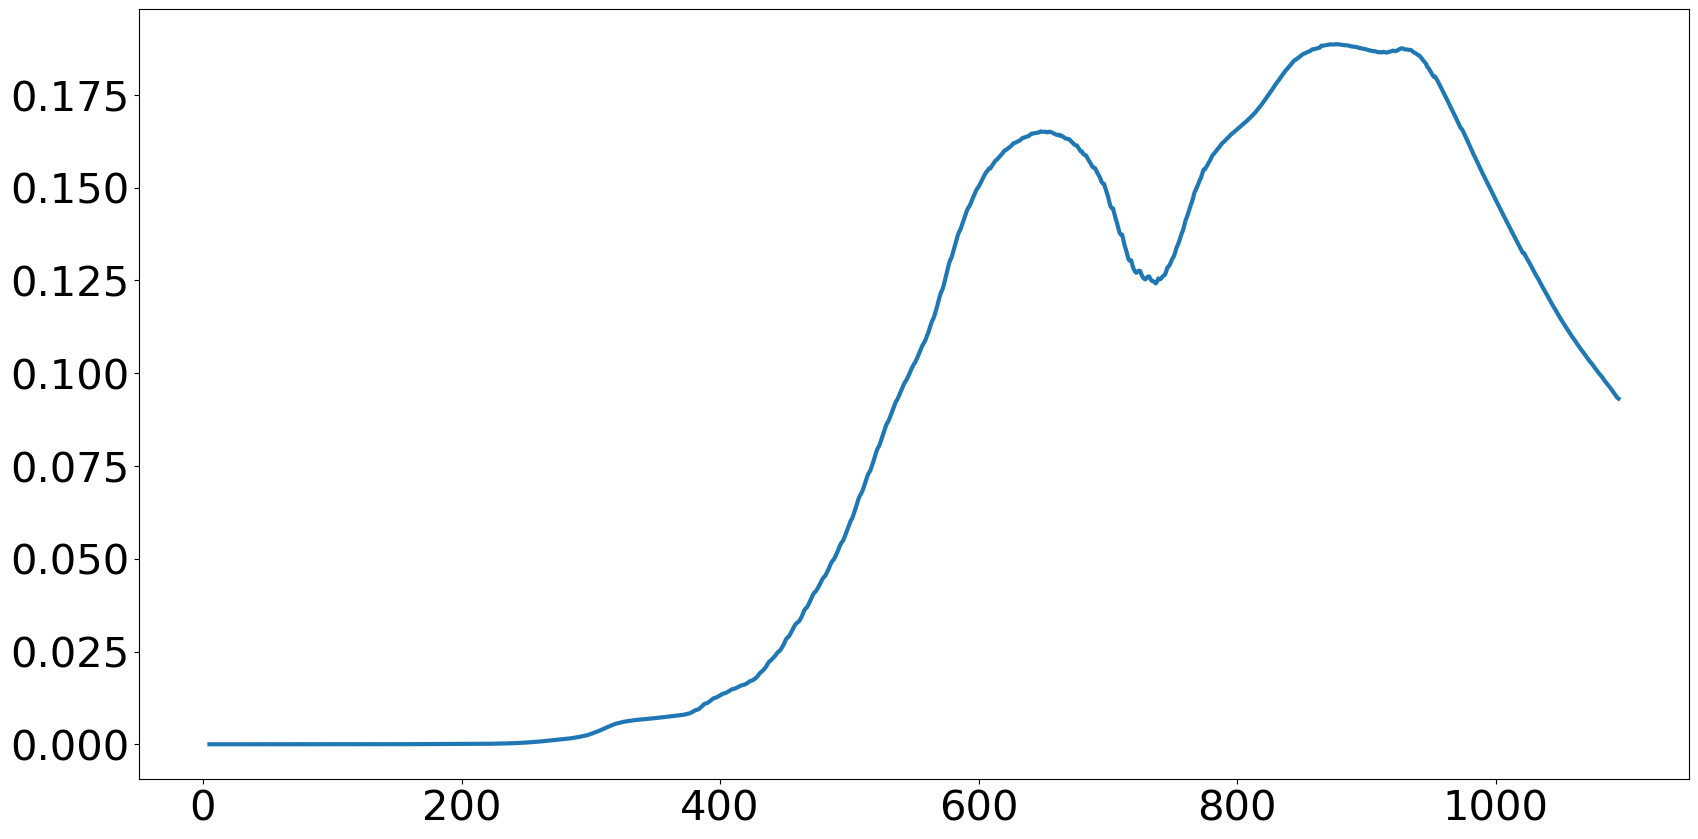

In [36]:
fig,ax = plt.subplots()

ax.plot(day_diff,avg_pot_selection)
# ax.plot(day_diff,avg_pot_selection_old)
# ax.plot(day_diff,cases)

In [37]:
h_syn_dict = {}
b_syn_dict = {}

h_nonsyn_RBD_dict, b_nonsyn_RBD_dict = {},{}
for x_thresh in x_thresh_vals:
    h_syn, b_syn = np.histogram(syn_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, density= False)
    h_nonsyn_RBD, b_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, density= False)

    h_syn_dict[x_thresh] = h_syn
    b_syn_dict[x_thresh] = b_syn

    h_nonsyn_RBD_dict[x_thresh] = h_nonsyn_RBD    
    b_nonsyn_RBD_dict[x_thresh] = b_nonsyn_RBD




In [38]:
smoothed_hx_nonsyn_RBD,smoothed_href_nonsyn_RBD;
fig,ax = plt.subplots(1,2,figsize = (20,10))
sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax[0],element='step', fill=False, stat='density', lw=1)
sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, label = 'RBD',alpha=0.5, color='green',ax=ax[0],element='step', fill=False, stat='density', lw=1)

sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax[1],element='step', fill=False, stat='density', lw=1)
sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, label = 'RBD',alpha=0.5, color='green',ax=ax[1],element='step', fill=False, stat='density', lw=1)

ax[0].plot(day_diff_weekly[:-1],smoothed_href_nonsyn_RBD/np.trapz(smoothed_href_nonsyn_RBD,day_diff_weekly[:-1]),label = 'RBD',color='green',lw=2)
ax[0].plot(day_diff_weekly[:-1],smoothed_href_syn/np.trapz(smoothed_href_syn,day_diff_weekly[:-1]),label = 'Synonymous',color='steelblue',lw=2)


NameError: name 'smoothed_hx_nonsyn_RBD' is not defined

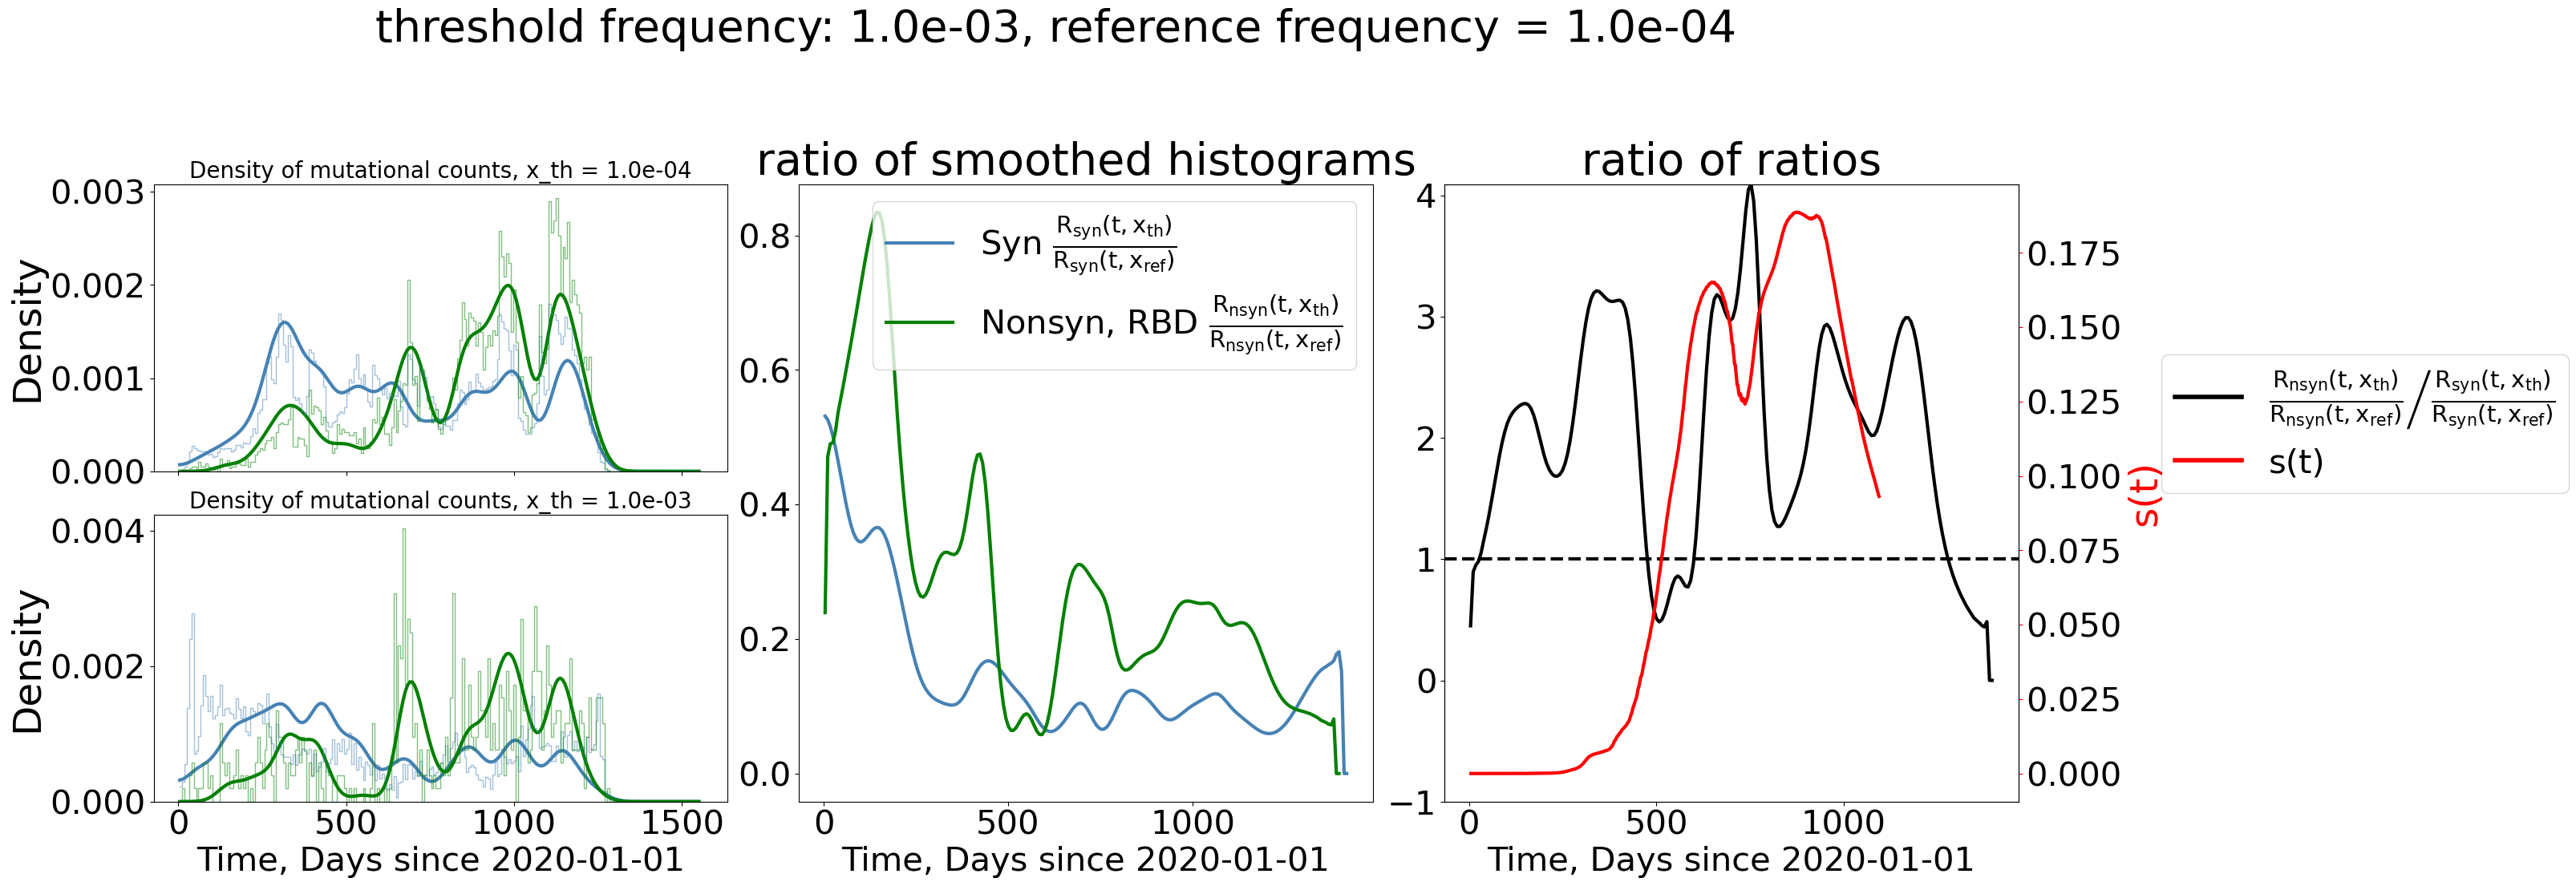

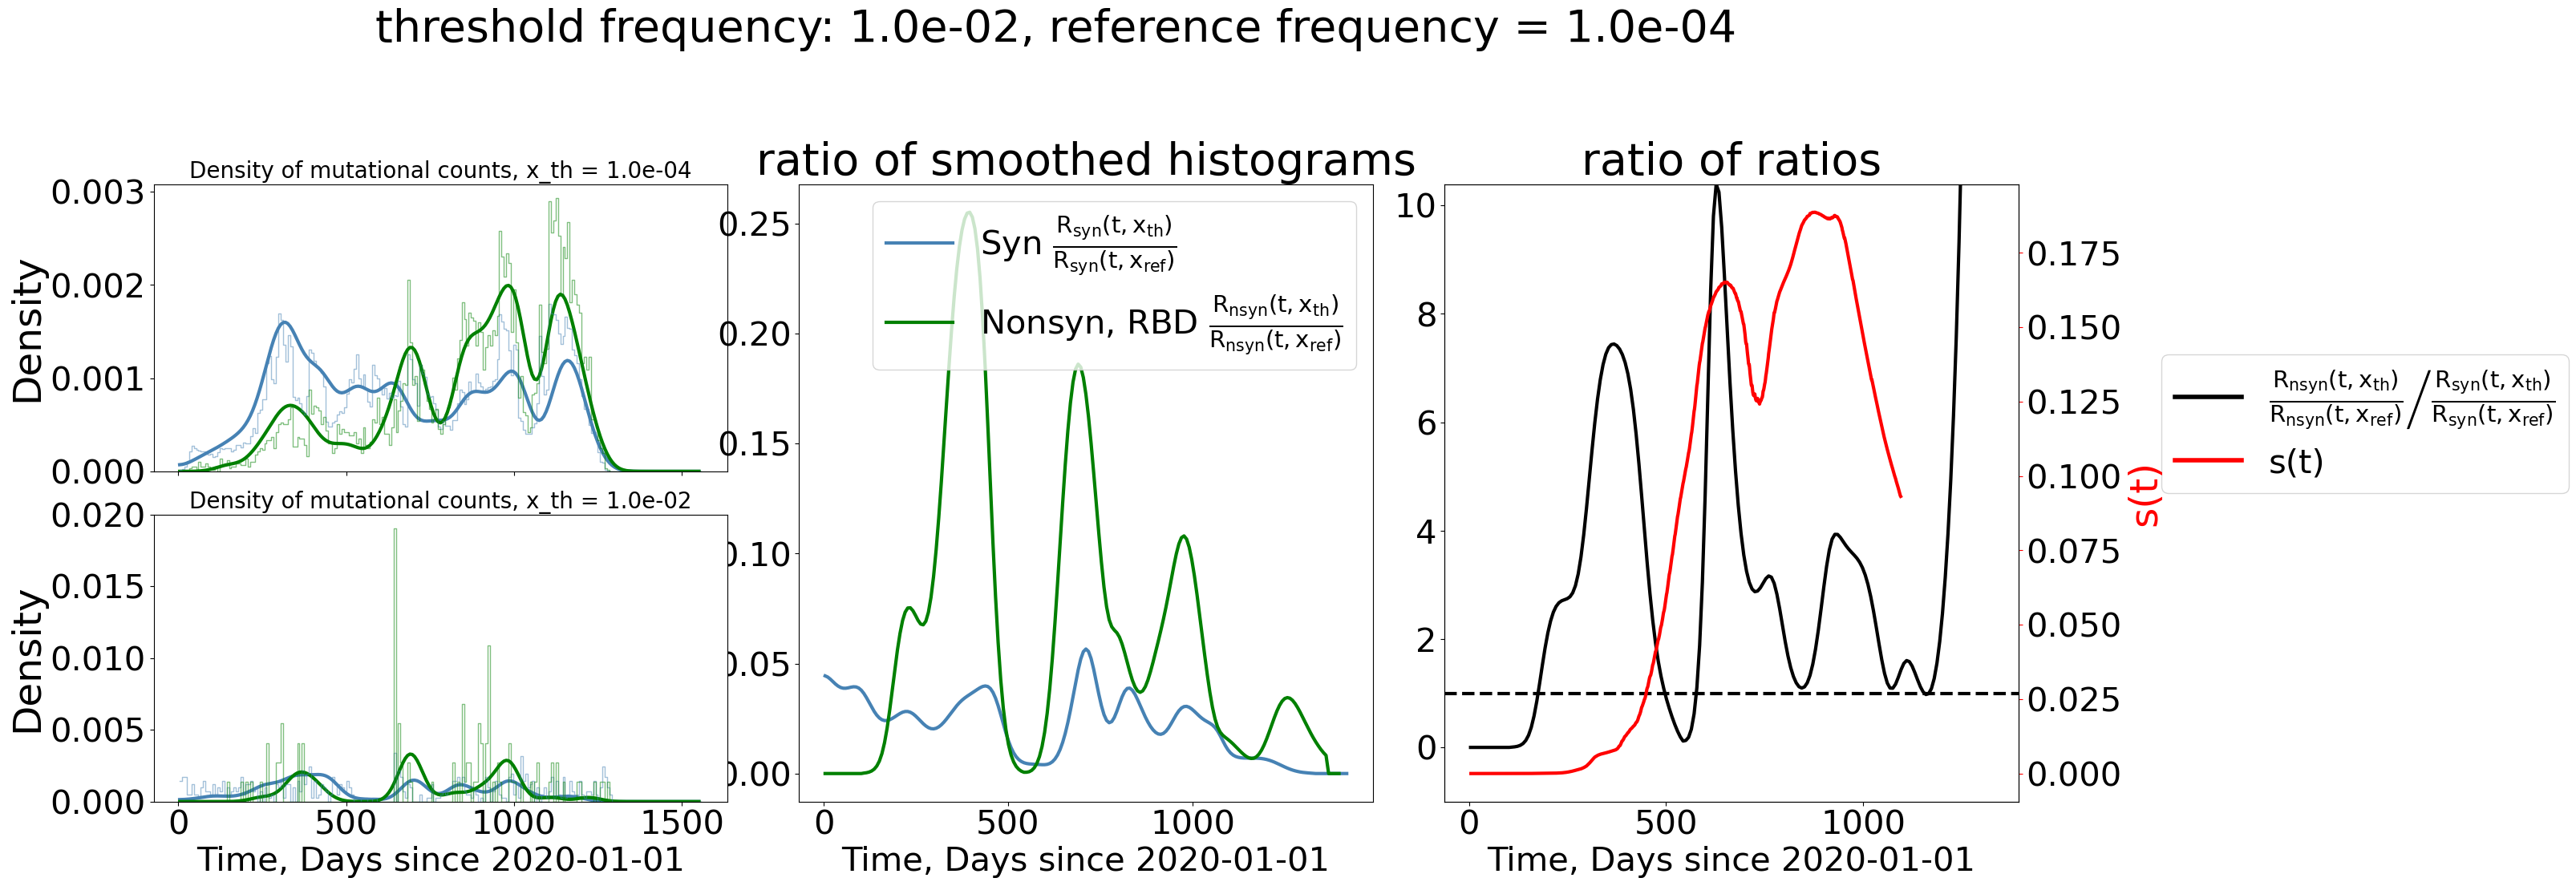

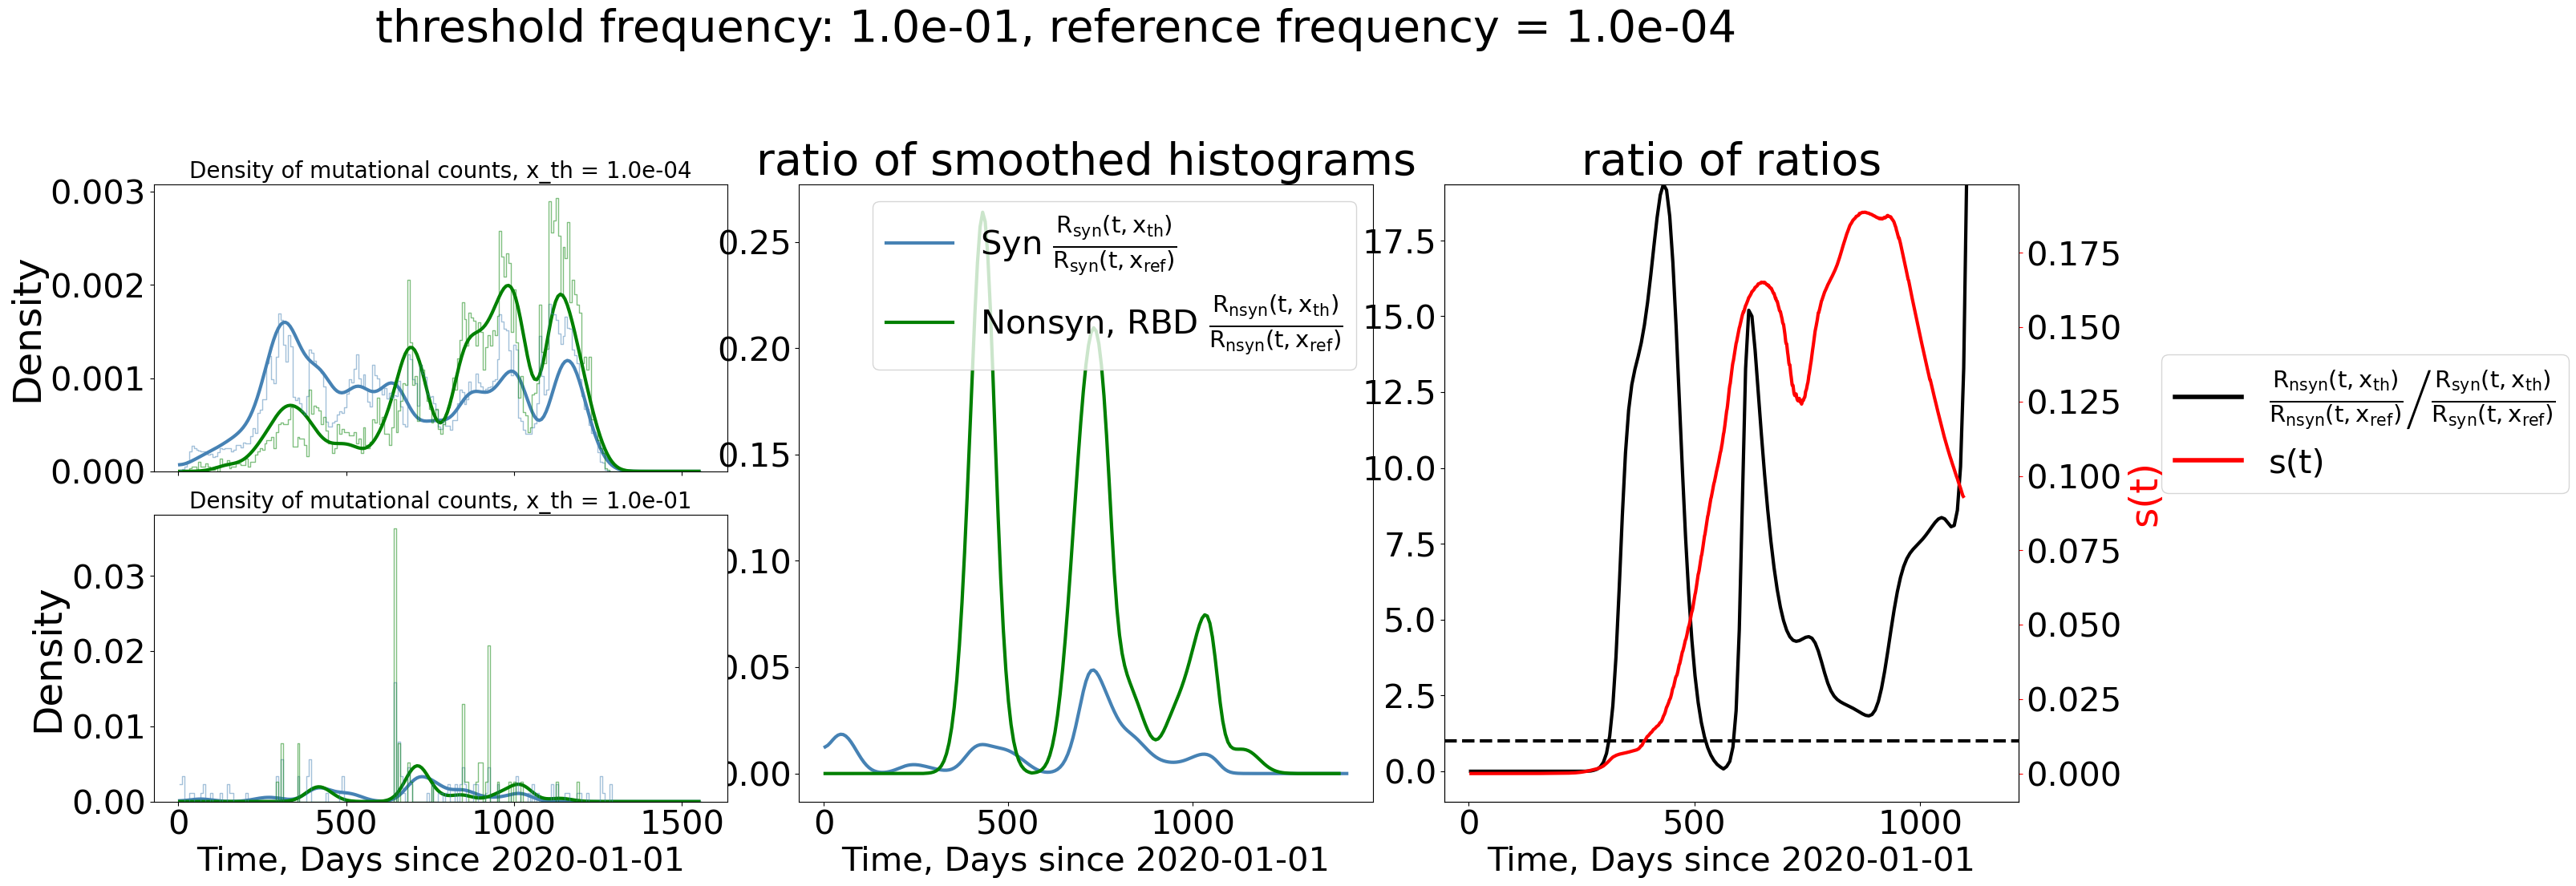

In [ ]:
sigma_smoothing = 5

figure_mosaic = """
    AAACCCDDD
    BBBCCCDDD
    """

hist_ts = day_diff_weekly[:-1]
x_thresh_ref =1e-4
x_thresh_vals = np.array(x_thresh_vals)

for x_thresh in x_thresh_vals[x_thresh_vals>x_thresh_ref]:
    fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(30,10))
    plt.subplots_adjust(wspace=.5,hspace=.15)

    href_syn, bref_syn = np.histogram(syn_clade_stats[f'day_diff_x_bgr_{x_thresh_ref}'].dropna(),bins = day_diff_weekly, density= False)
    hx_syn, bx_syn = np.histogram(syn_clade_stats[f'day_diff_x_bgr_{x_thresh}'].dropna(),bins = day_diff_weekly, density= False)

    href_nonsyn_RBD, bref_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats[f'day_diff_x_bgr_{x_thresh_ref}'].dropna(),bins = day_diff_weekly, density= False)
    
    hx_nonsyn_RBD, bx_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats[f'day_diff_x_bgr_{x_thresh}'].dropna(),bins = day_diff_weekly, density= False)

    ratio_nonsyn_RBD = hx_nonsyn_RBD/href_nonsyn_RBD
    ratio_syn = hx_syn/href_syn

    smoothed_href_syn = gaussian_filter1d(href_syn.astype('float'), sigma = sigma_smoothing)
    smoothed_hx_syn = gaussian_filter1d(hx_syn.astype('float'), sigma = sigma_smoothing)

    smoothed_href_nonsyn_RBD = gaussian_filter1d(href_nonsyn_RBD.astype('float'),sigma=sigma_smoothing)
    smoothed_hx_nonsyn_RBD = gaussian_filter1d(hx_nonsyn_RBD.astype('float'),sigma=sigma_smoothing)

    smoothed_ratio_nonsyn_RBD = smoothed_hx_nonsyn_RBD/smoothed_href_nonsyn_RBD
    smoothed_ratio_syn = smoothed_hx_syn/smoothed_href_syn

    ax_densities_0 = axes['A']
    ax_densities_x_thresh = axes['B']

    ax_densities_0.plot(hist_ts, smoothed_href_syn/np.trapz(smoothed_href_syn,hist_ts),color='steelblue')
    ax_densities_0.plot(hist_ts, smoothed_href_nonsyn_RBD/np.trapz(smoothed_href_nonsyn_RBD,hist_ts),color='green')

    ax_densities_x_thresh.plot(hist_ts, smoothed_hx_syn/np.trapz(smoothed_hx_syn,hist_ts),color='steelblue')    
    ax_densities_x_thresh.plot(hist_ts, smoothed_hx_nonsyn_RBD/np.trapz(smoothed_hx_nonsyn_RBD,hist_ts),color='green')

    sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)
    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)

    sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax_densities_x_thresh,element='step', fill=False, stat='density', lw=1)
    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_x_thresh,element='step', fill=False, stat='density', lw=1)
    
    axes['A'].set_xticklabels('')
    axes['A'].set_xlabel('')

    plot_ratio = True
    if plot_ratio:
        ax_ratio = axes['C']
        # ax_ratio.plot(hist_ts, ratio_syn, color='steelblue',alpha=.5)
        # ax_ratio.plot(hist_ts, ratio_nonsyn_RBD, color='green',alpha=.5)
        ax_ratio.plot(hist_ts, smoothed_ratio_syn, color='steelblue', label = 'Syn ' + r'$\frac{R_{syn}(t,x_\mathrm{th})}{R_{syn}(t,x_\mathrm{ref})}$')
        ax_ratio.plot(hist_ts, smoothed_ratio_nonsyn_RBD, color='green', label = 'Nonsyn, RBD ' + r'$\frac{R_{nsyn}(t,x_\mathrm{th})}{R_{nsyn}(t,x_\mathrm{ref})}$')

    plot_ratio_of_ratios = True
    if plot_ratio_of_ratios:
        ax_ratio_of_ratios = axes['D']
        # ax_ratio_of_ratios.plot(hist_ts, ratio_nonsyn_RBD/ratio_syn,alpha=.5, color='black')
        ax_ratio_of_ratios.plot(hist_ts, smoothed_ratio_nonsyn_RBD/smoothed_ratio_syn,color= 'black', label = r'$\left.\frac{R_{nsyn}(t,x_\mathrm{th})}{R_{nsyn}(t,x_\mathrm{ref})}\middle/\frac{R_{syn}(t,x_\mathrm{th})}{R_{syn}(t,x_\mathrm{ref})}\right.$' )
        ax_ratio_of_ratios.axhline(1,color='k',ls='--')
    
    tax_D= axes['D'].twinx()
    tax_D.plot(day_diff, avg_pot_selection,color='red')
    tax_D.grid(False)
    tax_D.tick_params(color='red')
    tax_D.set_ylabel('s(t)',color='red')
    
    fig.suptitle(f'threshold frequency: {x_thresh:.1e}, reference frequency = {x_thresh_ref:.1e}',y=1.1)

    for ax_label in['B',"C",'D']:
        axes[ax_label].set_xlabel('Time, Days since 2020-01-01',fontsize=30)

    for a in axes:
        axes[a].tick_params(labelsize=30)

    # ax_ratio.set_ylim(top=np.min((20,1.5*np.max((ratio_syn[~np.isnan(ratio_syn)].max(),ratio_nonsyn_RBD[~np.isnan(ratio_nonsyn_RBD)].max())))),bottom=-1)

    axes['A'].set_title(f'Density of mutational counts, x_th = {x_thresh_ref:.1e}',fontsize=20)
    axes['B'].set_title(f'Density of mutational counts, x_th = {x_thresh:.1e}',fontsize=20)

    axes['C'].set_title('ratio of smoothed histograms')
    axes['D'].set_title('ratio of ratios')

    axes['C'].legend(loc='best',fontsize=30)

    handles_D = [
    Line2D([0], [0], color='black', lw=4, label=r'$\left.\frac{R_{nsyn}(t,x_\mathrm{th})}{R_{nsyn}(t,x_\mathrm{ref})}\middle/\frac{R_{syn}(t,x_\mathrm{th})}{R_{syn}(t,x_\mathrm{ref})}\right.$'),
    Line2D([0], [0], color='red', lw=4, label='s(t)'),   
    ]
    ratio_of_ratios = smoothed_ratio_nonsyn_RBD/smoothed_ratio_syn
    mmax =np.max(ratio_of_ratios[np.logical_and(~np.isnan(ratio_of_ratios),~np.isinf(ratio_of_ratios))] [:-20])

    axes['D'].legend(handles = handles_D, loc=(1.25,.5),fontsize=30)
    axes['D'].set_ylim(top=mmax,bottom=-1)
    savefig=1
    if savefig:
        os.makedirs(output_folder+f'/data_analysis_s_t_est_{x_thresh_ref}/',exist_ok = True)
        fig.savefig(output_folder+f'/data_analysis_s_t_est_{x_thresh_ref}/'+f'multiplot_ratios_x_th{x_thresh:.1e}_xref_{x_thresh_ref:.1e}.pdf',bbox_inches='tight')


4.0921759386159104

In [ ]:
clade_list = ['WT', 'B.1.617.2', 'B.1.1.7', 'BA.1', 'BA.2', 'BA.5', 'JN.1', 'JN.1.4', 'BF.7', 'XBB.1.5', 'XBB.1.16', 'HK.3'  ]
avg_fit = np.sum([fitness_france[c+'_freq']*(fitness_france[c+'_fitness_inf']+fitness_france[c+'_fitness_vac'])\
                for c in clade_list],axis=0)

df_reworked = pd.DataFrame(columns = ['clade','day_diff','freq','avg_fit'])

for c in clade_list:
    vals  =fitness_france[[c+'_freq', c+'_fitness_vac', c+'_fitness_inf', c + '_F_pot_inf', c + '_F_pot_vac' , 'day_diff']]
    df_vals = pd.DataFrame(vals.values,columns=['freq','fit_vac','fit_inf',  'f_pot_inf','f_pot_vac','day_diff'])
    df_vals['avg_fit'] = avg_fit
    df_vals['cases'] = fitness_france['cases']
    extra_col = [c for i in range(len(vals))]

    df_reworked = pd.concat([df_reworked,pd.concat( [pd.DataFrame(extra_col,columns=['clade']),df_vals],axis=1)],axis=0)
df_reworked['fit'] = df_reworked['fit_vac'] + df_reworked['fit_inf']
df_reworked['f_pot'] = df_reworked['f_pot_inf'] + df_reworked['f_pot_vac']

df_reworked['selection'] = (df_reworked['fit'] - df_reworked['avg_fit'])*(df_reworked['freq']>0)
df_reworked['pot_selection'] = (df_reworked['f_pot'] - df_reworked['avg_fit'])*(df_reworked['freq']>0)
df_reworked['y_t'] = df_reworked['freq']*df_reworked['cases']
df_reworked['s_times_y_t'] = df_reworked['y_t']*df_reworked['selection']
df_reworked['pot_s_times_y_t'] = df_reworked['y_t']*df_reworked['pot_selection']

In [ ]:
day_diff_weekly[::2]

384403       4
384417      18
384431      32
384445      46
384459      60
          ... 
385901    1502
385915    1516
385929    1530
385943    1544
385957    1558
Name: day_diff, Length: 112, dtype: int64

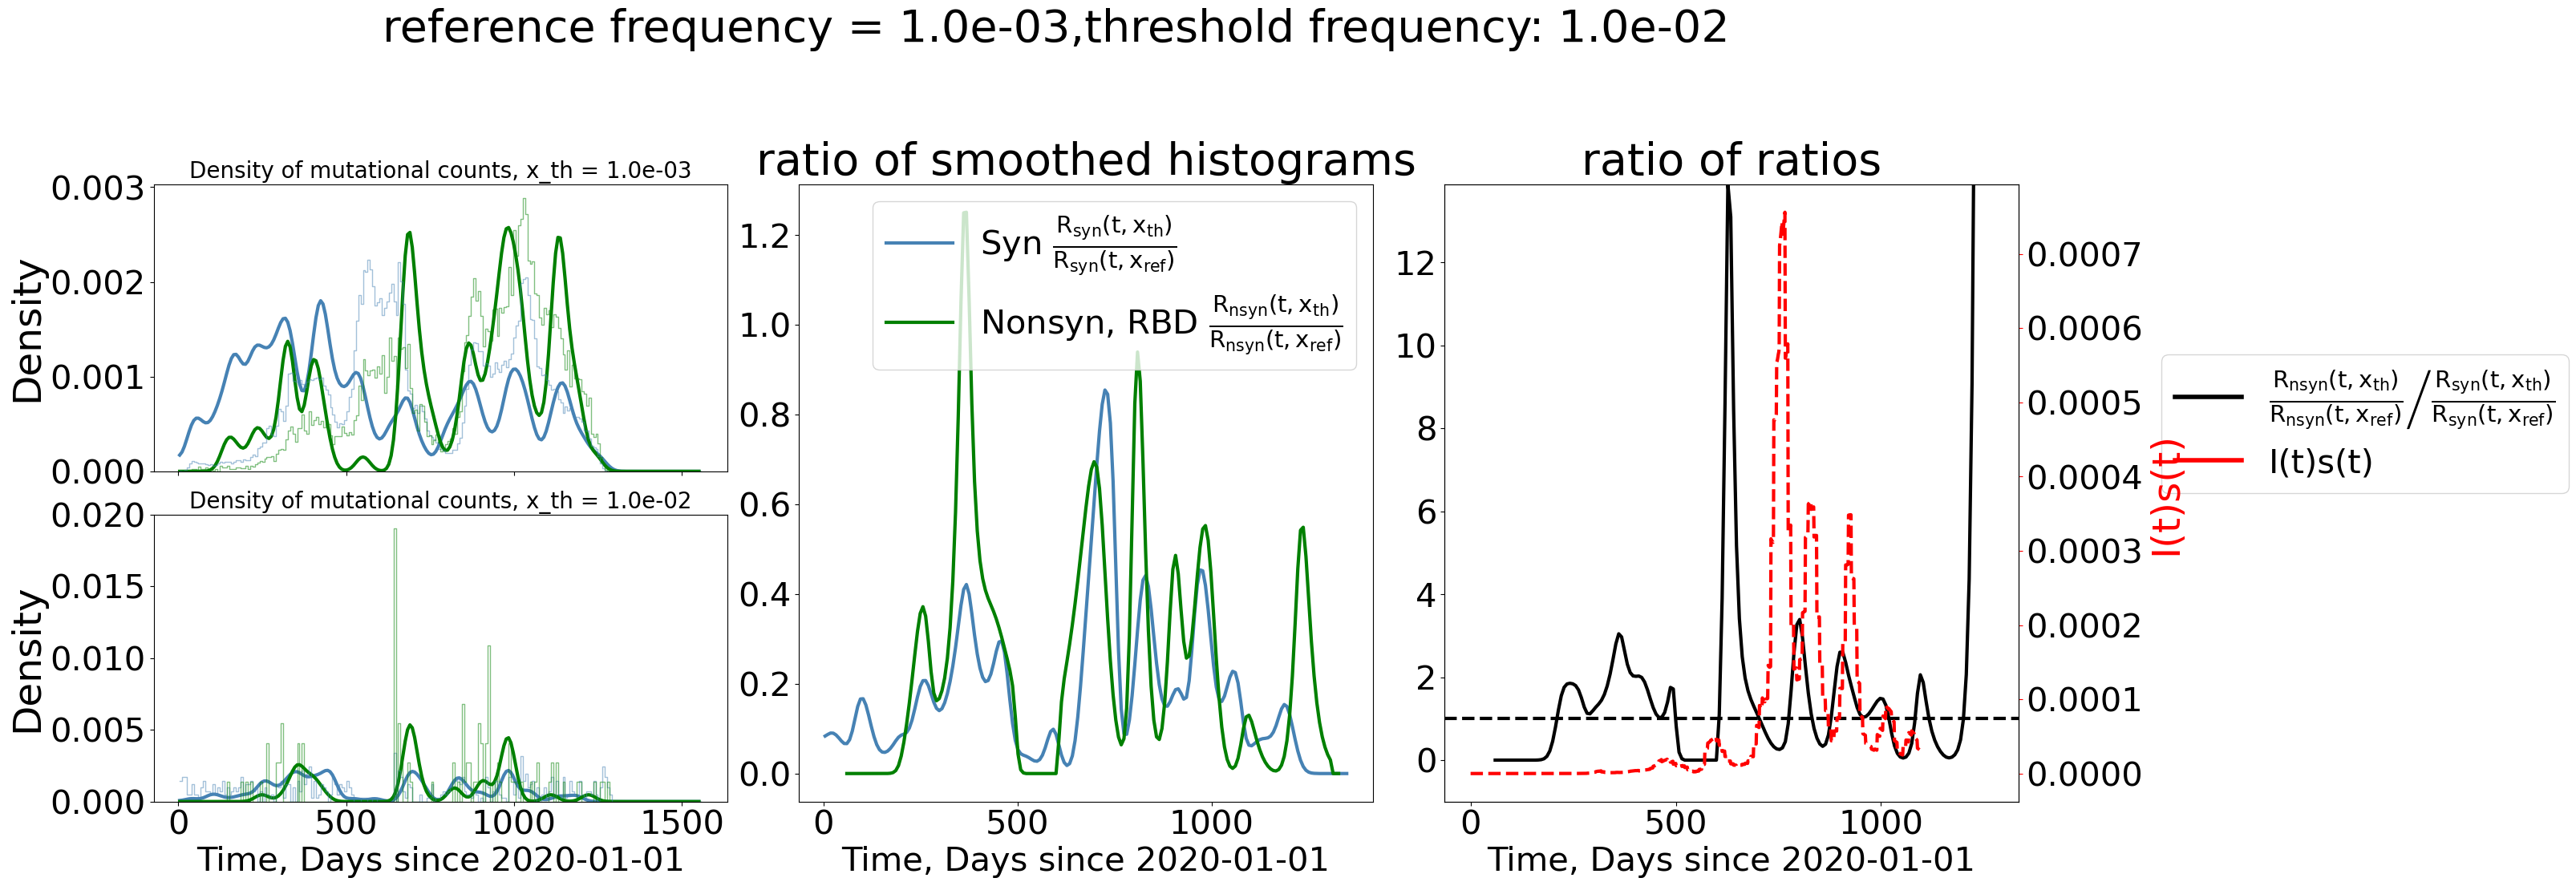

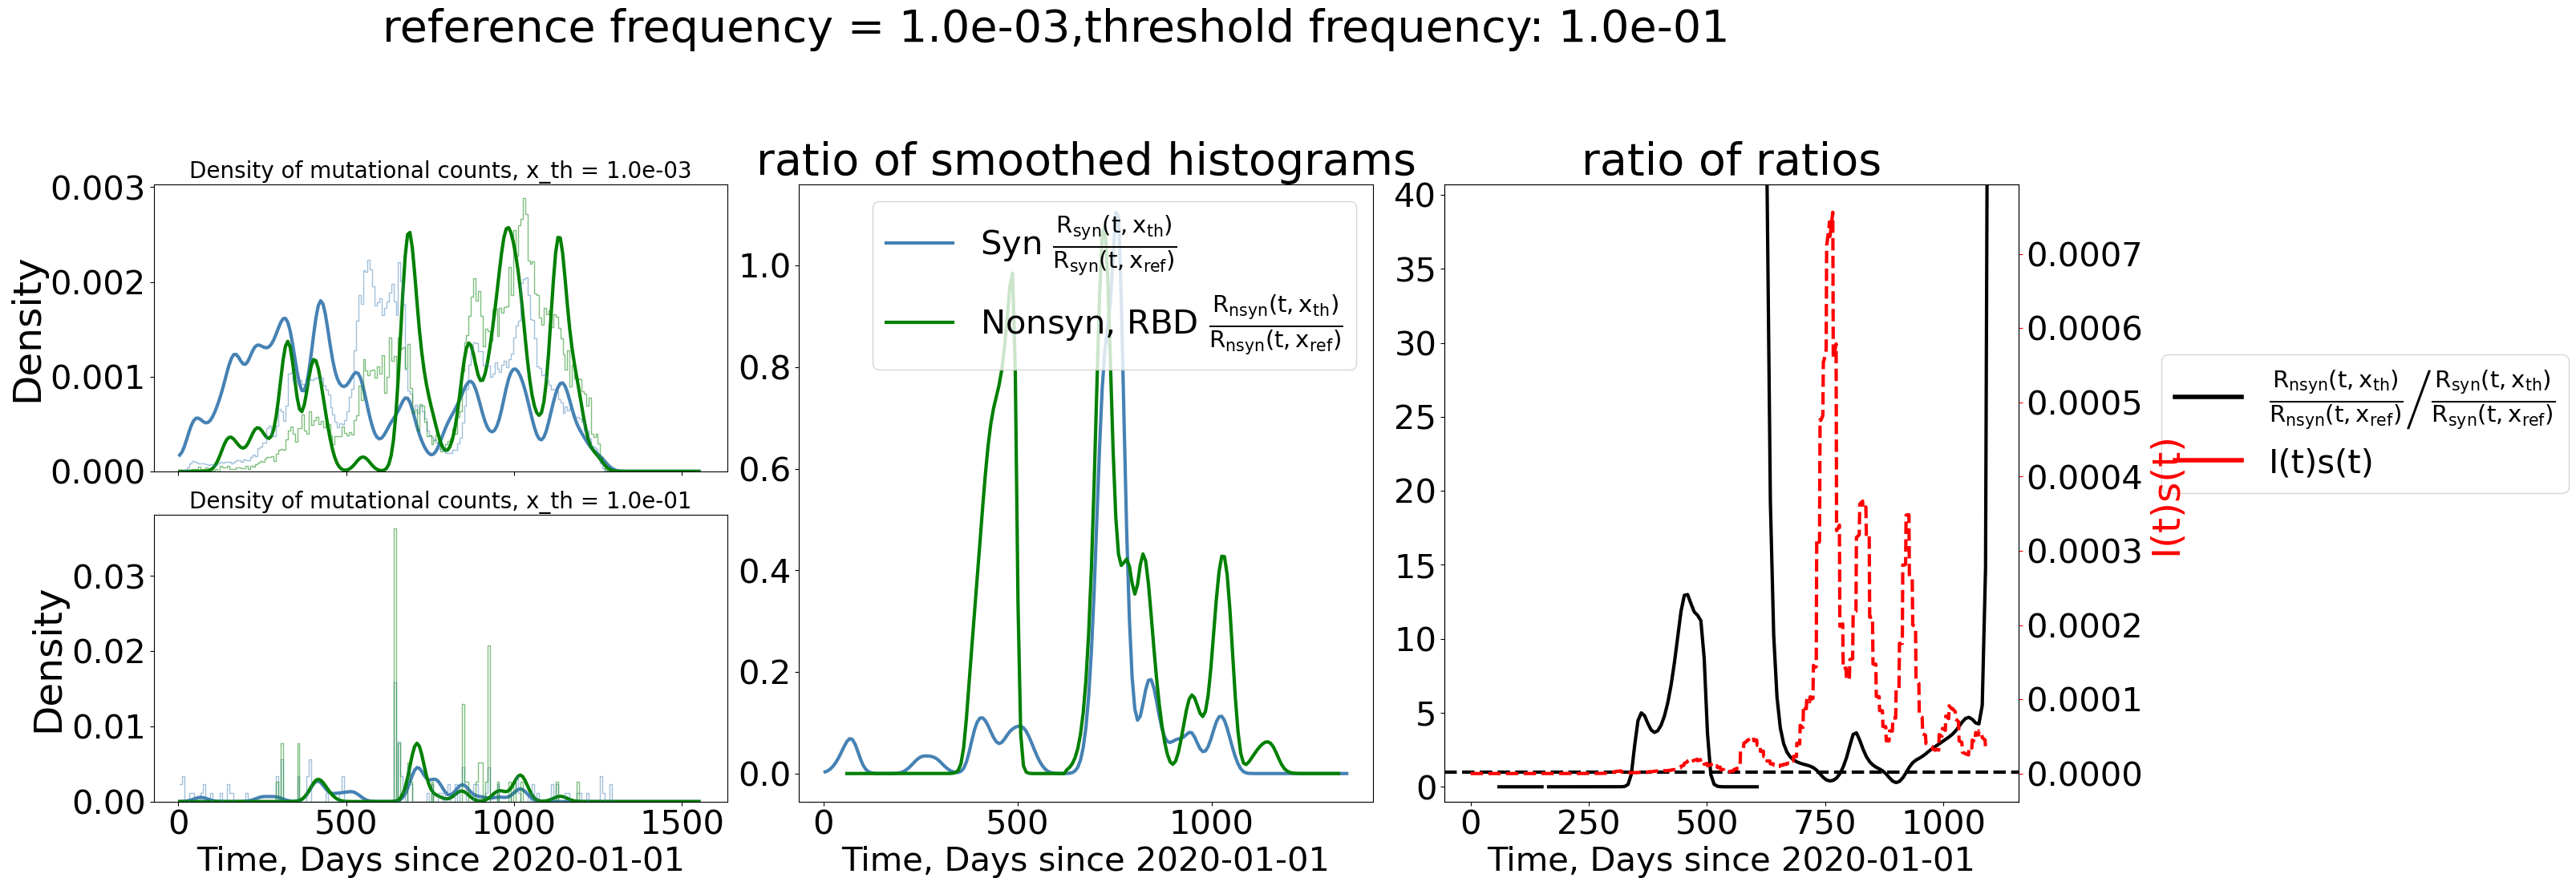

In [ ]:
sigma_smoothing = 3

figure_mosaic = """
    AAACCCDDD
    BBBCCCDDD
    """

hist_ts = day_diff_weekly
val_ts= hist_ts[:-1]

x_thresh_ref =1e-3

for x_thresh in x_thresh_vals[x_thresh_vals>x_thresh_ref]:
    fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(30,10))
    plt.subplots_adjust(wspace=.5,hspace=.15)

    href_syn, bref_syn = np.histogram(syn_clade_stats[f'day_diff_x_bgr_{x_thresh_ref}'].dropna(),bins = hist_ts, density= False)
    hx_syn, bx_syn = np.histogram(syn_clade_stats[f'day_diff_x_bgr_{x_thresh}'].dropna(),bins = hist_ts, density= False)

    href_nonsyn_RBD, bref_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats[f'day_diff_x_bgr_{x_thresh_ref}'].dropna(),bins = hist_ts, density= False)
    
    hx_nonsyn_RBD, bx_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats[f'day_diff_x_bgr_{x_thresh}'].dropna(),bins = hist_ts, density= False)

    ratio_nonsyn_RBD = hx_nonsyn_RBD/href_nonsyn_RBD
    ratio_syn = hx_syn/href_syn

    smoothed_href_syn = gaussian_filter1d(href_syn.astype('float'), sigma = sigma_smoothing)
    smoothed_hx_syn = gaussian_filter1d(hx_syn.astype('float'), sigma = sigma_smoothing)

    smoothed_href_nonsyn_RBD = gaussian_filter1d(href_nonsyn_RBD.astype('float'),sigma=sigma_smoothing)
    smoothed_hx_nonsyn_RBD = gaussian_filter1d(hx_nonsyn_RBD.astype('float'),sigma=sigma_smoothing)

    smoothed_ratio_nonsyn_RBD = smoothed_hx_nonsyn_RBD/smoothed_href_nonsyn_RBD
    smoothed_ratio_syn = smoothed_hx_syn/smoothed_href_syn

    ax_densities_0 = axes['A']
    ax_densities_x_thresh = axes['B']

    ax_densities_0.plot(val_ts, smoothed_href_syn/np.trapz(smoothed_href_syn,val_ts),color='steelblue')
    ax_densities_0.plot(val_ts, smoothed_href_nonsyn_RBD/np.trapz(smoothed_href_nonsyn_RBD,val_ts),color='green')

    ax_densities_x_thresh.plot(val_ts, smoothed_hx_syn/np.trapz(smoothed_hx_syn,val_ts),color='steelblue')    
    ax_densities_x_thresh.plot(val_ts, smoothed_hx_nonsyn_RBD/np.trapz(smoothed_hx_nonsyn_RBD,val_ts),color='green')

    sns.histplot(syn_clade_stats.query(f'Max_Freq > {0}')['day_diff'],bins = hist_ts, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)
    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {0}')['day_diff'],bins = hist_ts, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)

    sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = hist_ts, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax_densities_x_thresh,element='step', fill=False, stat='density', lw=1)
    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = hist_ts, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_x_thresh,element='step', fill=False, stat='density', lw=1)
    
    axes['A'].set_xticklabels('')
    axes['A'].set_xlabel('')

    plot_ratio = True
    if plot_ratio:
        ax_ratio = axes['C']
        # ax_ratio.plot(hist_ts, ratio_syn, color='steelblue',alpha=.5)
        # ax_ratio.plot(hist_ts, ratio_nonsyn_RBD, color='green',alpha=.5)
        ax_ratio.plot(val_ts, smoothed_ratio_syn, color='steelblue', label = 'Syn ' + r'$\frac{R_{syn}(t,x_\mathrm{th})}{R_{syn}(t,x_\mathrm{ref})}$')
        ax_ratio.plot(val_ts, smoothed_ratio_nonsyn_RBD, color='green', label = 'Nonsyn, RBD ' + r'$\frac{R_{nsyn}(t,x_\mathrm{th})}{R_{nsyn}(t,x_\mathrm{ref})}$')

    plot_ratio_of_ratios = True
    if plot_ratio_of_ratios:
        ax_ratio_of_ratios = axes['D']
        # ax_ratio_of_ratios.plot(hist_ts, ratio_nonsyn_RBD/ratio_syn,alpha=.5, color='black')
        ax_ratio_of_ratios.plot(val_ts, smoothed_ratio_nonsyn_RBD/smoothed_ratio_syn,color= 'black', label = r'$\left.\frac{R_{nsyn}(t,x_\mathrm{th})}{R_{nsyn}(t,x_\mathrm{ref})}\middle/\frac{R_{syn}(t,x_\mathrm{th})}{R_{syn}(t,x_\mathrm{ref})}\right.$' )
        ax_ratio_of_ratios.axhline(1,color='k',ls='--')

    
    tax_D= axes['D'].twinx()
    # tax_D.plot(day_diff, cases*avg_pot_selection,color='red')
    df_reworked.groupby(['day_diff']).apply(lambda x: np.sum(x['cases']*x['freq']*x['pot_selection'])).plot(color='red',ax=tax_D,ls= '--')

    # tax_D.plot(day_diff[:-20], cases[:-20],color='orange')
    tax_D.grid(False)
    tax_D.tick_params(color='red')
    tax_D.set_ylabel('I(t)s(t)',color='red')
    
    fig.suptitle(f'reference frequency = {x_thresh_ref:.1e},threshold frequency: {x_thresh:.1e}',y=1.1)

    for ax_label in['B',"C",'D']:
        axes[ax_label].set_xlabel('Time, Days since 2020-01-01',fontsize=30)

    for a in axes:
        axes[a].tick_params(labelsize=30)


    # ax_ratio.set_ylim(top=np.min((20,1.5*np.max((ratio_syn[~np.isnan(ratio_syn)].max(),ratio_nonsyn_RBD[~np.isnan(ratio_nonsyn_RBD)].max())))),bottom=-1)

    axes['A'].set_title(f'Density of mutational counts, x_th = {x_thresh_ref:.1e}',fontsize=20)
    axes['B'].set_title(f'Density of mutational counts, x_th = {x_thresh:.1e}',fontsize=20)

    axes['C'].set_title('ratio of smoothed histograms')
    axes['D'].set_title('ratio of ratios')

    axes['C'].legend(loc='best',fontsize=30)

    handles_D = [
    Line2D([0], [0], color='black', lw=4, label=r'$\left.\frac{R_{nsyn}(t,x_\mathrm{th})}{R_{nsyn}(t,x_\mathrm{ref})}\middle/\frac{R_{syn}(t,x_\mathrm{th})}{R_{syn}(t,x_\mathrm{ref})}\right.$'),
    Line2D([0], [0], color='red', lw=4, label='I(t)s(t)'),   
    ]
    ratio_of_ratios = smoothed_ratio_nonsyn_RBD/smoothed_ratio_syn
    mmax =np.max(ratio_of_ratios[np.logical_and(~np.isnan(ratio_of_ratios),~np.isinf(ratio_of_ratios))] [:-20])

    axes['D'].legend(handles = handles_D, loc=(1.25,.5),fontsize=30)
    axes['D'].set_ylim(top=mmax,bottom=-1)
    savefig=1
    if savefig:
        os.makedirs(output_folder+f'/data_analysis_Is_t_est_{x_thresh_ref}/',exist_ok = True)
        fig.savefig(output_folder+f'/data_analysis_Is_t_est_{x_thresh_ref}/'+f'multiplot_ratios_x_th{x_thresh:.1e}_xref_{x_thresh_ref:.1e}.pdf',bbox_inches='tight')


    


In [ ]:
smoothed_href_syn.shape, val_ts.shape

((222,), (222,))

In [ ]:
import statsmodels.api as sm

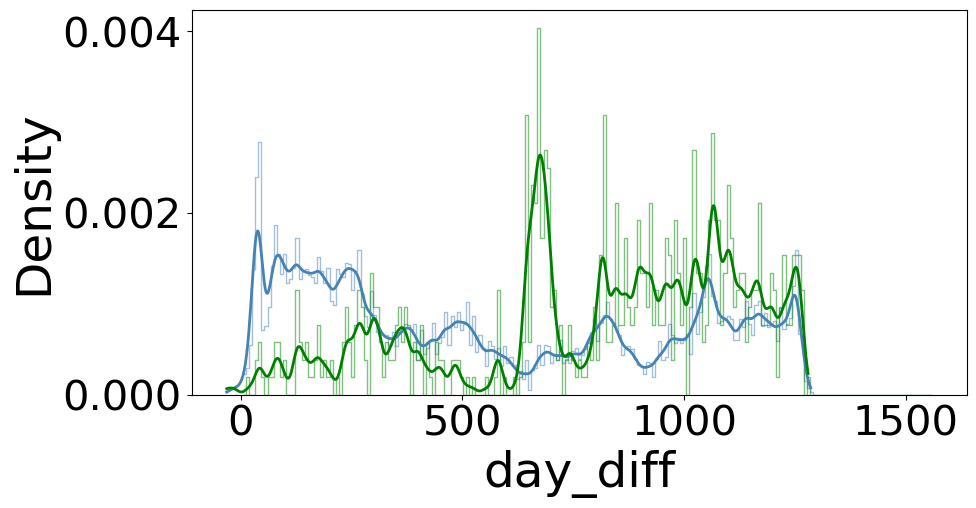

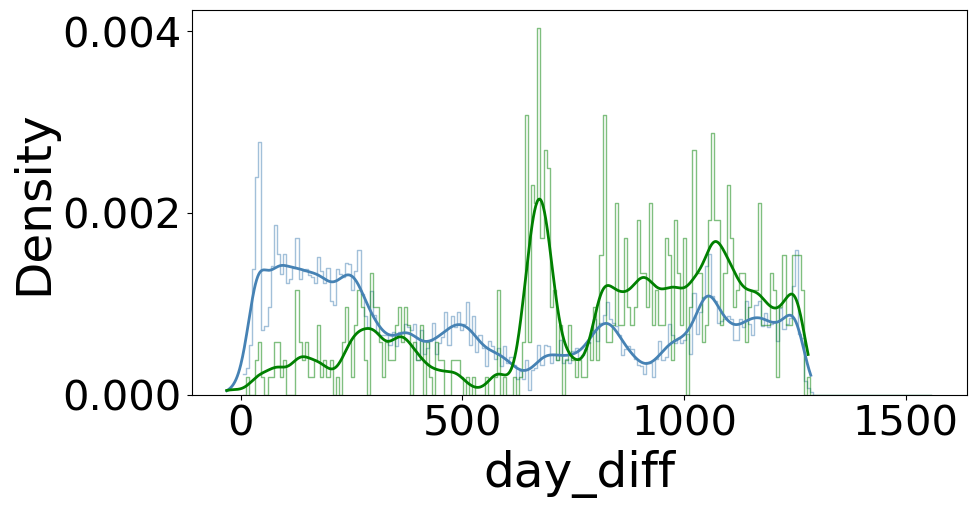

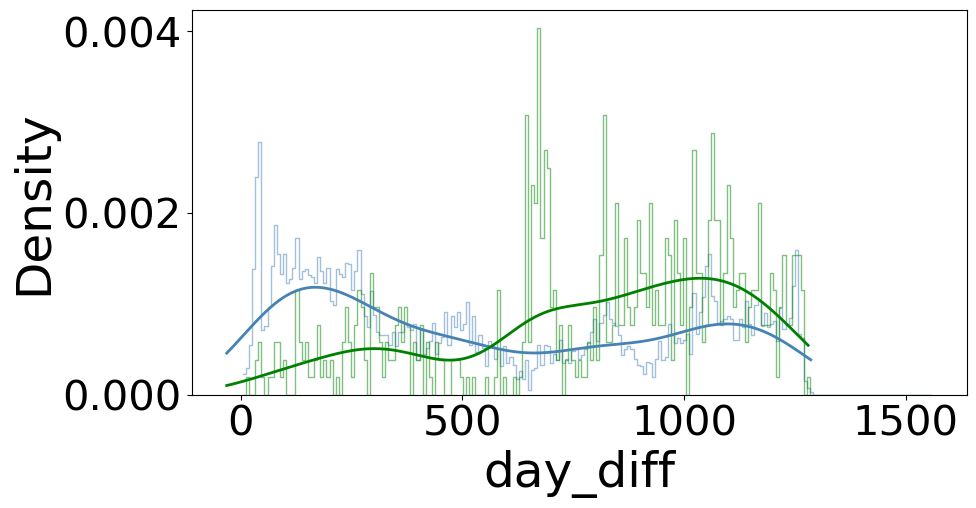

In [ ]:
sigma_smoothing = 3
hist_ts = day_diff_weekly
val_ts= hist_ts[:-1]
x_thresh_ref =1e-3

def get_kde(data, bw_adjust = .15, bw_method = 'scott', ax = None, grid_min = None, grid_max = None, grid_size = 1000):
    #if ax is None create a fake figure
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit(bw=bw_adjust)
    # Define the grid range if not specified
    if grid_min is None:
        grid_min = np.min(data)
    if grid_max is None:
        grid_max = np.max(data)
    
    # Create a fixed grid
    grid = np.linspace(grid_min, grid_max, grid_size)
    
    # Evaluate the KDE on the fixed grid
    kde_values = kde.evaluate(grid)
    
    return grid, kde_values

modes = ['reflect','constant','nearest','mirror','wrap']

href_syn, bref_syn = np.histogram(syn_clade_stats[f'day_diff_x_bgr_{x_thresh_ref}'].dropna(),bins = hist_ts, density= False)
# href_nonsyn_RBD, bref_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats[f'day_diff_x_bgr_{x_thresh_ref}'].dropna(),bins = hist_ts, density= False)

# # smoothed_href_nonsyn_RBD = gaussian_filter1d(href_nonsyn_RBD.astype('float'),sigma=sigma_smoothing)
# # ax_densities_0.plot(val_ts, smoothed_href_nonsyn_RBD/np.trapz(smoothed_href_nonsyn_RBD,val_ts),color='green')


# sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {0}')['day_diff'],bins = hist_ts, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_0,element='step', fill=False, stat
# ='density', lw=1)

for bw in [10, 20,100]:
    fig,ax_densities_0 = plt.subplots(figsize=(10,5))
    # for mode in modes:
    #     smoothed_href_syn = gaussian_filter1d(href_syn.astype('float'), sigma = sigma_smoothing,mode=mode,truncate=3, cval=0)
    #     ax_densities_0.plot(val_ts, smoothed_href_syn/np.trapz(smoothed_href_syn,val_ts),color='steelblue',lw=1)
        
    # sns.kdeplot(syn_clade_stats.query(f'Max_Freq > {0}')['day_diff'],bw_method='scott',label = 'Synonymous',color='steelblue',ax=ax_densities_0,fill=False, lw=1, kde_kws={'linestyle':'--','linewidth':1,'alpha':.5})

    sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = hist_ts, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)

    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = hist_ts, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)

    # bw = 1

    day_diff_with_syn_smooth, smoothed_href_syn = get_kde( syn_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'], ax =None, bw_adjust=bw, grid_size=1000)
    ax_densities_0.plot(day_diff_with_syn_smooth, smoothed_href_syn, color='steelblue', lw=2, linestyle='-', alpha=1)

    day_diff_with_nonsyn_RBD_smooth, smoothed_href_nonsyn_RBD = get_kde( nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'], ax =None, bw_adjust=bw, grid_size=1000)
    ax_densities_0.plot(day_diff_with_nonsyn_RBD_smooth, smoothed_href_nonsyn_RBD, color='green', lw=2, linestyle='-', alpha=1)




In [ ]:
day_diff_with_syn_smooth.shape, smoothed_href_syn.shape, day_diff_with_nonsyn_RBD_smooth.shape, smoothed_href_nonsyn_RBD.shape

((1000,), (1000,), (1000,), (1000,))

In [ ]:
xx.shape, hist_ts.shape

((200,), (223,))

In [ ]:
what_kde.get_lines()

<a list of 8 Line2D objects>

In [ ]:
syn_clade_stats['day_diff'].max()

1286

NameError: name 'hx_RBD' is not defined

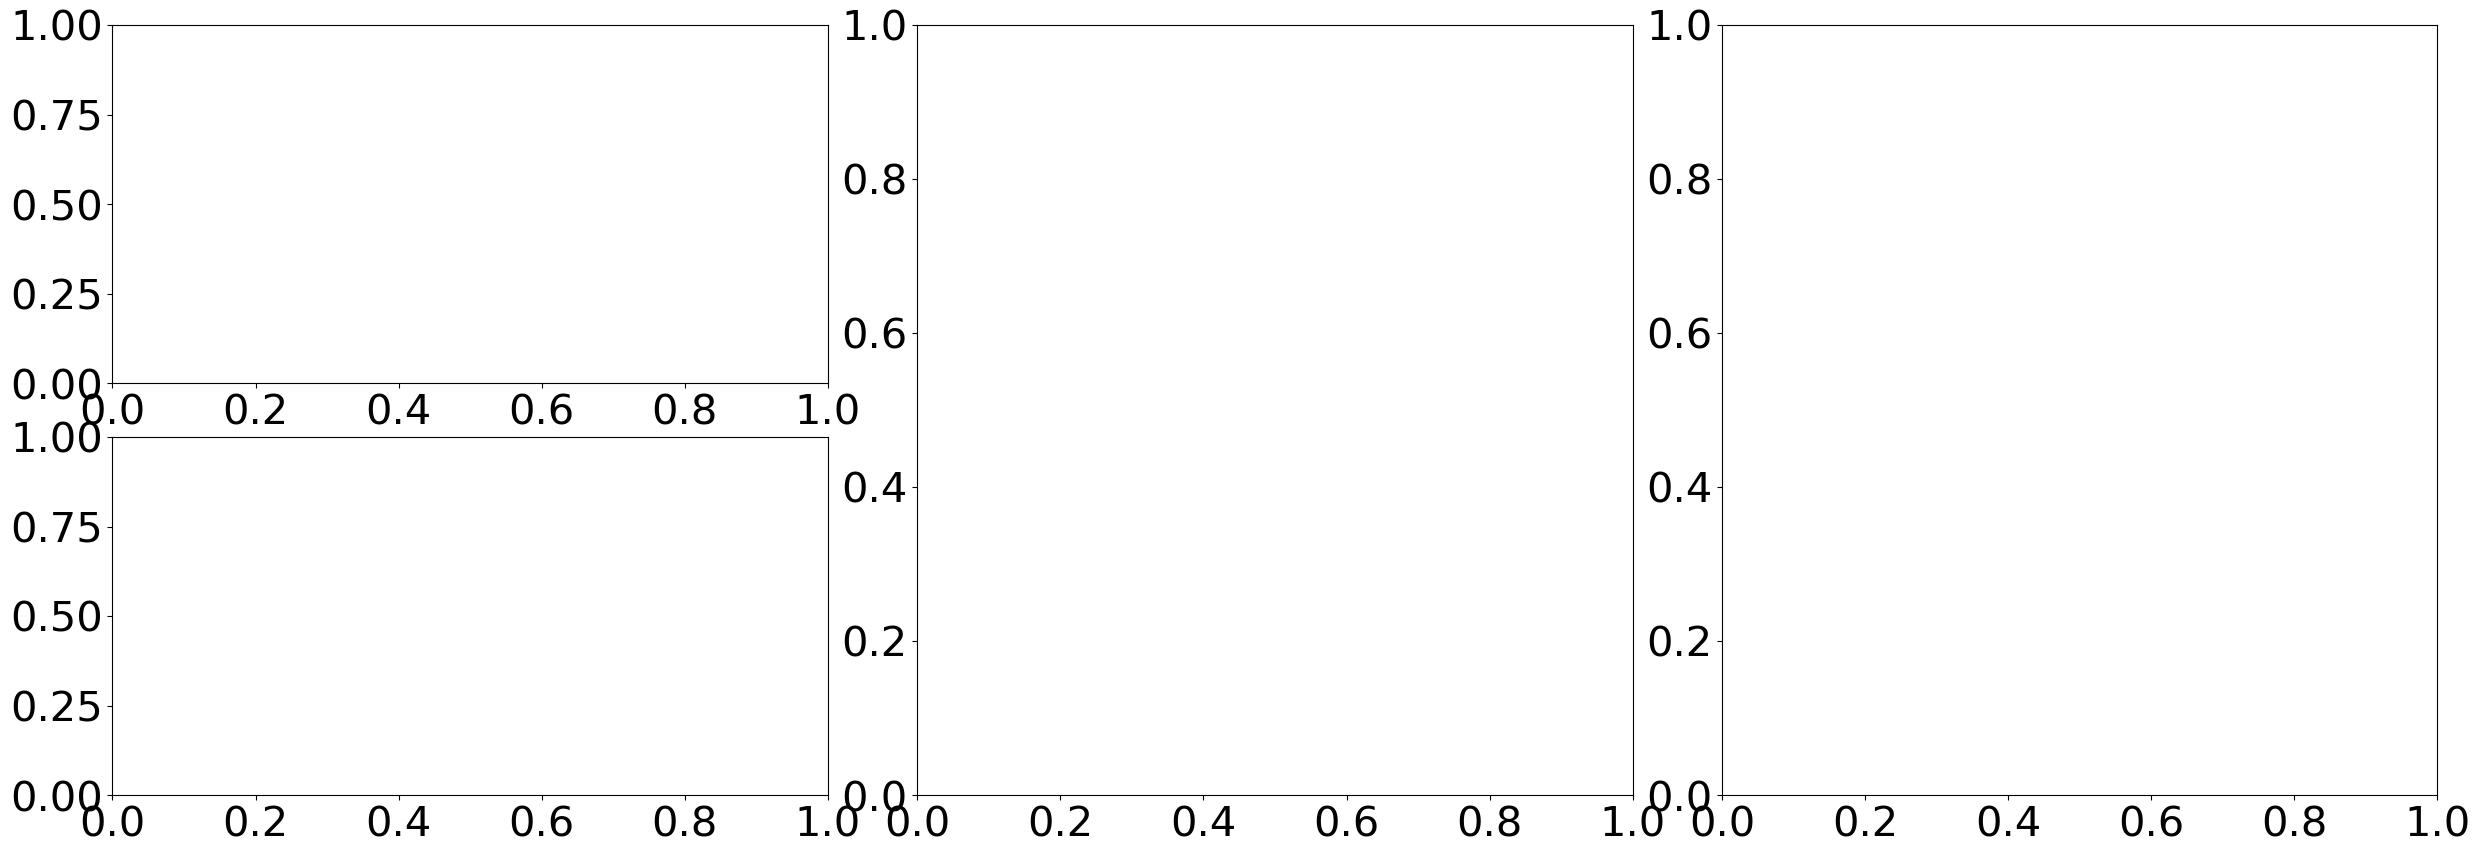

In [ ]:
sigma_smoothing = 3

figure_mosaic = """
    AAACCCDDD
    BBBCCCDDD
    """

hist_ts = day_diff_weekly[:-1]
x_thresh_ref =1e-3

for x_thresh in np.sort(list(set([1e-4,1e-3,1e-2,1e-1]) - set([x_thresh_ref]))):
    fig,axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(30,10))
    plt.subplots_adjust(wspace=.5,hspace=.15)

    href_syn, bref_syn = np.histogram(syn_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, density= False)
    hx_syn, bx_syn = np.histogram(syn_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, density= False)

    href_nonsyn_RBD, bref_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, density= False)
    
    hx_nonsyn_RBD, bx_nonsyn_RBD = np.histogram(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, density= False)

    ratio_nonsyn_RBD = hx_RBD/href_nonsyn_RBD
    ratio_syn = hx_syn/href_syn

    smoothed_href_syn = gaussian_filter1d(href_syn.astype('float'), sigma = sigma_smoothing)
    smoothed_hx_syn = gaussian_filter1d(hx_syn.astype('float'), sigma = sigma_smoothing)

    smoothed_href_nonsyn_RBD = gaussian_filter1d(href_nonsyn_RBD.astype('float'),sigma=sigma_smoothing)
    smoothed_hx_nonsyn_RBD = gaussian_filter1d(hx_nonsyn_RBD.astype('float'),sigma=sigma_smoothing)

    smoothed_ratio_nonsyn_RBD = smoothed_hx_nonsyn_RBD/smoothed_href_nonsyn_RBD
    smoothed_ratio_syn = smoothed_hx_syn/smoothed_href_syn

    ax_densities_0 = axes['A']
    ax_densities_x_thresh = axes['B']

    ax_densities_0.plot(hist_ts, smoothed_href_syn/np.trapz(smoothed_href_syn,hist_ts),color='steelblue')
    ax_densities_0.plot(hist_ts, smoothed_href_nonsyn_RBD/np.trapz(smoothed_href_nonsyn_RBD,hist_ts),color='green')

    ax_densities_x_thresh.plot(hist_ts, smoothed_hx_syn/np.trapz(smoothed_hx_syn,hist_ts),color='steelblue')    
    ax_densities_x_thresh.plot(hist_ts, smoothed_hx_nonsyn_RBD/np.trapz(smoothed_hx_nonsyn_RBD,hist_ts),color='green')

    sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)
    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh_ref}')['day_diff'],bins = day_diff_weekly, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_0,element='step', fill=False, stat='density', lw=1)

    sns.histplot(syn_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, label = 'Synonymous',alpha=0.5, color='steelblue',ax=ax_densities_x_thresh,element='step', fill=False, stat='density', lw=1)
    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {x_thresh}')['day_diff'],bins = day_diff_weekly, label = 'RBD',alpha=0.5, color='green',ax=ax_densities_x_thresh,element='step', fill=False, stat='density', lw=1)
    
    axes['A'].set_xticklabels('')
    axes['A'].set_xlabel('')

    plot_ratio = True
    if plot_ratio:
        ax_ratio = axes['C']
        # ax_ratio.plot(hist_ts, ratio_syn, color='steelblue',alpha=.5)
        # ax_ratio.plot(hist_ts, ratio_nonsyn_RBD, color='green',alpha=.5)
        ax_ratio.plot(hist_ts, smoothed_ratio_syn, color='steelblue', label = 'Syn ' + r'$\frac{R_n(t,x_\mathrm{th})}{R_n(t,x_\mathrm{ref})}$')
        ax_ratio.plot(hist_ts, smoothed_ratio_nonsyn_RBD, color='green', label = 'Nonsyn, RBD ' + r'$\frac{R_s(t,x_\mathrm{th})}{R_s(t,x_\mathrm{ref})}$')

    plot_ratio_of_ratios = True
    if plot_ratio_of_ratios:
        ax_ratio_of_ratios = axes['D']
        # ax_ratio_of_ratios.plot(hist_ts, ratio_nonsyn_RBD/ratio_syn,alpha=.5, color='black')
        ax_ratio_of_ratios.plot(hist_ts, smoothed_ratio_nonsyn_RBD/smoothed_ratio_syn,color= 'black', label = r'$\left.\frac{R_s(t,x_\mathrm{th})}{R_s(t,x_\mathrm{ref})}\middle/\frac{R_n(t,x_\mathrm{th})}{R_n(t,x_\mathrm{ref})}\right.$' )
        ax_ratio_of_ratios.axhline(1,color='k',ls='--')
    
    tax_D= axes['D'].twinx()
    tax_D.plot(day_diff, avg_pot_selection,color='red')
    tax_D.grid(False)
    tax_D.tick_params(color='red')
    tax_D.set_ylabel('s(t)',color='red')
    
    fig.suptitle(f'threshold frequency: {x_thresh:.1e}, reference frequency = {x_thresh_ref:.1e}',y=1.1)

    for ax_label in['B',"C",'D']:
        axes[ax_label].set_xlabel('Time, Days since 2020-01-01',fontsize=30)

    for a in axes:
        axes[a].tick_params(labelsize=30)


    # ax_ratio.set_ylim(top=np.min((20,1.5*np.max((ratio_syn[~np.isnan(ratio_syn)].max(),ratio_nonsyn_RBD[~np.isnan(ratio_nonsyn_RBD)].max())))),bottom=-1)

    axes['A'].set_title(f'Density of mutational counts, x_th = {x_thresh_ref:.1e}',fontsize=20)
    axes['B'].set_title(f'Density of mutational counts, x_th = {x_thresh:.1e}',fontsize=20)

    axes['C'].set_title('ratio of smoothed histograms')
    axes['D'].set_title('ratio of ratios')

    axes['C'].legend(loc='best',fontsize=30)

    handles_D = [
    Line2D([0], [0], color='black', lw=4, label=r'$\left.\frac{R_s(t,x_\mathrm{th})}{R_s(t,x_\mathrm{ref})}\middle/\frac{R_n(t,x_\mathrm{th})}{R_n(t,x_\mathrm{ref})}\right.$'),
    Line2D([0], [0], color='red', lw=4, label='s(t)'),   
    ]

    axes['D'].legend(handles = handles_D, loc='upper left',fontsize=30)
    
    savefig=1
    if savefig:
        os.makedirs(output_folder+f'/data_analysis_s_t_est_{x_thresh_ref}/',exist_ok = True)
        fig.savefig(output_folder+f'/data_analysis_s_t_est_{x_thresh_ref}/'+f'multiplot_ratios_x_th{x_thresh:.1e}_xref_{x_thresh_ref:.1e}.pdf',bbox_inches='tight')


In [ ]:
average_infected_size = covid_data_World['weekly_new_cases_smoothed'].mean()
average_s = nonsyn_S_clade_stats.query('day_diff < 400')['s_w'].mean()

print(f'N = {average_infected_size:.1e}, s = {average_s:.1e}, Ns = {average_infected_size*average_s:.1e}')
print(f'freq_sel= {1/(average_infected_size*average_s):.1e}') 
print(f'hallatschek`s freq_sel= {1000/(average_infected_size*average_s):.1e}') 

KeyError: 's_w'

0.28956111496507103 lifetime: 43.0
nan
0.08255486468006662 lifetime: 43.0
nan
0.04721177725832251 lifetime: 27.0
nan
0.07559866878247962 lifetime: 31.0
nan
0.06004128241691588 lifetime: 29.0
nan
0.09014392402433459 lifetime: 34.0
nan
0.06567690919248946 lifetime: 29.0
nan
0.2773837070869306 lifetime: 44.0
nan
0.16164461295199015 lifetime: 36.0
nan
0.264823710369531 lifetime: 43.0
nan
0.3334503520216925 lifetime: 221.0
0.057241856571847806
0.061891099143490794 lifetime: 63.0
nan
0.24575571603507218 lifetime: 41.0
nan
0.2598487538249637 lifetime: 41.0
nan
0.1978511864064432 lifetime: 73.0
nan
0.20312087380909447 lifetime: 39.0
nan
0.18752811962491867 lifetime: 114.0
nan
0.3557639139020967 lifetime: 183.0
0.02189153207845949
0.186139830540674 lifetime: 79.0
nan
0.11609069775169795 lifetime: 33.0
nan


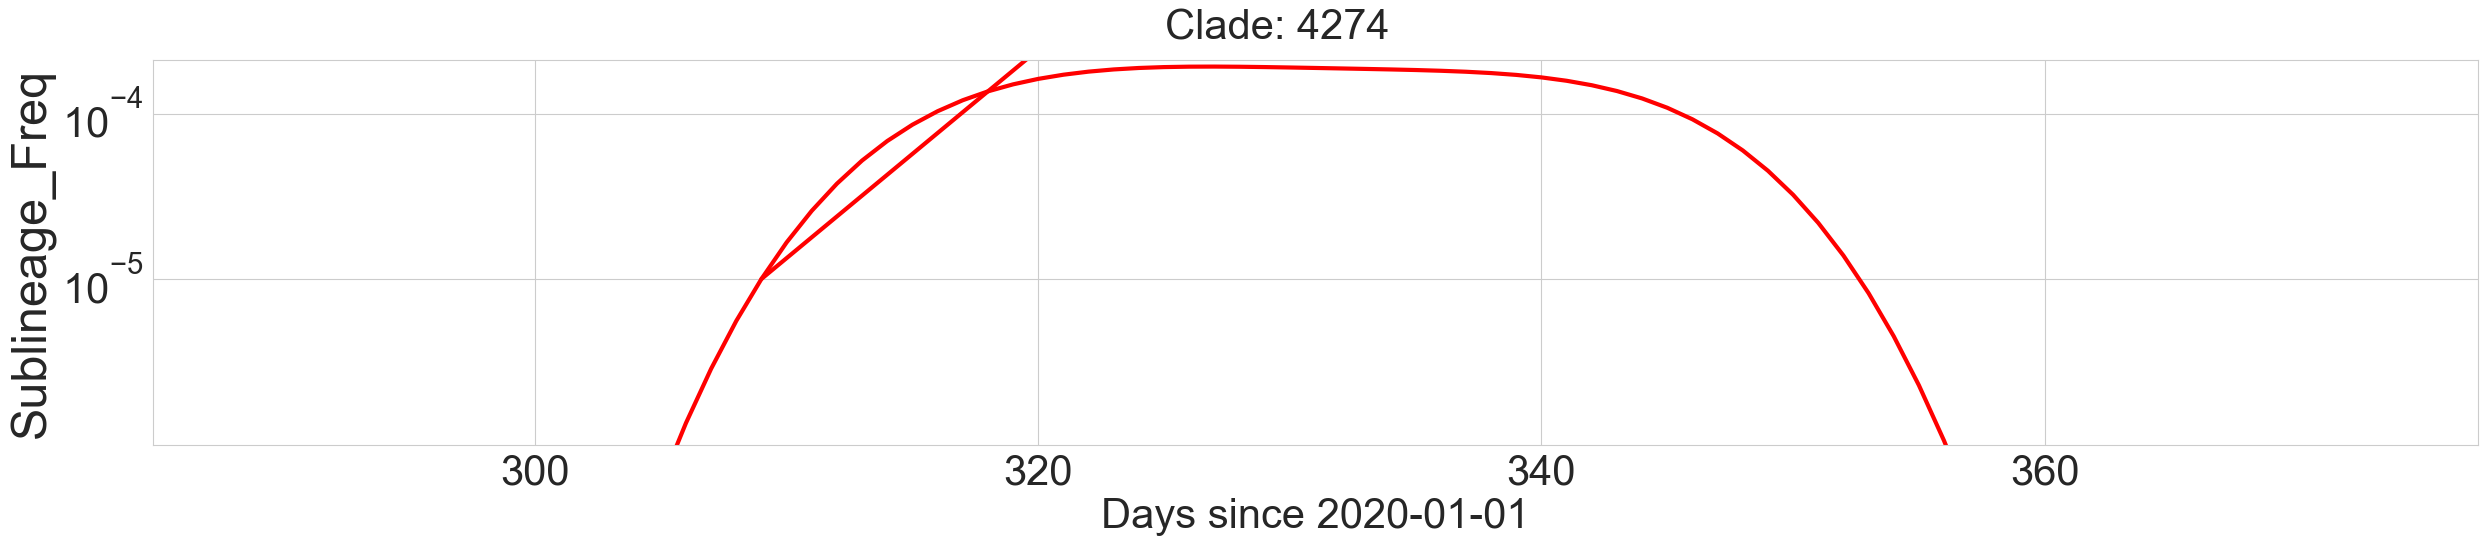

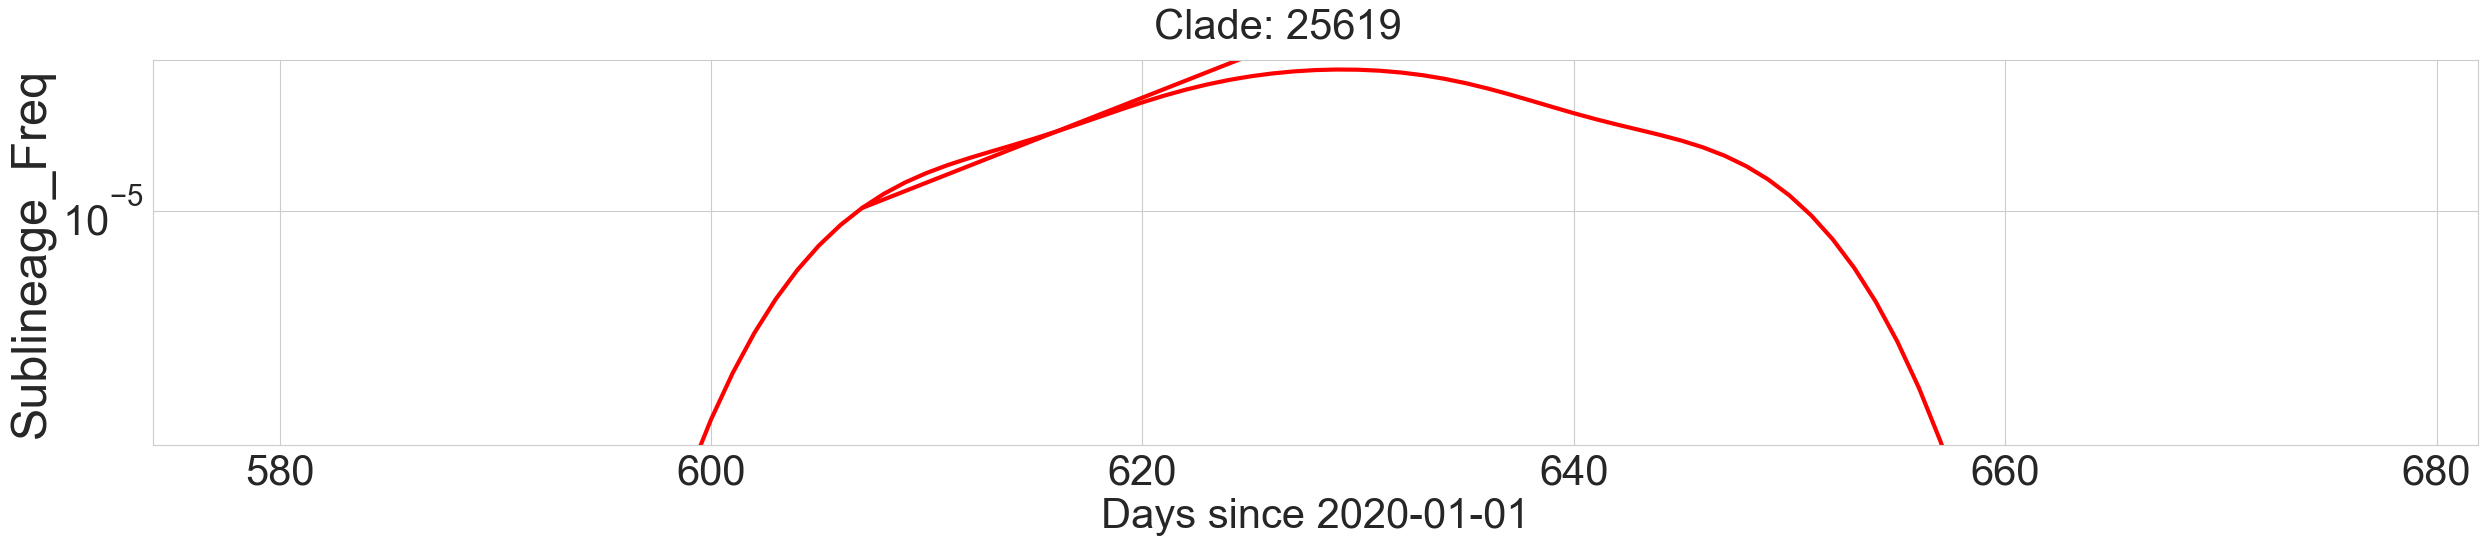

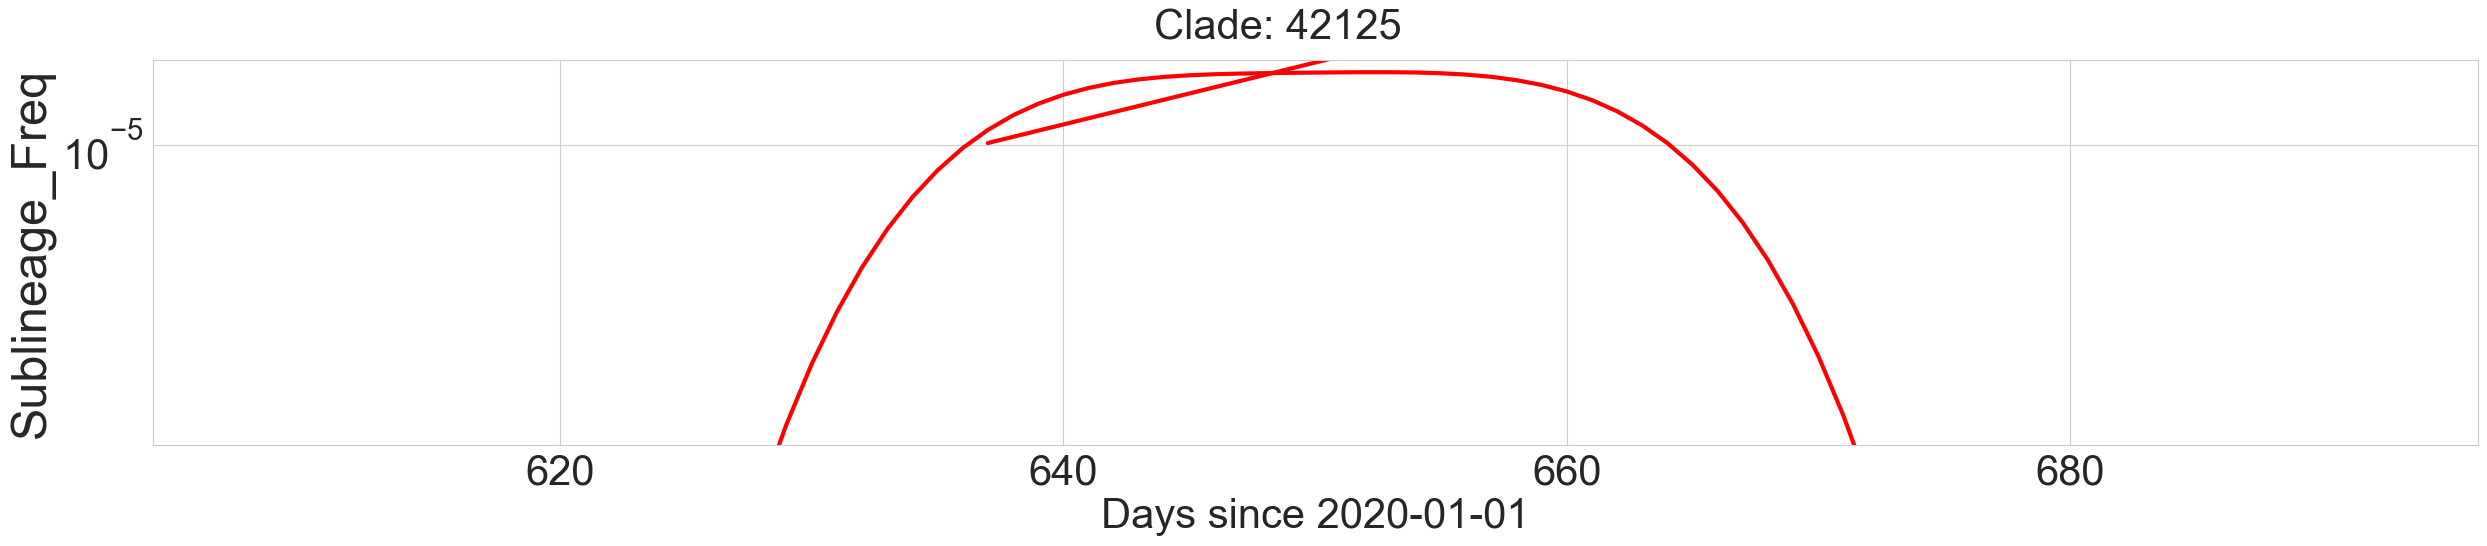

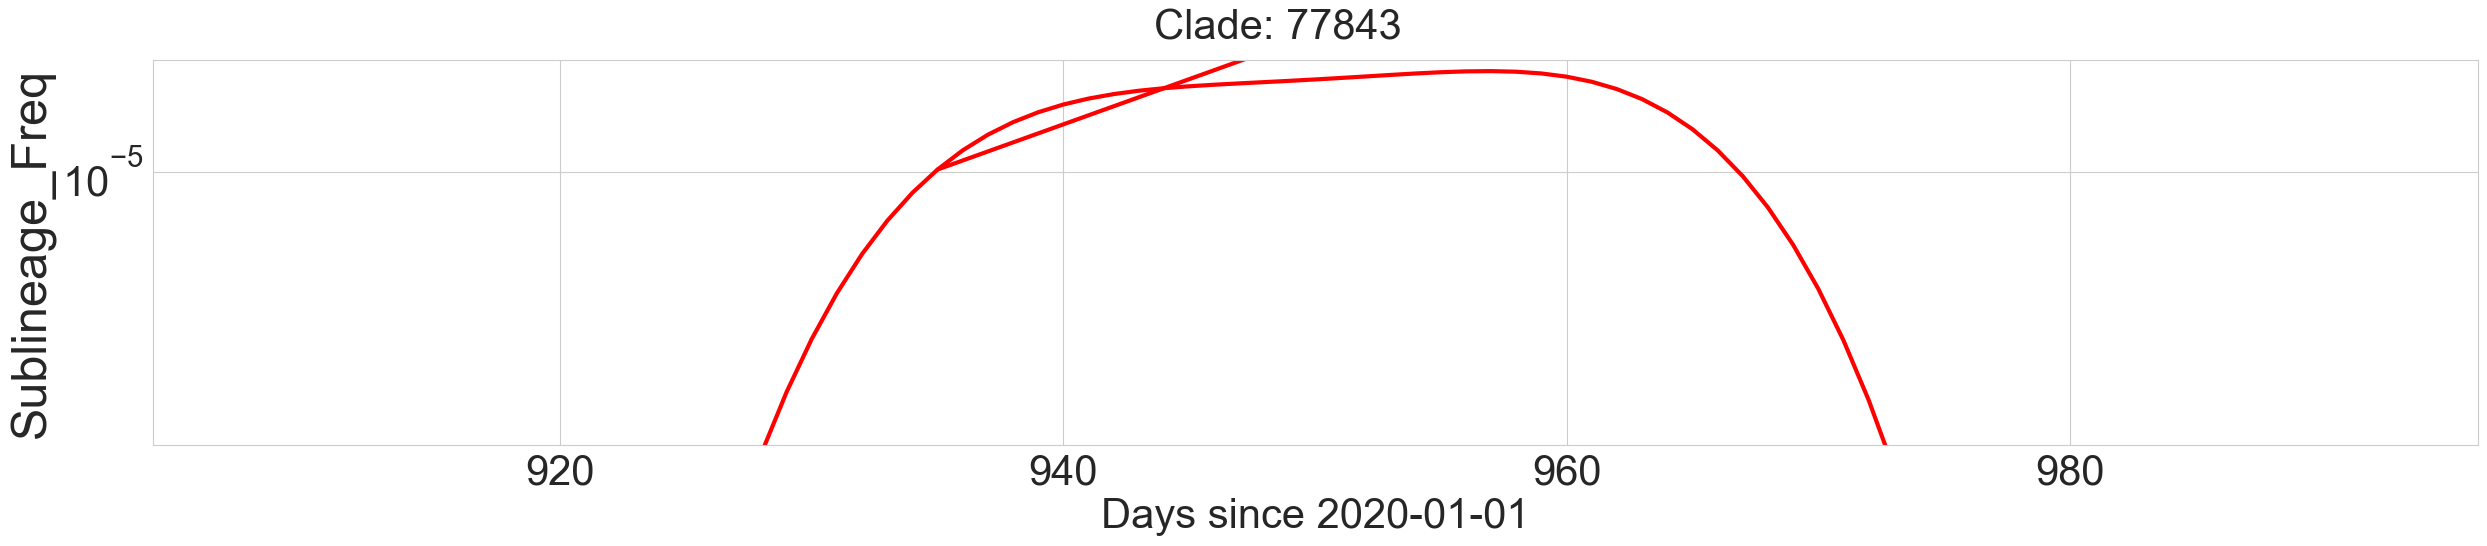

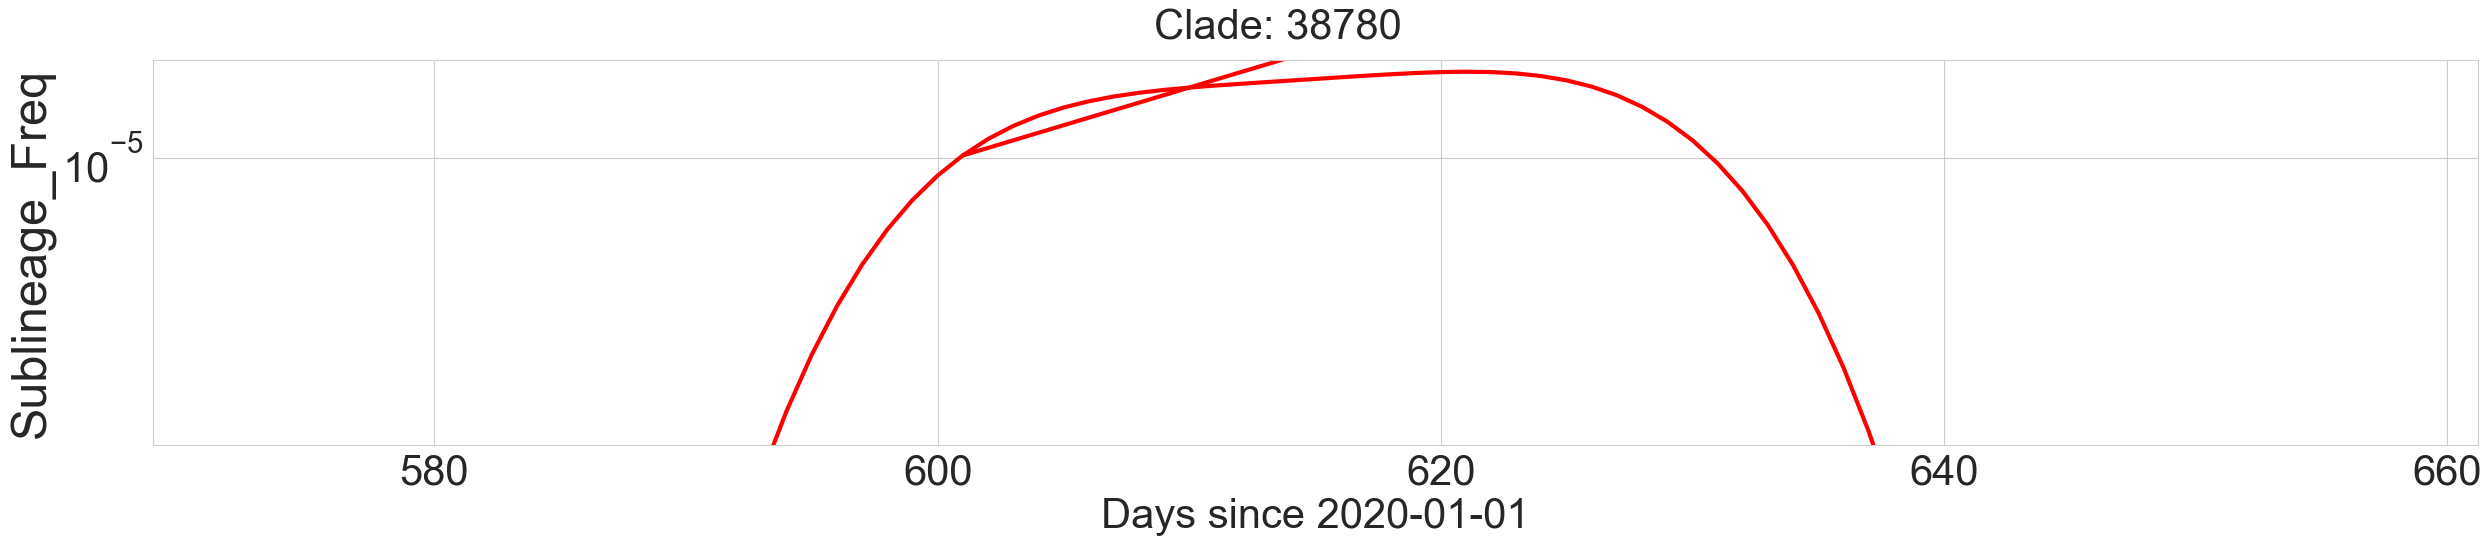

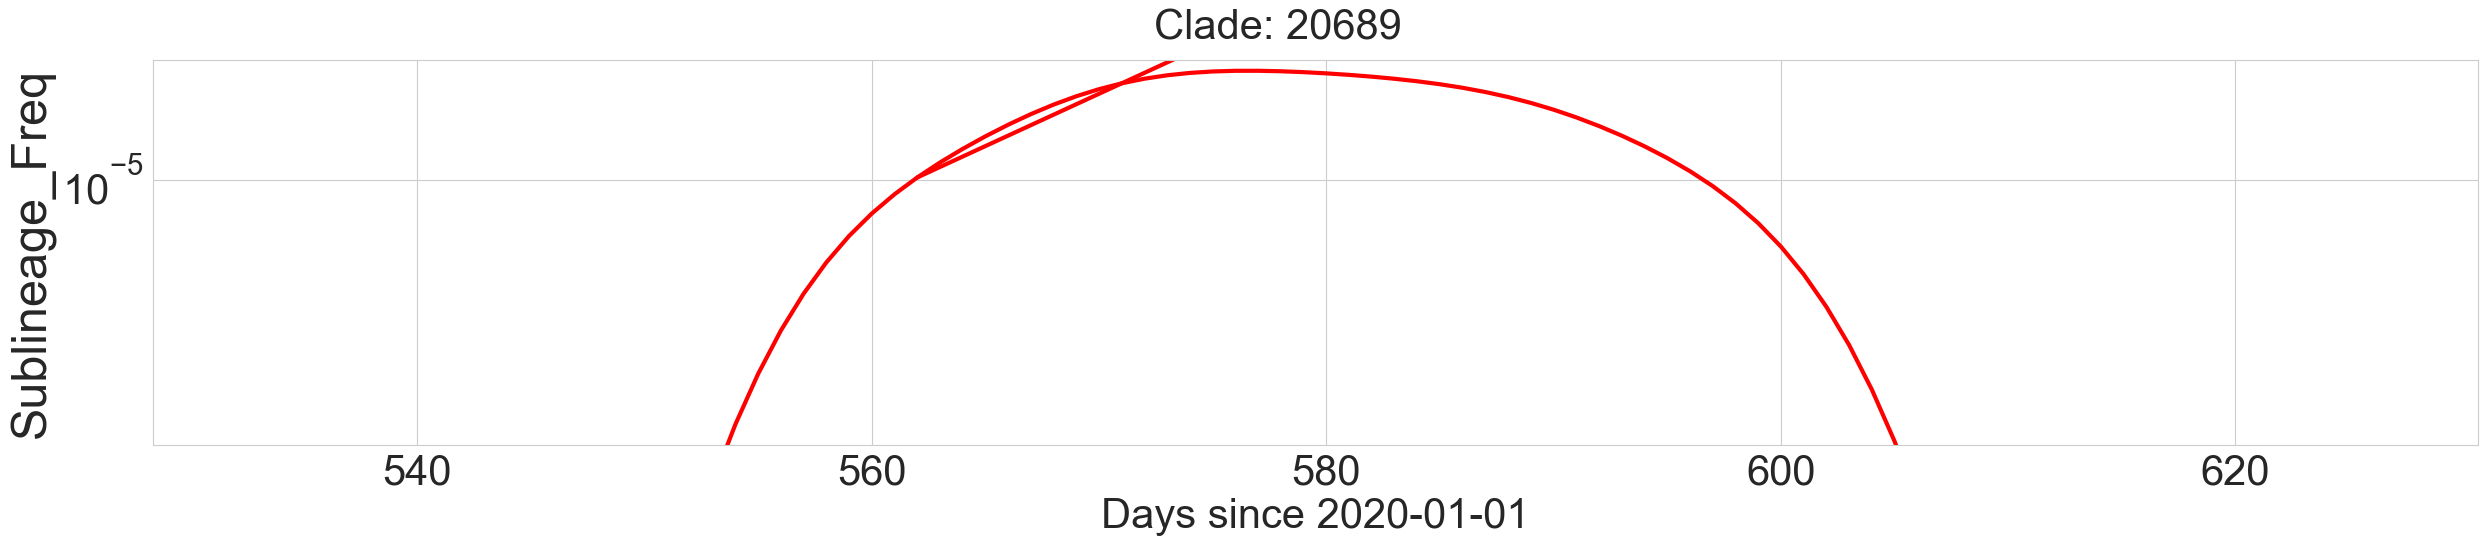

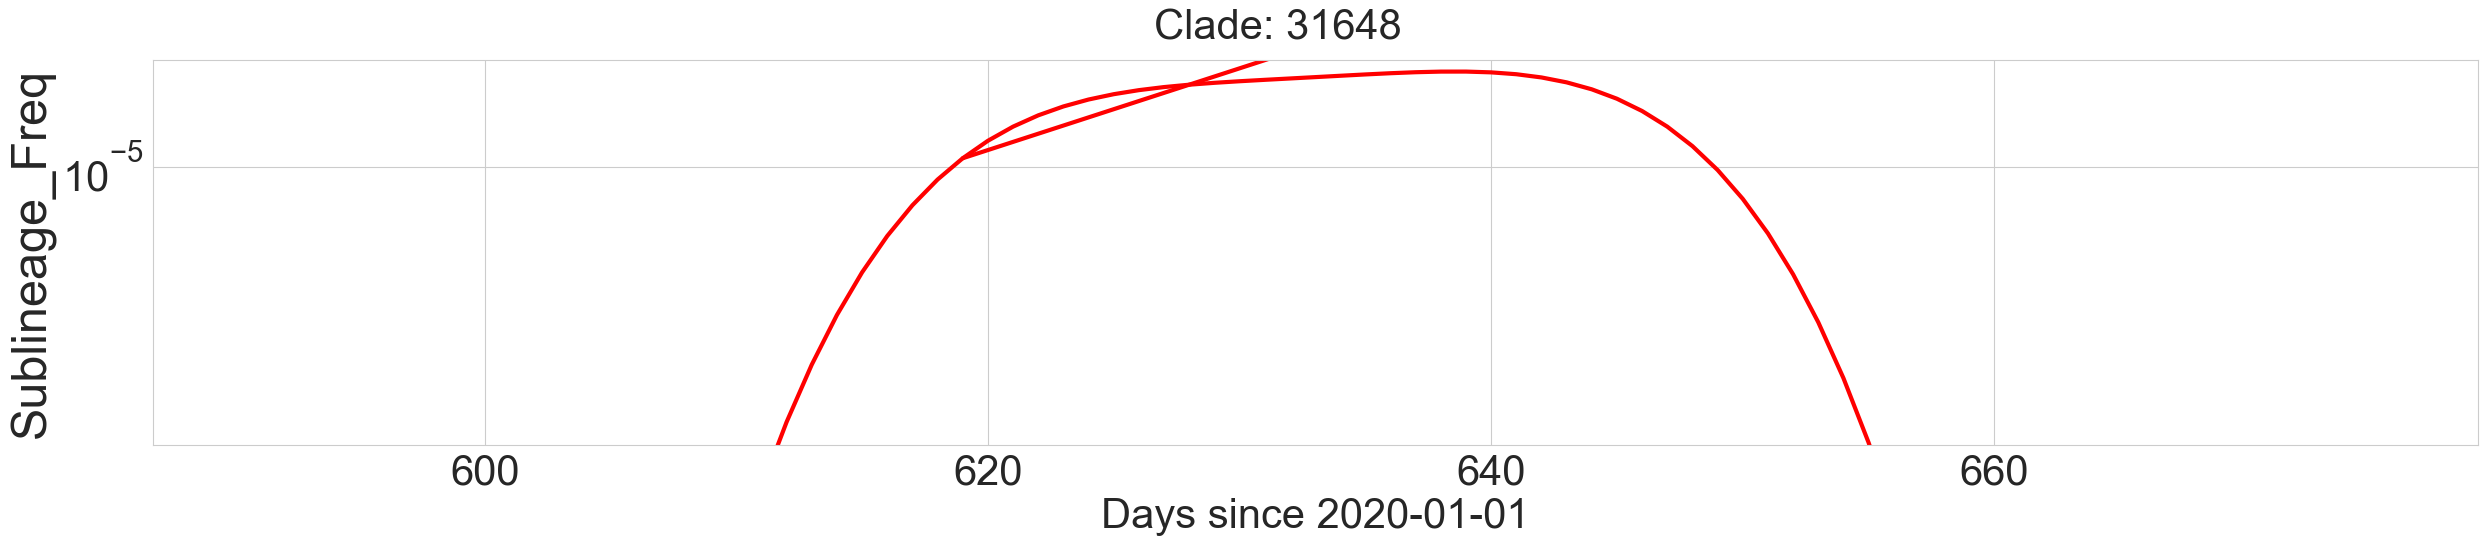

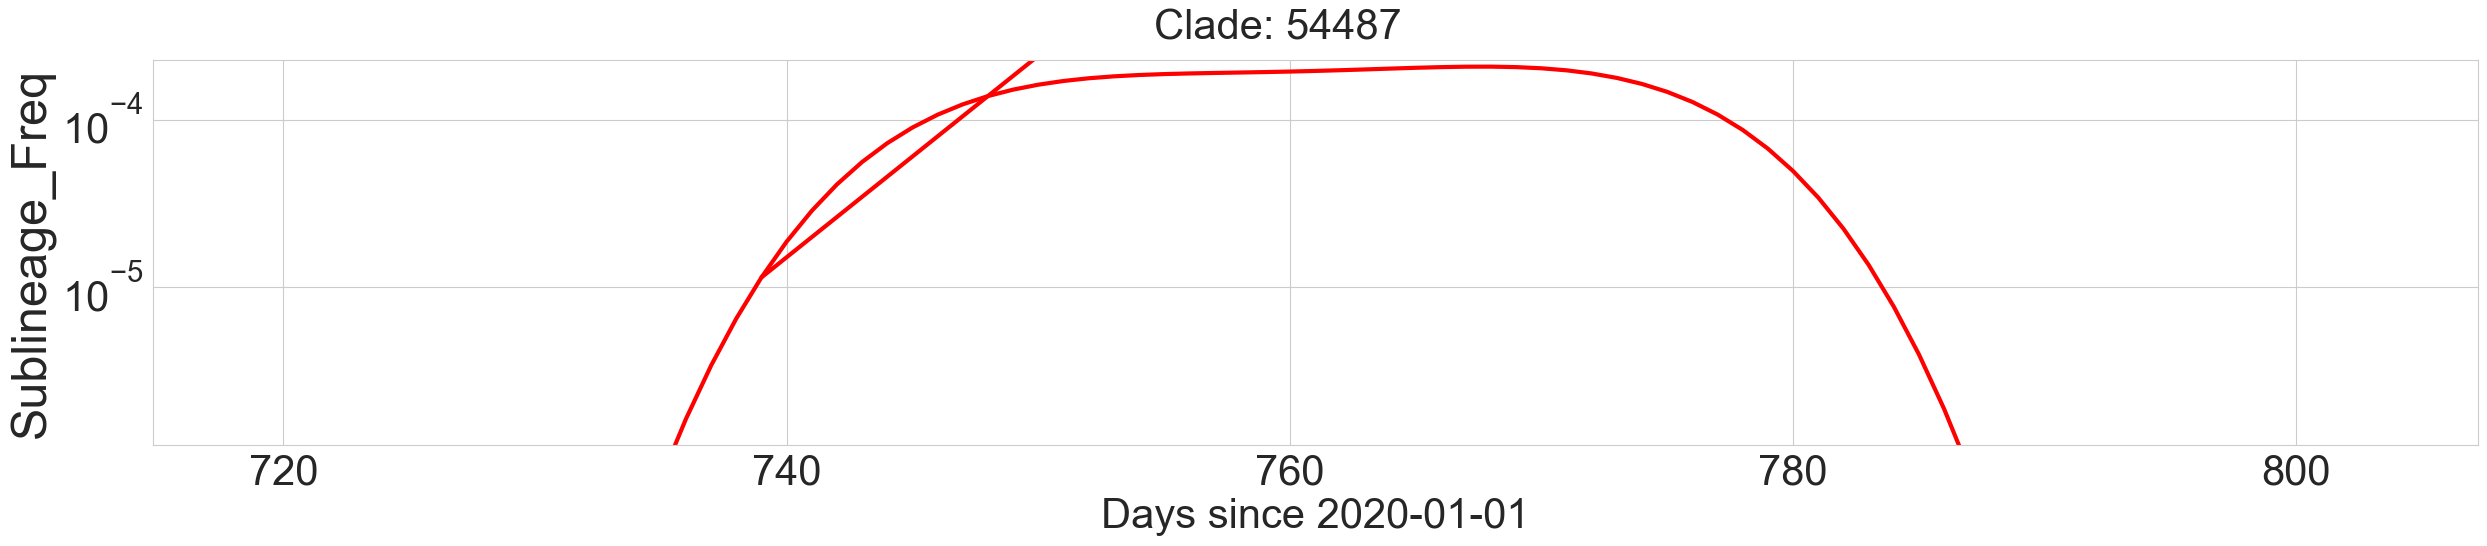

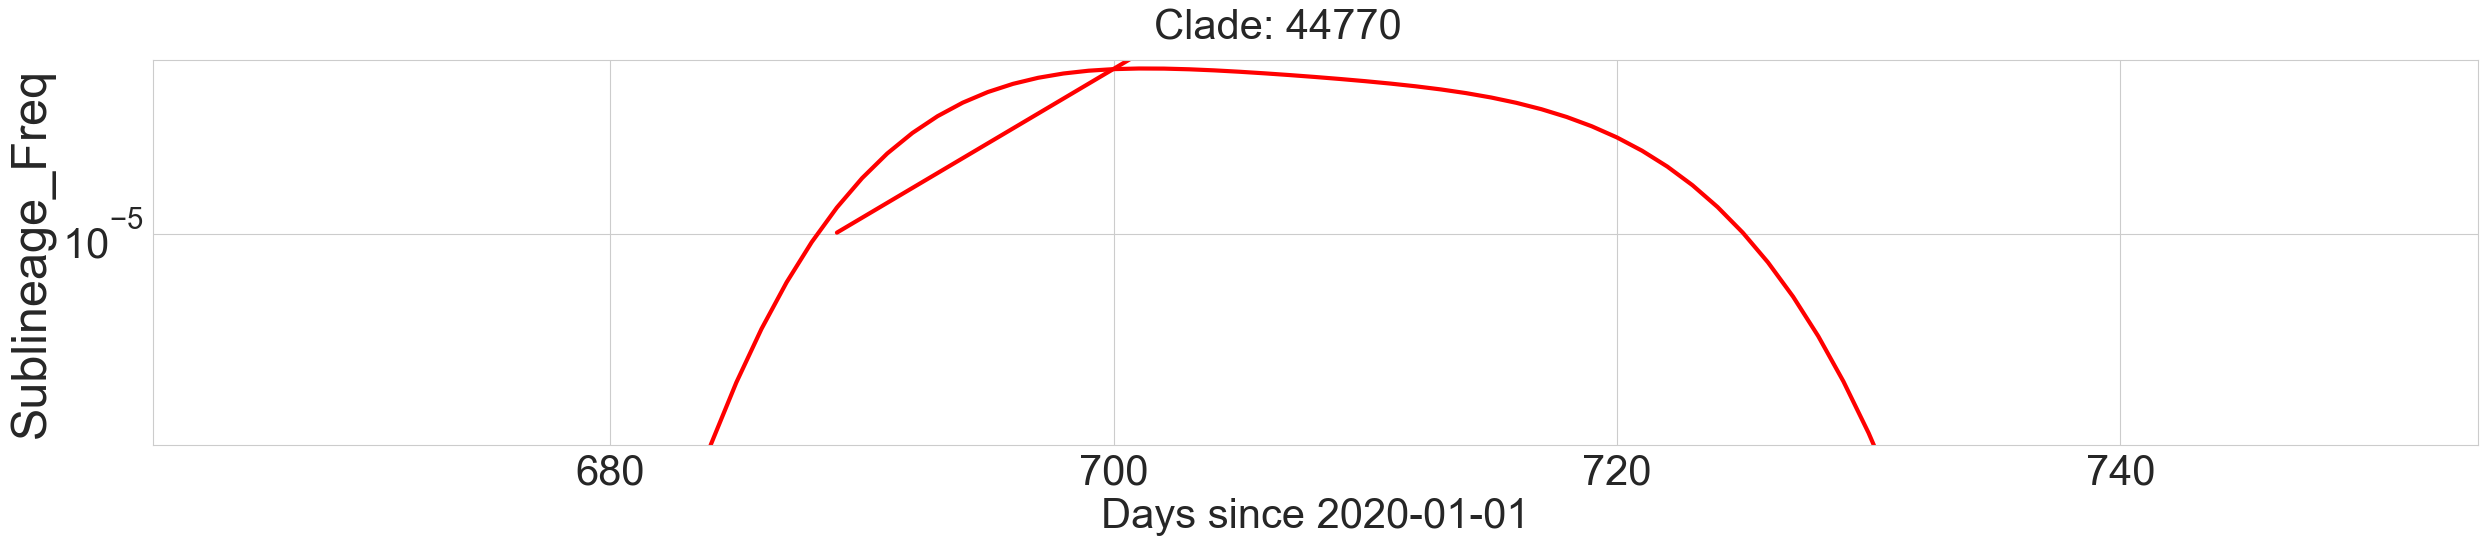

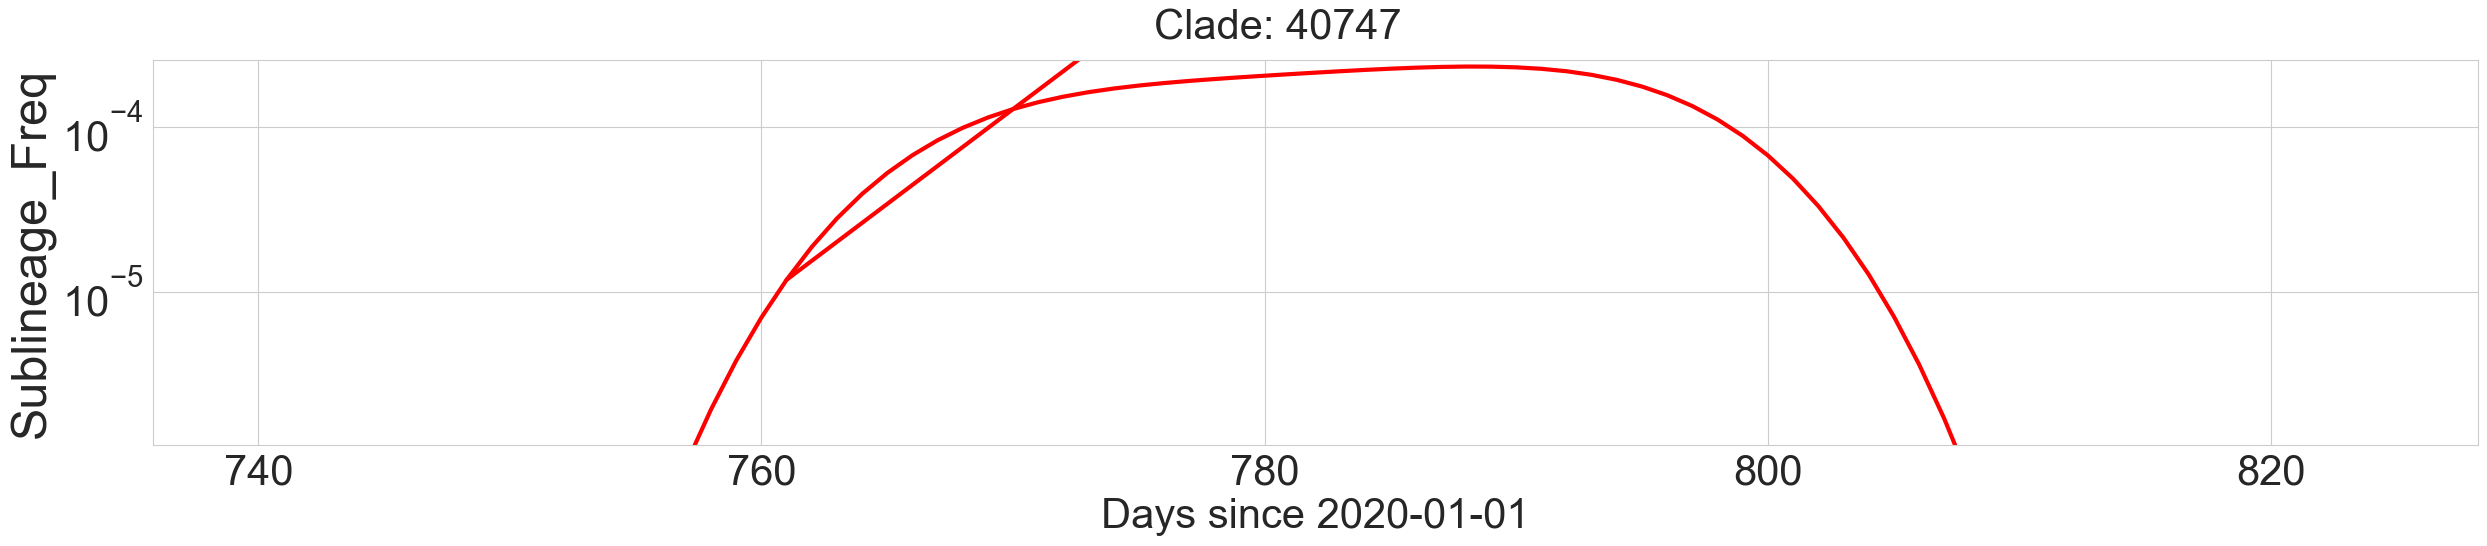

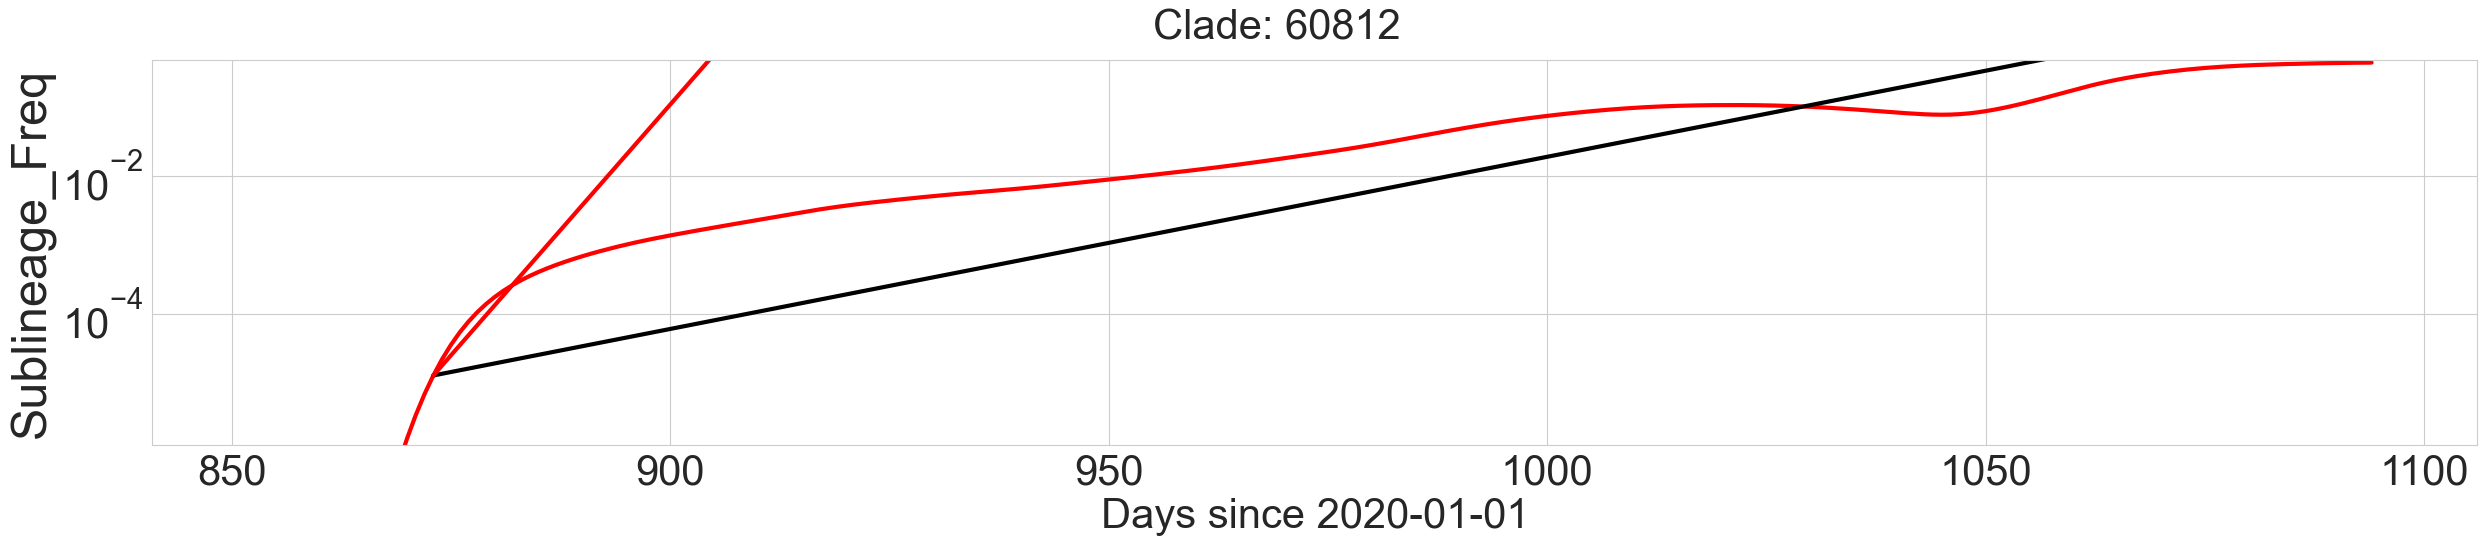

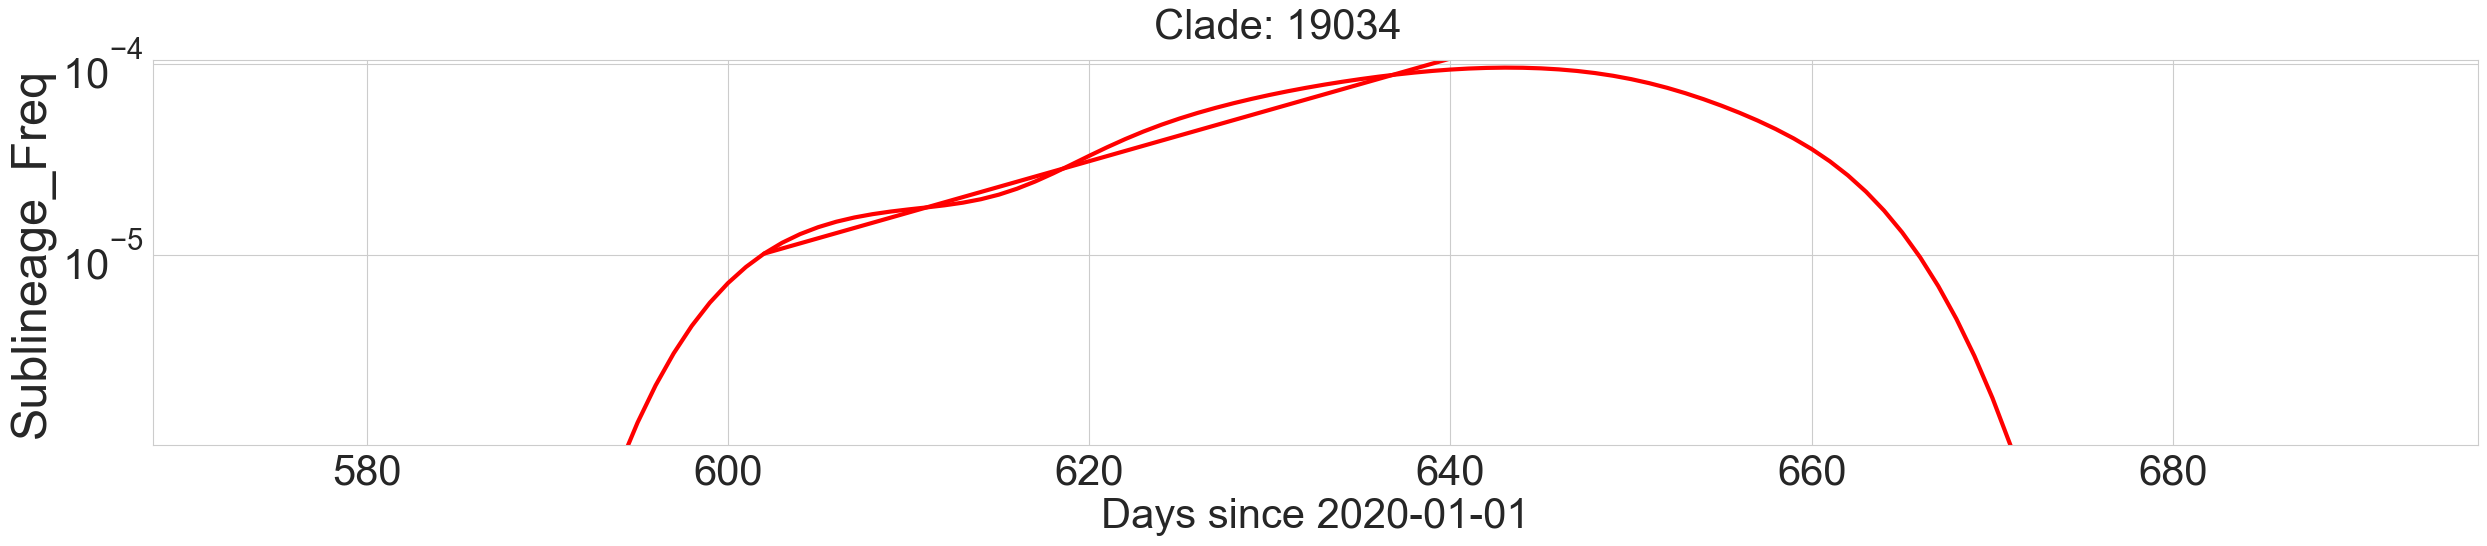

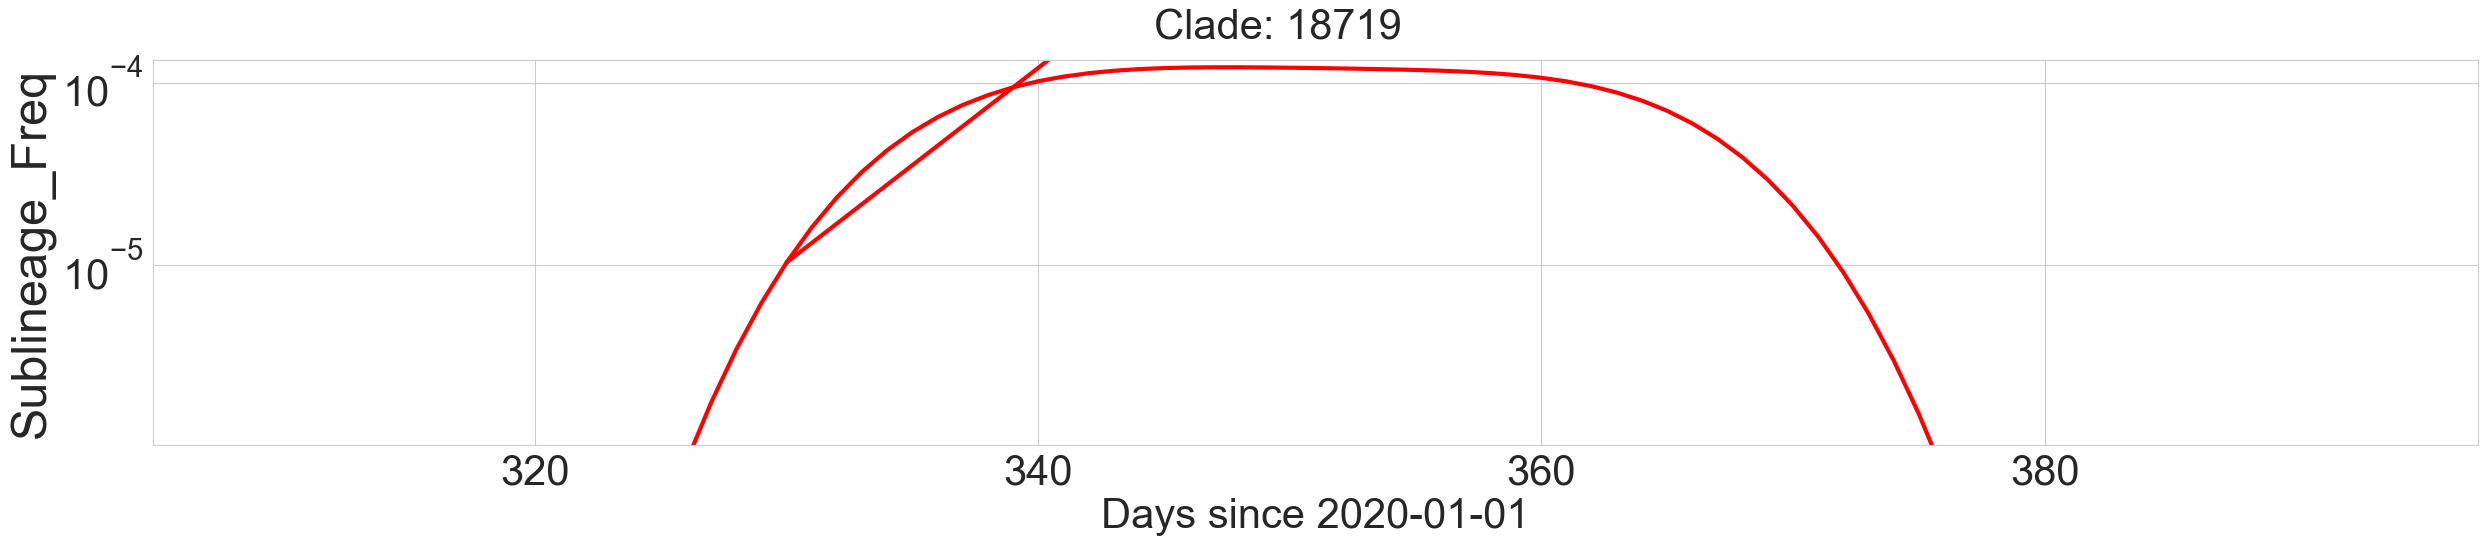

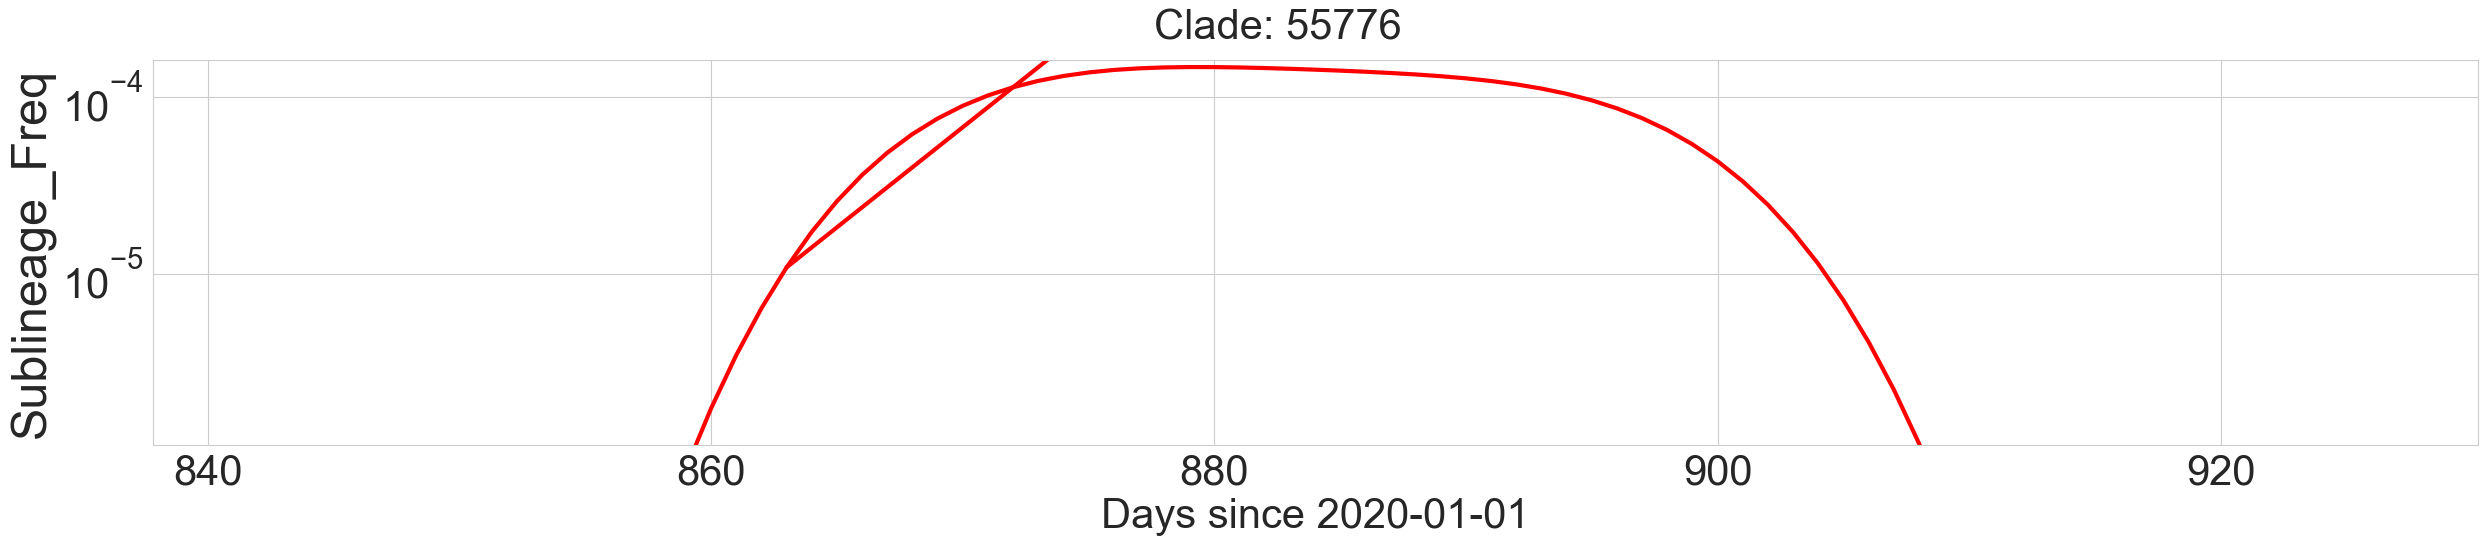

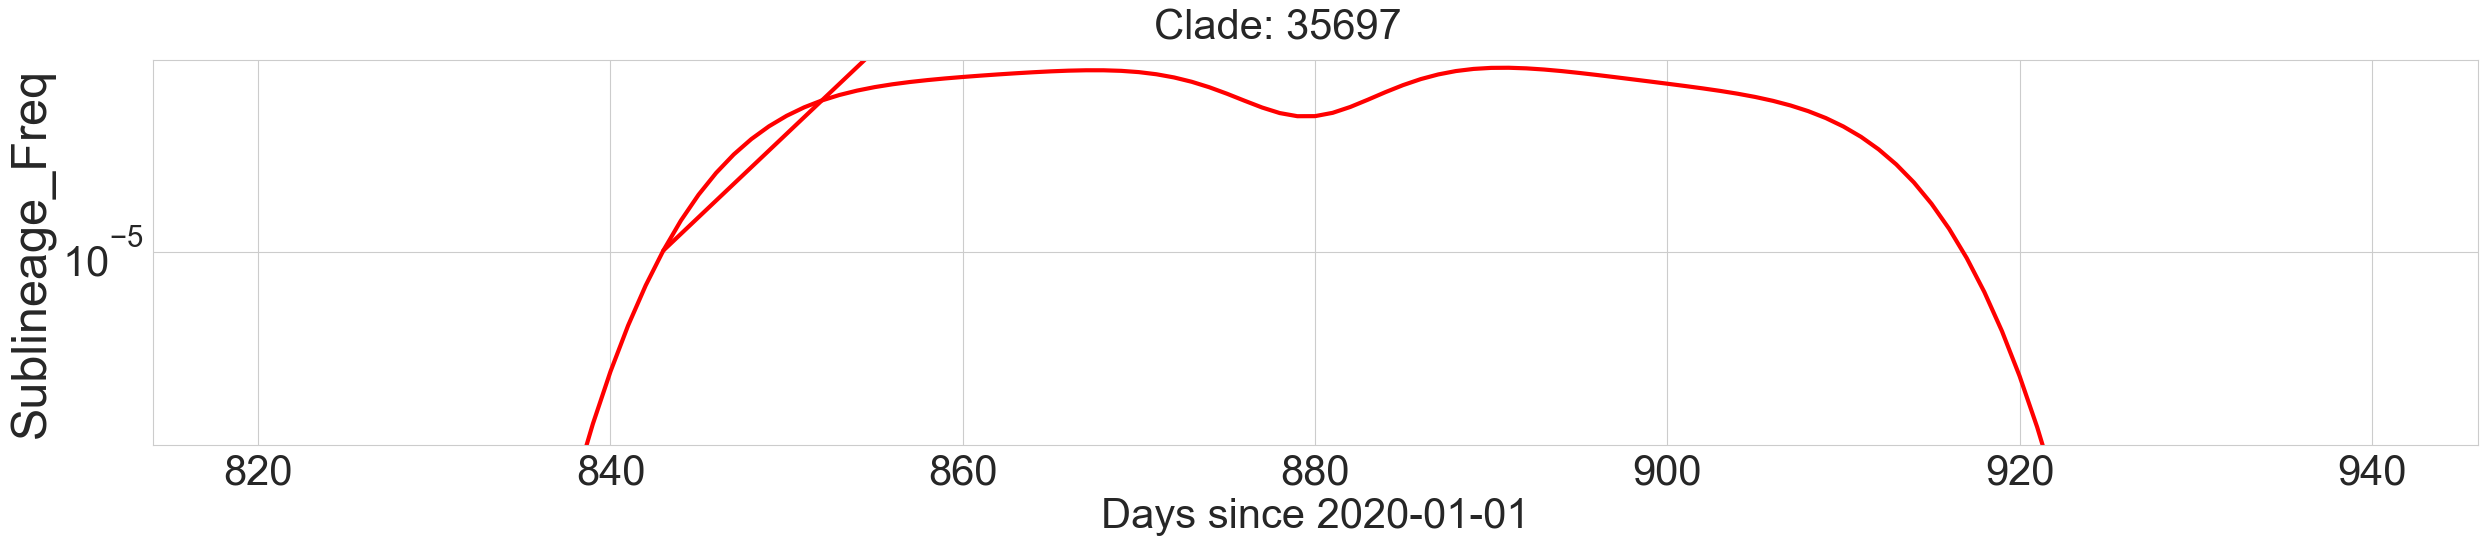

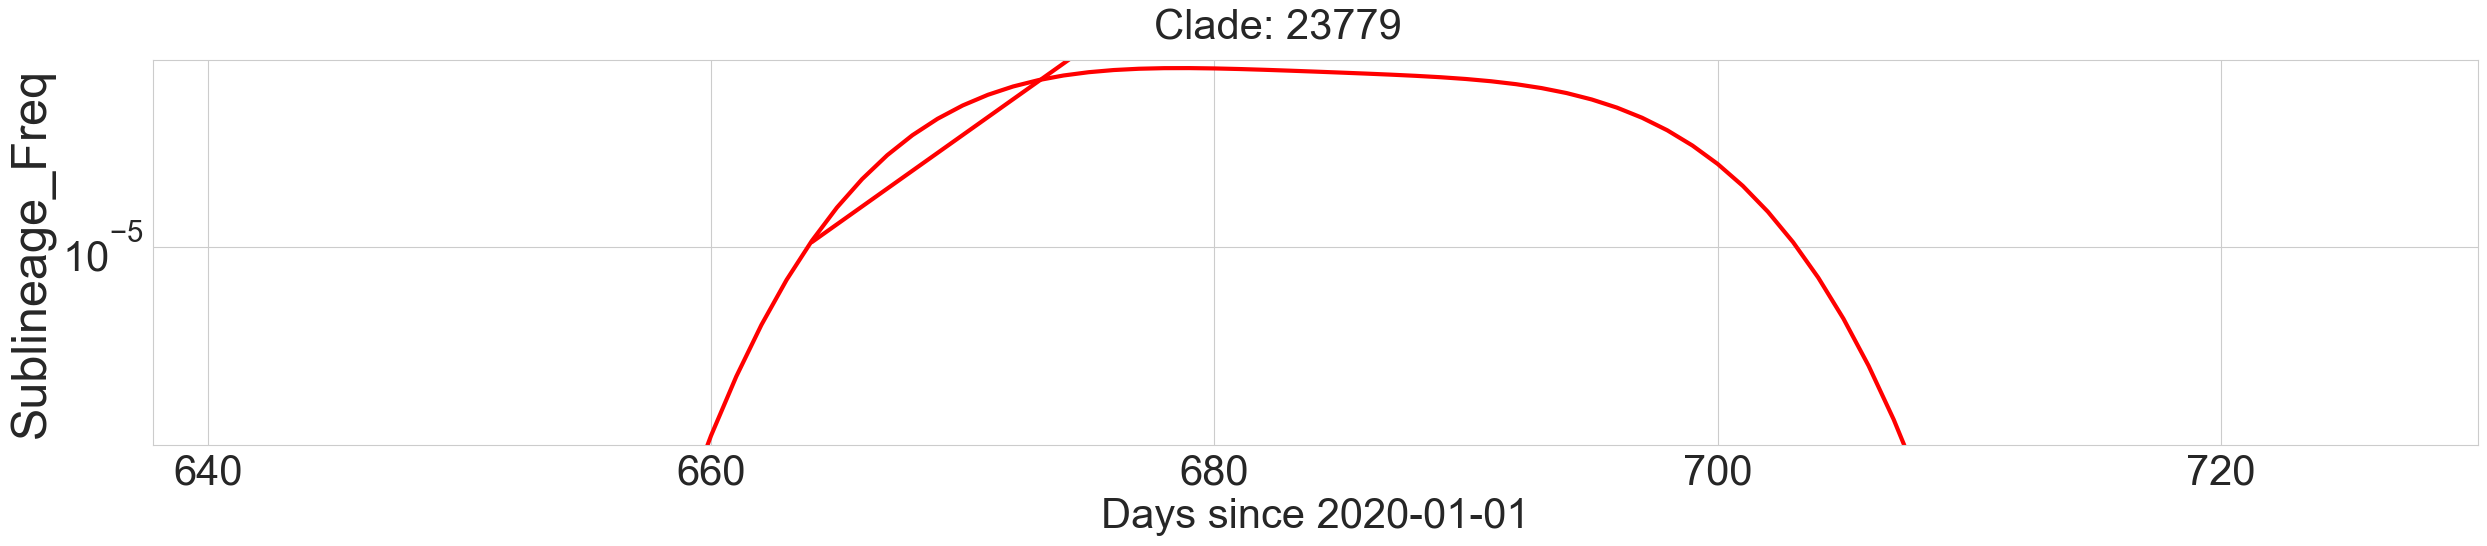

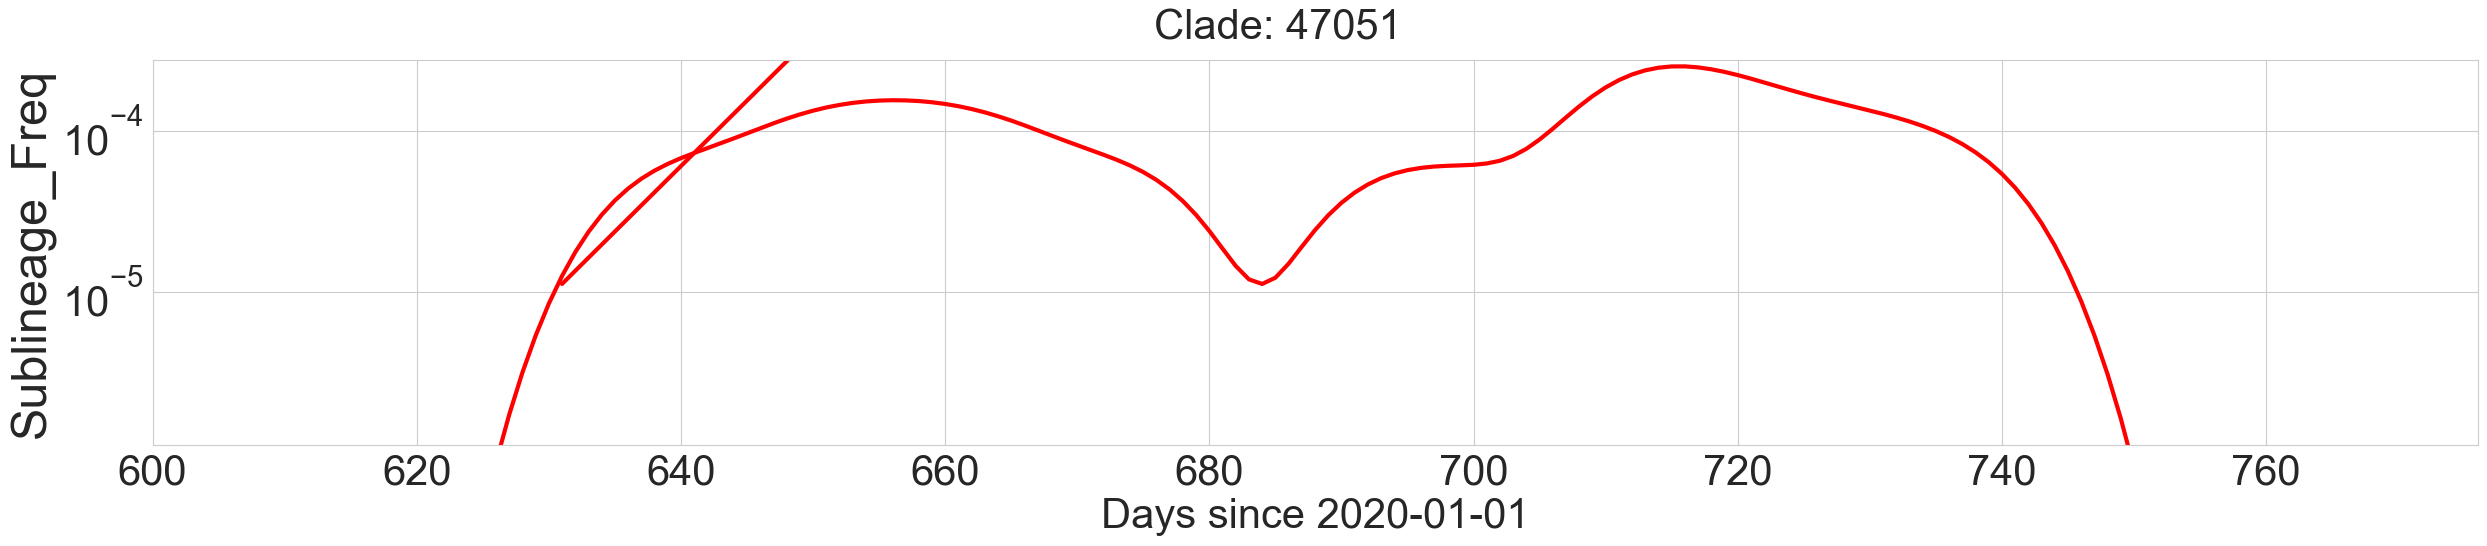

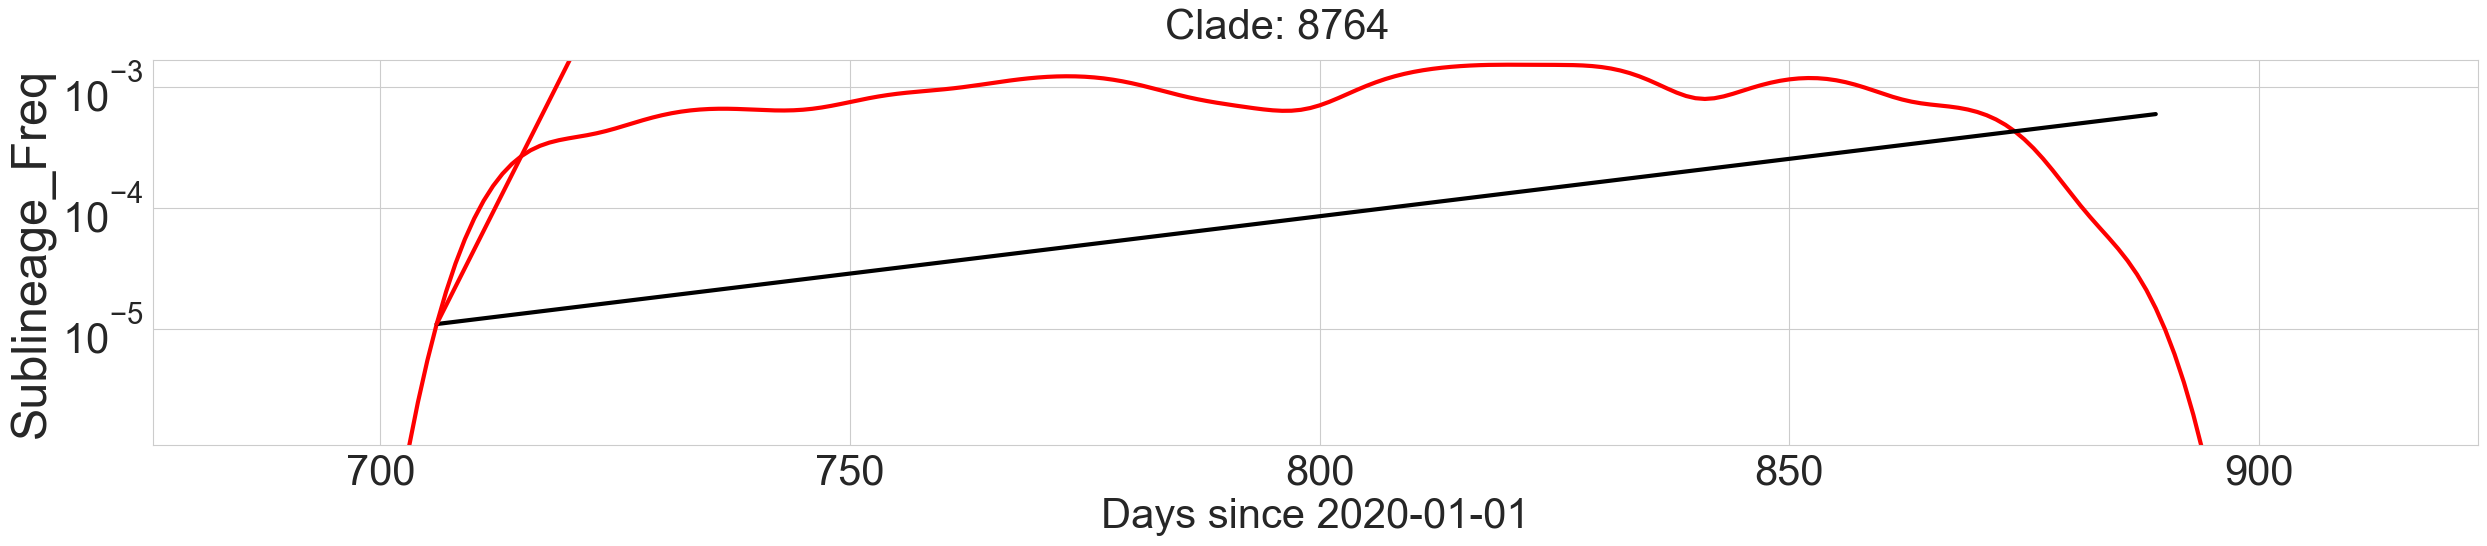

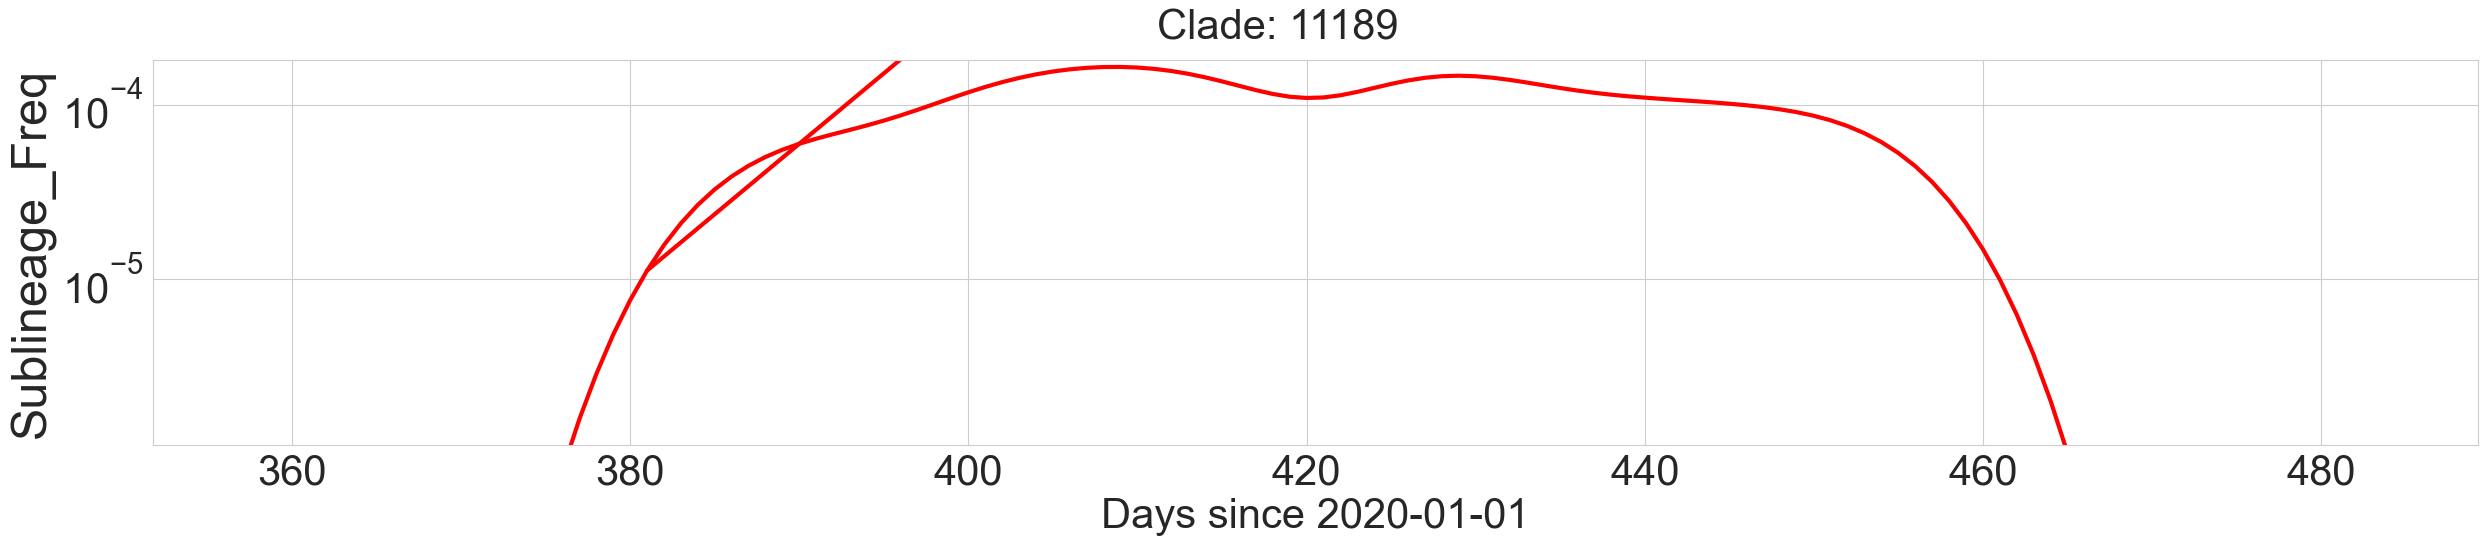

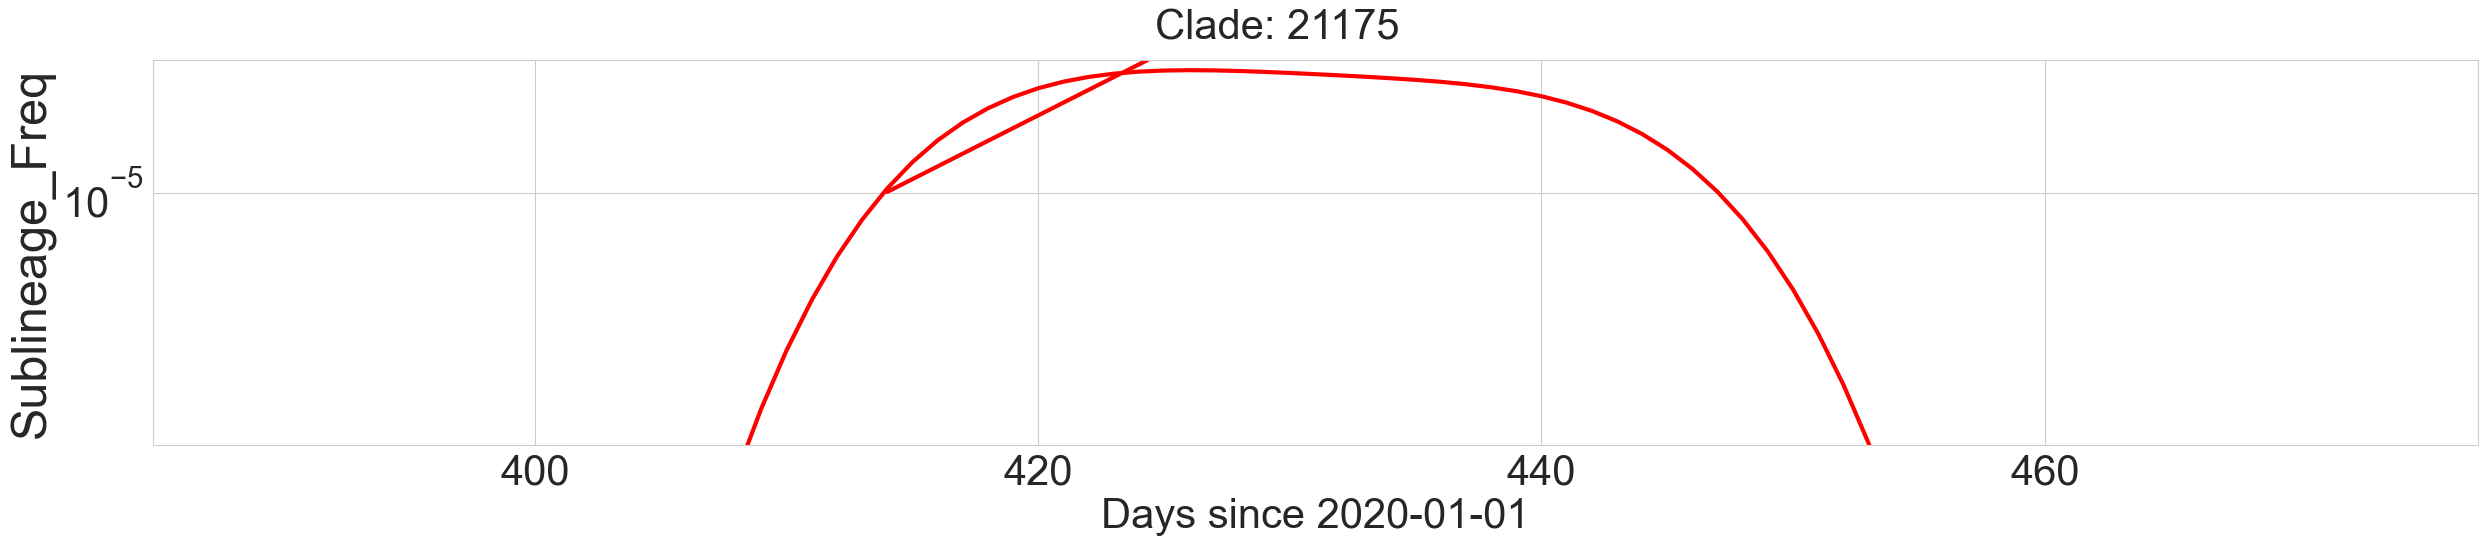

In [ ]:
for i in range(20):
    random_clade = random.choice(nonsyn_S_clade_stats['Clade'].values)

    subset = nonsyn_S_clade_statistics_SARS_CoV_2_World[nonsyn_S_clade_statistics_SARS_CoV_2_World['Clade'] == random_clade][['day_diff', 'Sublineage_Freq']].values
    # subset = subset.dropna(subset=['day_diff', 'Sublineage_Freq'])
    #sort by day_diff
    subset = subset[subset[:,0].argsort()]
    x = subset[:,0]
    y = subset[:,1]
    
    try:
        x = x[y>1e-5]
        y = y[y>1e-5] 
        
        g_rate = np.average(np.log(y[1:10] * (1-y[:9]) / (y[:9]*(1-y[1:10]))) / (x[1:10] - x[:9]))
        print(g_rate, f'lifetime: {x[-1]-x[0]}')

        fig,ax = plt.subplots(1,figsize = (30,5))
        sns.lineplot(nonsyn_S_clade_statistics_SARS_CoV_2_World.query(
            f'Clade == {random_clade}'
        ), x = 'day_diff', y = 'Sublineage_Freq',color='red',ax=ax)
        # ax.plot(x,y,marker='o',linestyle='--')

        s= nonsyn_S_clade_stats.query(f'Clade == {random_clade}')['s'].values[0]
        print(s)
        ax.plot(x[:],y.min()*np.exp(s*(x[:]-x[0])),linestyle='-',color='black')
        ax.plot(x[:],y.min()*np.exp(g_rate*(x[:]-x[0])),linestyle='-',color='red')
        ax.set_ylim(np.min(y)*.1,np.max(y)*1.1) 
        ax.set_yscale('log')

        ax.set_xlabel('Days since 2020-01-01',fontsize=30)
        fig.suptitle(f'Clade: {random_clade}',fontsize=30)
    except IndexError:
        pass

(1e-05, 0.99999)

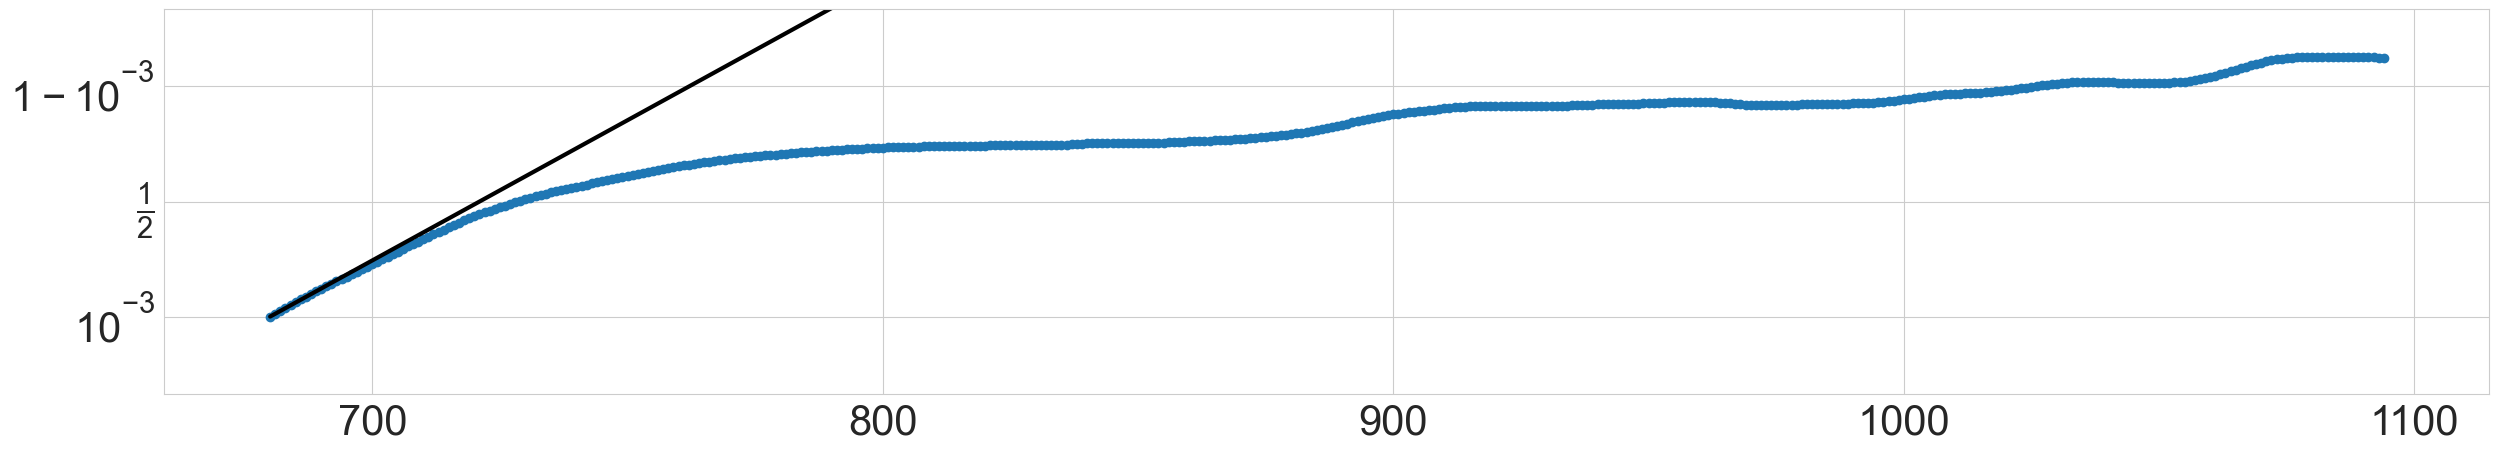

In [ ]:
random_clade = random.choice(nonsyn_RBD_clade_stats.query('Max_Freq > .9')['Clade'].values)

subset = nonsyn_RBD_clade_statistics_SARS_CoV_2_World[nonsyn_RBD_clade_statistics_SARS_CoV_2_World['Clade'] == random_clade][['day_diff', 'Sublineage_Freq']].values
# subset = subset.dropna(subset=['day_diff', 'Sublineage_Freq'])
#sort by day_diff
subset = subset[subset[:,0].argsort()]
x = subset[:,0]
y = subset[:,1]
x = x[y>1e-3]
y = y[y>1e-3]
s= nonsyn_RBD_clade_stats.query(f'Clade == {random_clade}')['s'].values[0]
fig,ax = plt.subplots(1,figsize = (30,5))
ax.plot(x,y,marker='o',linestyle='--')
ax.plot(x,y.min()*np.exp(s*(x-x[0]))/(1 +y.min()*np.exp(s*(x-x[0]))),linestyle='-',color='black')
ax.set_yscale('logit')
ax.set_ylim(1e-5,1-1e-5)

In [ ]:
y[0]*np.exp(s*x[1:])

array([4.27068654e+46, 5.05068143e+46, 5.97313398e+46, 7.06406255e+46,
       8.35423747e+46, 9.88004894e+46, 1.16845334e+47, 1.38185876e+47,
       1.63424037e+47, 1.93271677e+47, 2.28570667e+47, 2.70316636e+47,
       3.19687058e+47, 3.78074455e+47, 4.47125681e+47, 5.28788369e+47,
       6.25365868e+47, 7.39582206e+47, 8.74658928e+47, 1.03440596e+48,
       1.22332906e+48, 1.44675694e+48, 1.71099150e+48, 2.02348567e+48,
       2.39305353e+48, 2.83011897e+48, 3.34700971e+48, 3.95830497e+48,
       4.68124673e+48, 5.53622601e+48, 6.54735805e+48, 7.74316246e+48,
       9.15736766e+48, 1.08298622e+49, 1.28078199e+49, 1.51470302e+49,
       1.79134721e+49, 2.11851747e+49, 2.50544187e+49, 2.96303383e+49,
       3.50420004e+49, 4.14420442e+49, 4.90109871e+49, 5.79623159e+49,
       6.85485084e+49, 8.10681550e+49, 9.58743801e+49, 1.13384803e+50,
       1.34093315e+50, 1.58584015e+50, 1.87547677e+50, 2.21801239e+50,
       2.62310846e+50, 3.10219096e+50, 3.66877271e+50, 4.33883453e+50,
      

In [ ]:
average_infected_size = covid_data_World['weekly_new_cases_smoothed'].mean()
average_s = nonsyn_S_clade_stats.query('day_diff < 400')['s_w'].mean()

print(f'N = {average_infected_size:.1e}, s = {average_s:.1e}, Ns = {average_infected_size*average_s:.1e}')

N = 4.5e+06, s = 4.4e-01, Ns = 2.0e+06


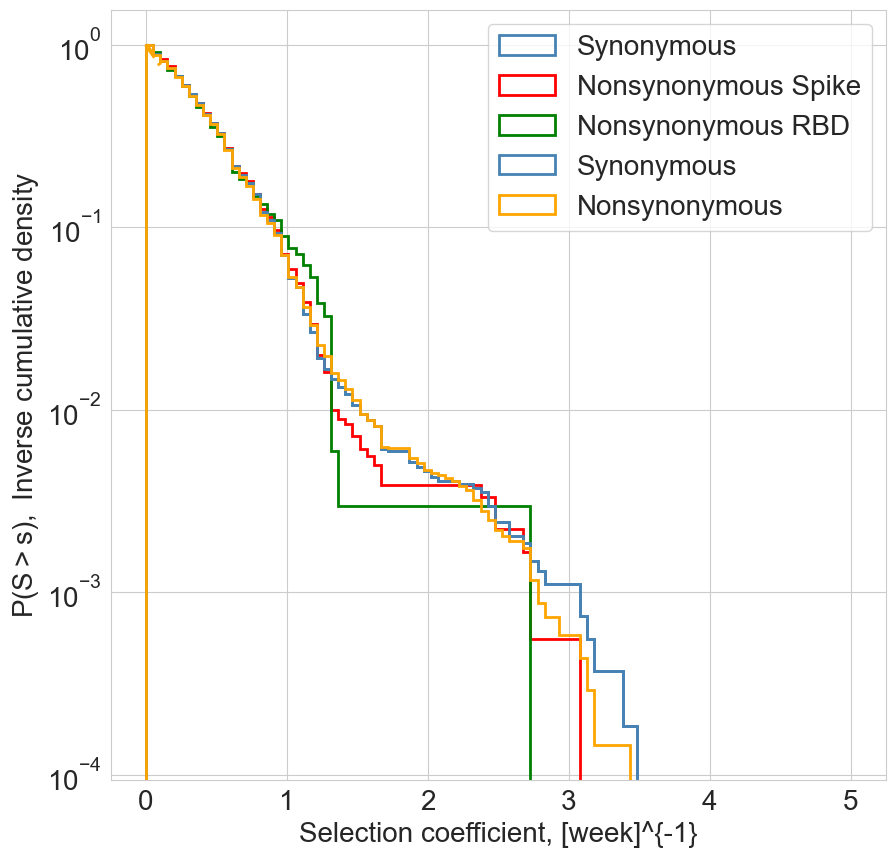

In [ ]:
syn_clade_stats['s_w'] = syn_clade_stats['selection']*7
nonsyn_all_clade_stats['s_w'] = nonsyn_all_clade_stats['s']*7
bins = np.linspace(0,5,100)
fig,ax= plt.subplots(1,figsize = (10,10))
plt.hist(syn_clade_stats['s_w'].values[~np.isnan(syn_clade_stats['s_w'])],bins = bins,density= True, label = 'Synonymous',color='steelblue',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])],bins = bins,density= True, label = 'Nonsynonymous Spike',color='red',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(nonsyn_RBD_clade_stats['s_w'].values[~np.isnan(nonsyn_RBD_clade_stats['s_w'])],bins = bins,density= True, label = 'Nonsynonymous RBD',color='green',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(syn_clade_stats['s_w'].values[~np.isnan(syn_clade_stats['s_w'])],bins = bins,density= True, label = 'Synonymous',color='steelblue',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

plt.hist(nonsyn_all_clade_stats['s_w'].values[~np.isnan(nonsyn_all_clade_stats['s_w'])],bins = bins,density= True, label = 'Nonsynonymous',color='orange',alpha=1,fill=False,cumulative=-1, histtype = 'step',lw = 2);

# ax.set_xlim(left=.39,right=.6)
ax.set_yscale('log')
ax.legend(loc='best',fontsize=20)

sarr = np.linspace(0,.1,100)
ax.plot(sarr, np.exp(- sarr/np.average(nonsyn_S_clade_stats['s_w'].values[~np.isnan(nonsyn_S_clade_stats['s_w'])]) )
,linestyle='--',color='orange')

ax.set_xlabel('Selection coefficient, [week]^{-1}',fontsize=20)
ax.set_ylabel(r'$P(S>s),$ Inverse cumulative density',fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)

In [ ]:
reference_date

Timestamp('2020-01-01 00:00:00')

In [ ]:
reference_date = pd.to_datetime('2020-01-01')
syn_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(syn_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_all_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_all_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days
nonsyn_S_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(nonsyn_S_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

def initial_growth(clade,df):
    x = np.sort(df.query(f'Clade=={clade}')['day_diff'].values)
    y = np.sort(df.query(f'Clade=={clade}')['Sublineage_Freq'].values)
    g_rate = np.average(np.log(y[1:10]/y[:9])/(x[1:10]-x[:9]))
    return g_rate

0.00032901763916015625
5.4836273193359375e-05


(1e-19, 1)

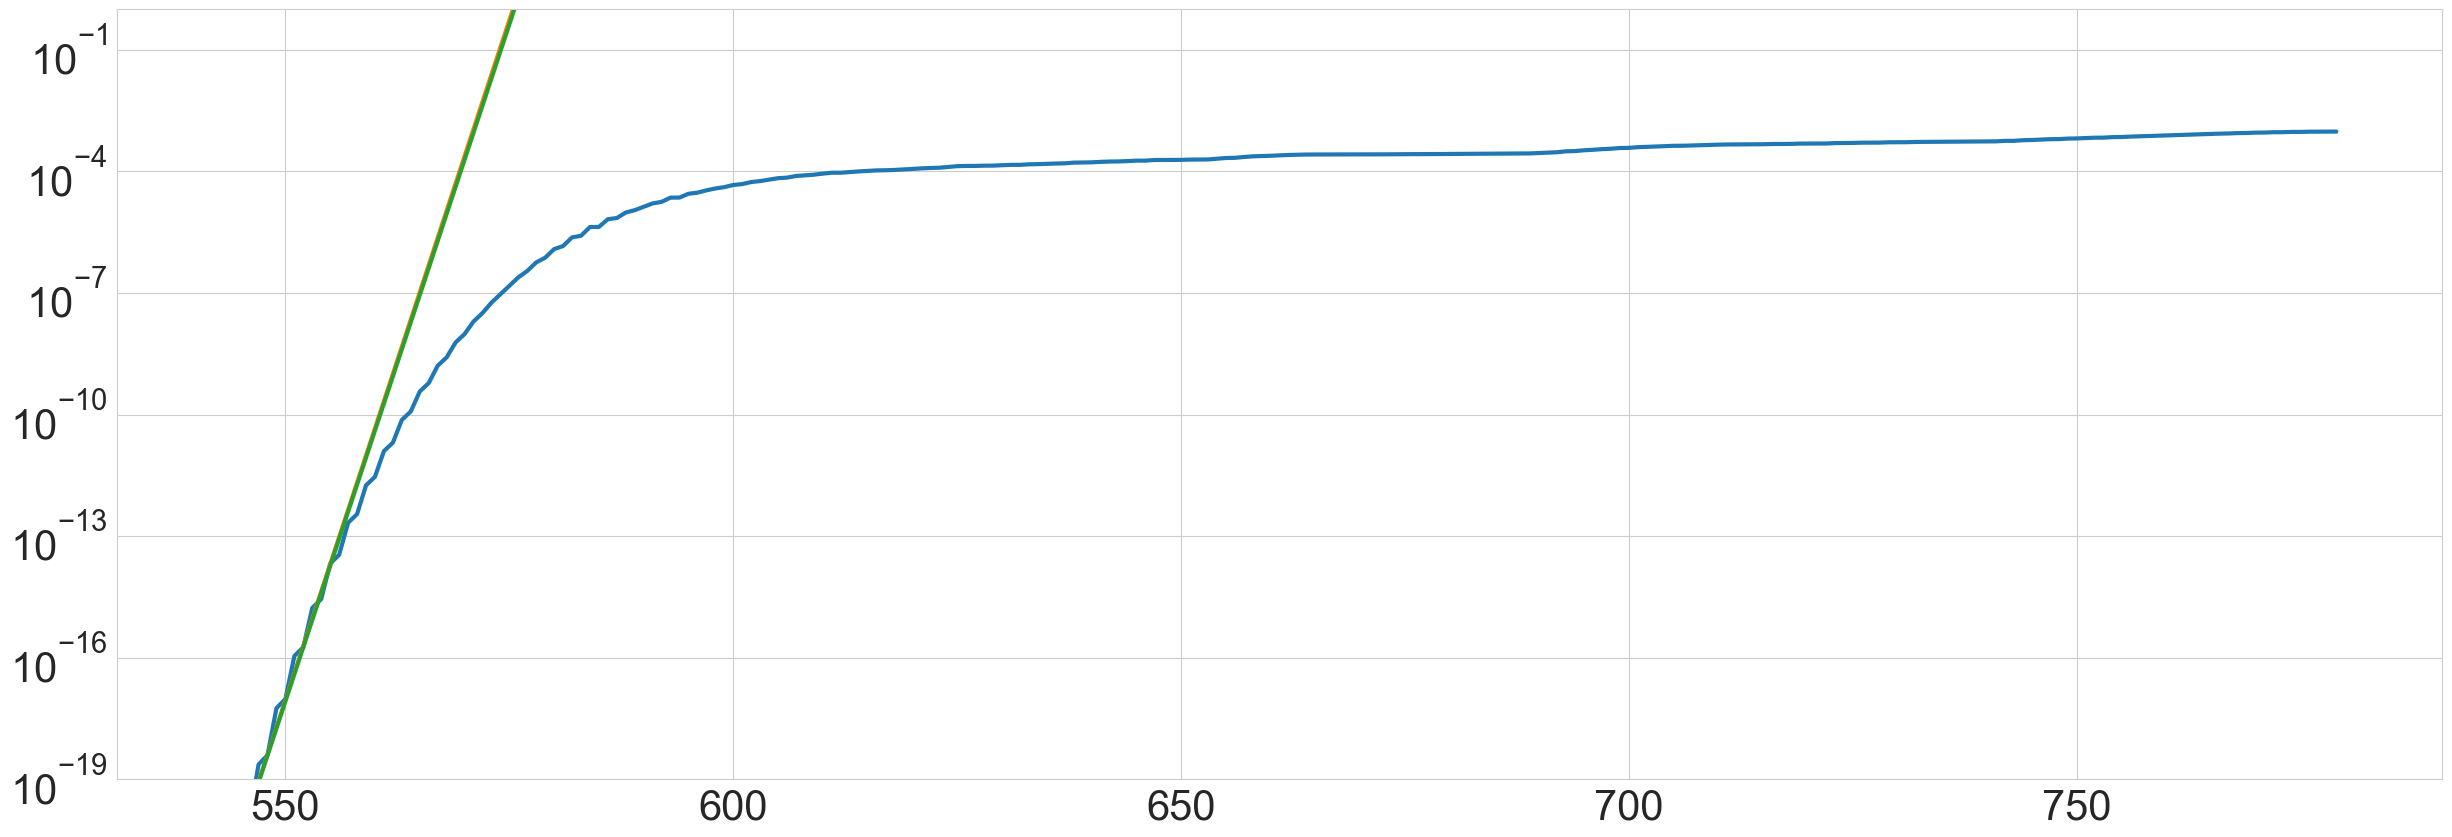

In [ ]:
randind = rnd.randint(0,len(syn_clade_stats))
clade = syn_clade_stats.iloc[randind]['Clade']
x = np.sort(syn_clade_statistics_SARS_CoV_2_World.query(f'Clade=={clade}')['day_diff'].values)
y = np.sort(syn_clade_statistics_SARS_CoV_2_World.query(f'Clade=={clade}')['Sublineage_Freq'].values)

fitfunc = lambda x,b: np.exp(b*x)
from time import time
t0 = time()
popt, pcov = so.curve_fit(fitfunc, x[:10]-x[0],y[:10]/y[0])
b = popt
print(time()-t0)
t1 = time()
g_rate = np.average(np.log(y[1:10]/y[:9])/(x[1:10]-x[:9]))
print(time()-t1)
fig,ax = plt.subplots(1,figsize = (30,10))
plt.plot(x,y)
ax.plot(x,y[0]*fitfunc(x-x[0],b))
ax.plot(x,y[0]*np.exp(g_rate*(x-x[0])))
ax.set_yscale('log')
ax.set_ylim(1e-19,1)


In [ ]:
colors_xmin = dict(zip(xmin_vals, sns.color_palette('viridis',len(xmin_vals))))

In [ ]:
wt_alpha_crossover_date = pd.to_datetime('2021-03-15')
alpha_delta_crossover_date = pd.to_datetime('2021-06-21')
delta_ba1_crossover_date = pd.to_datetime('2022-01-03')
ba1_ba2_crossover_date = pd.to_datetime('2022-01-31')
ba2_ba5_crossover_date = pd.to_datetime('2022-06-06')
ba5_xbb_crossover_date = pd.to_datetime('2023-02-27')

In [ ]:
xmin_vals =[0]+ list(np.logspace(-7,0,20))

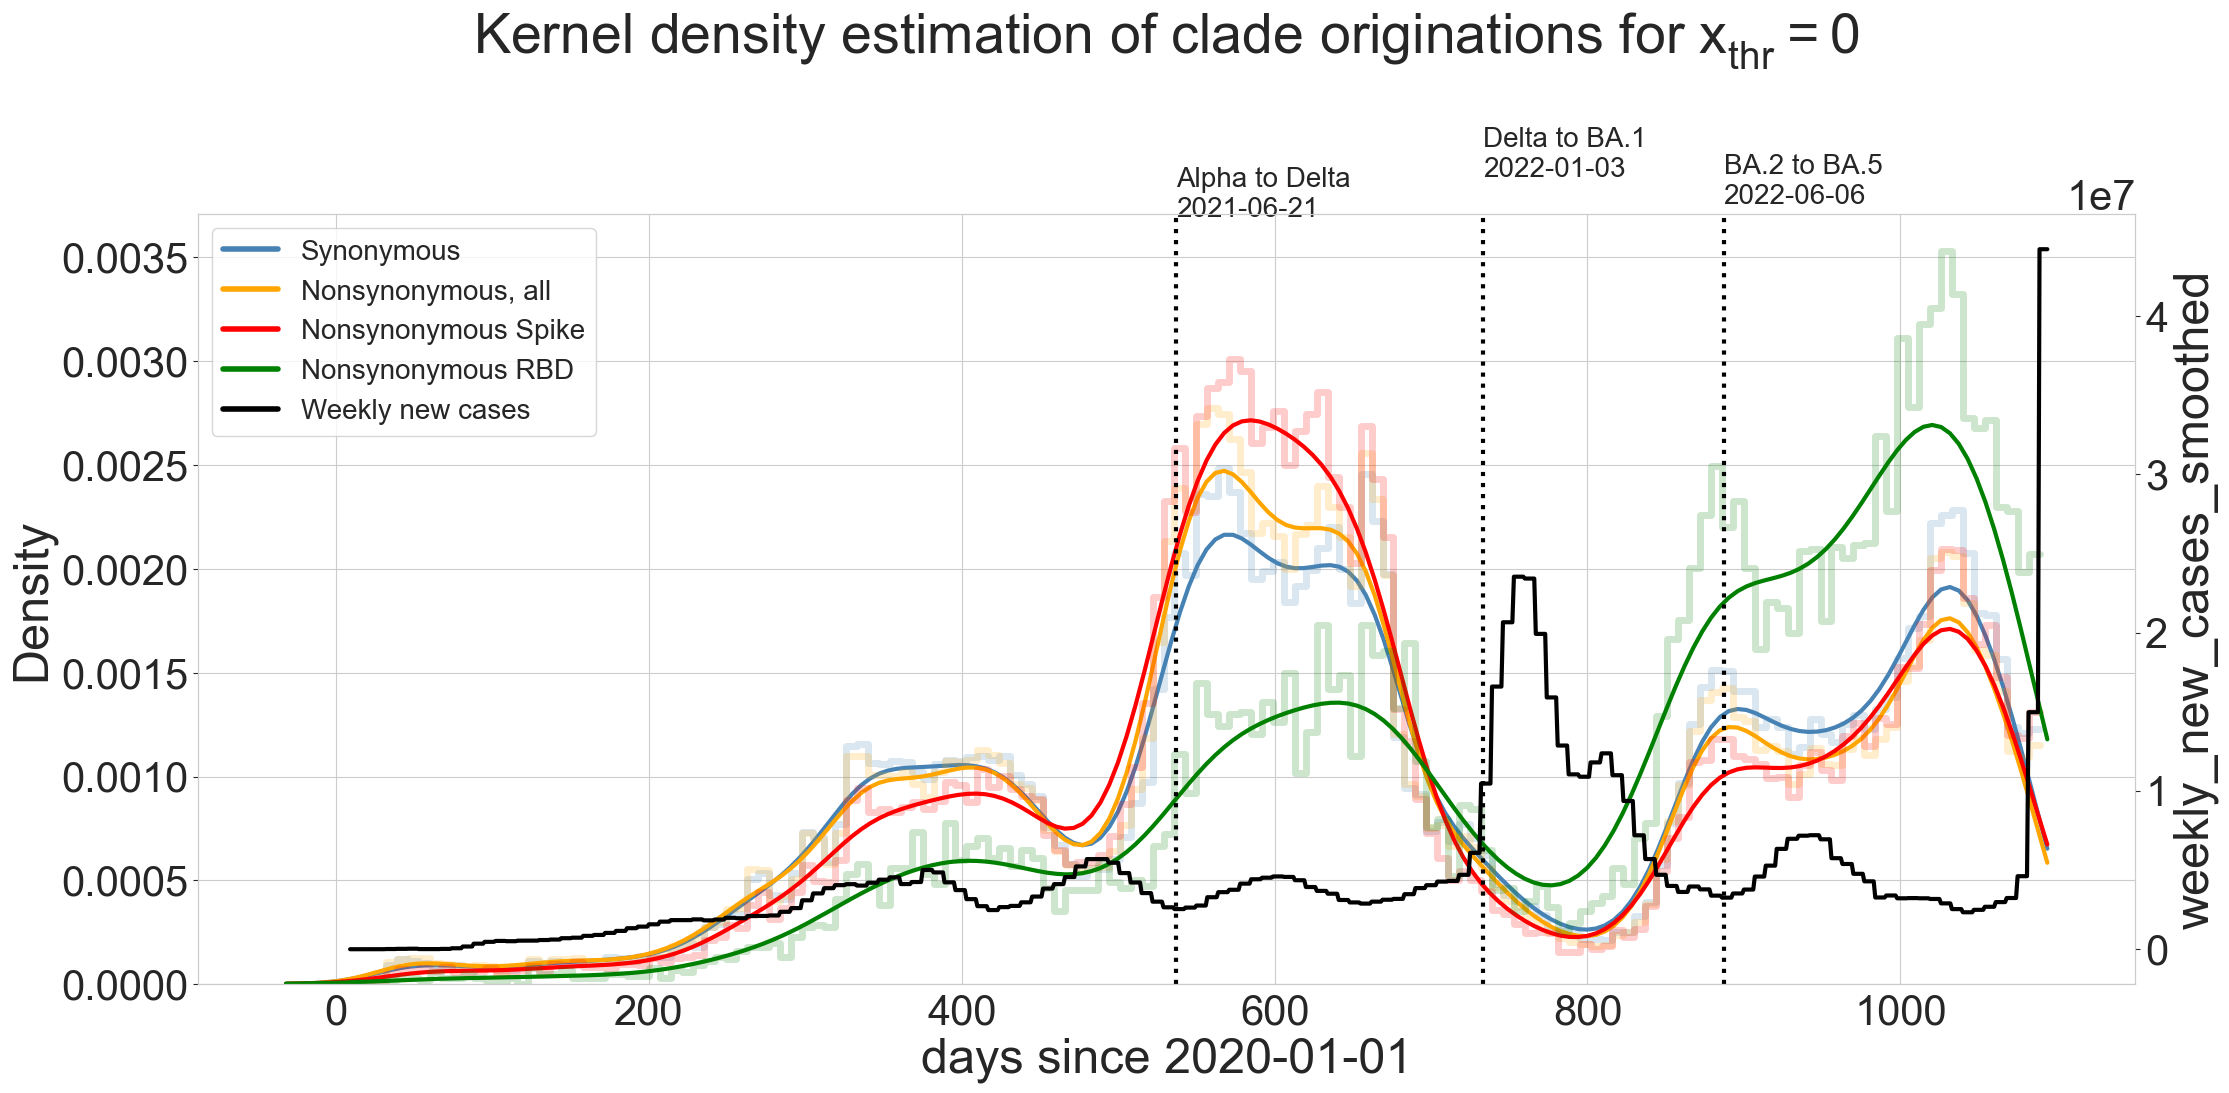

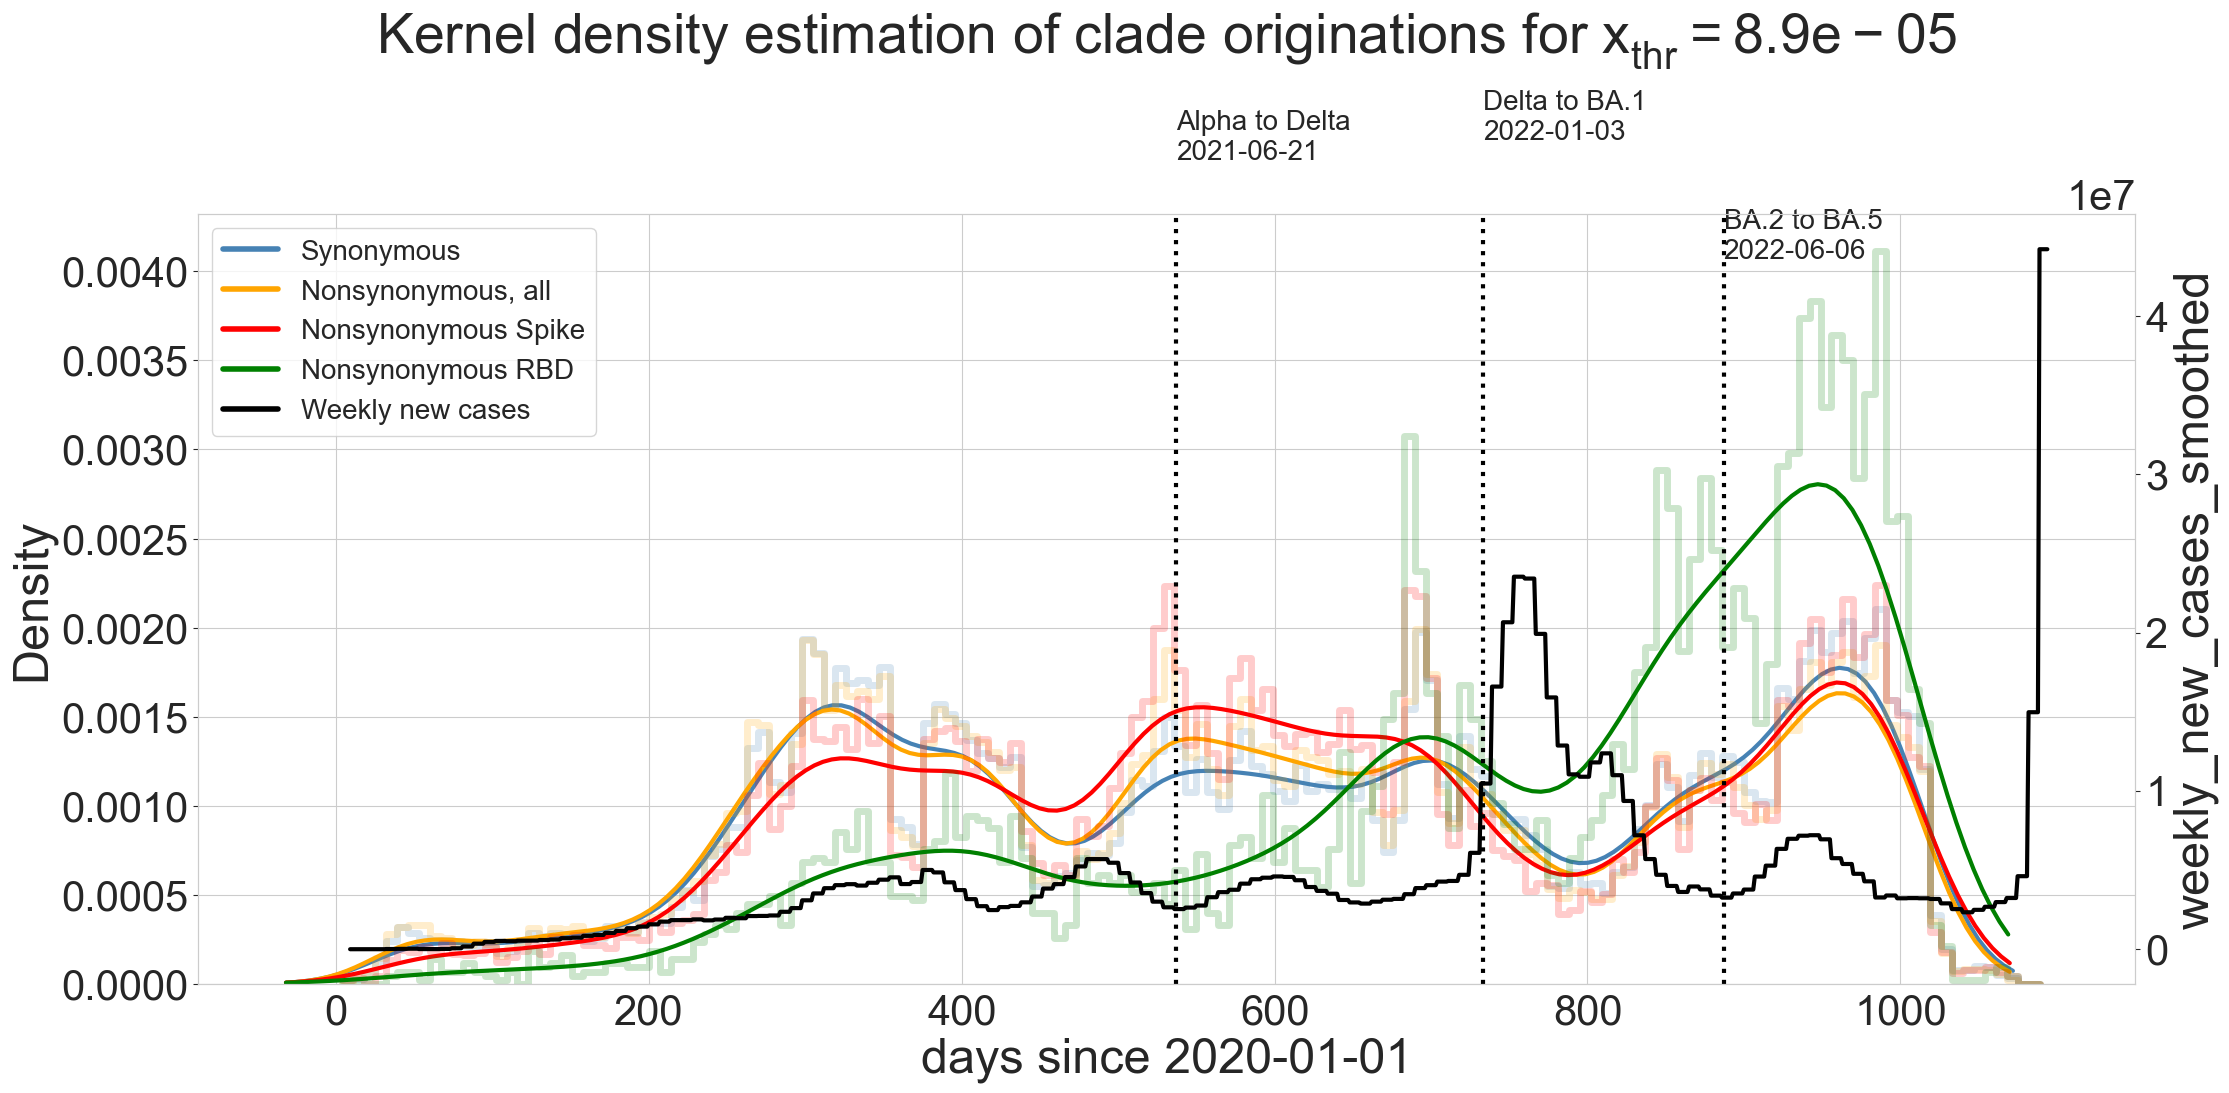

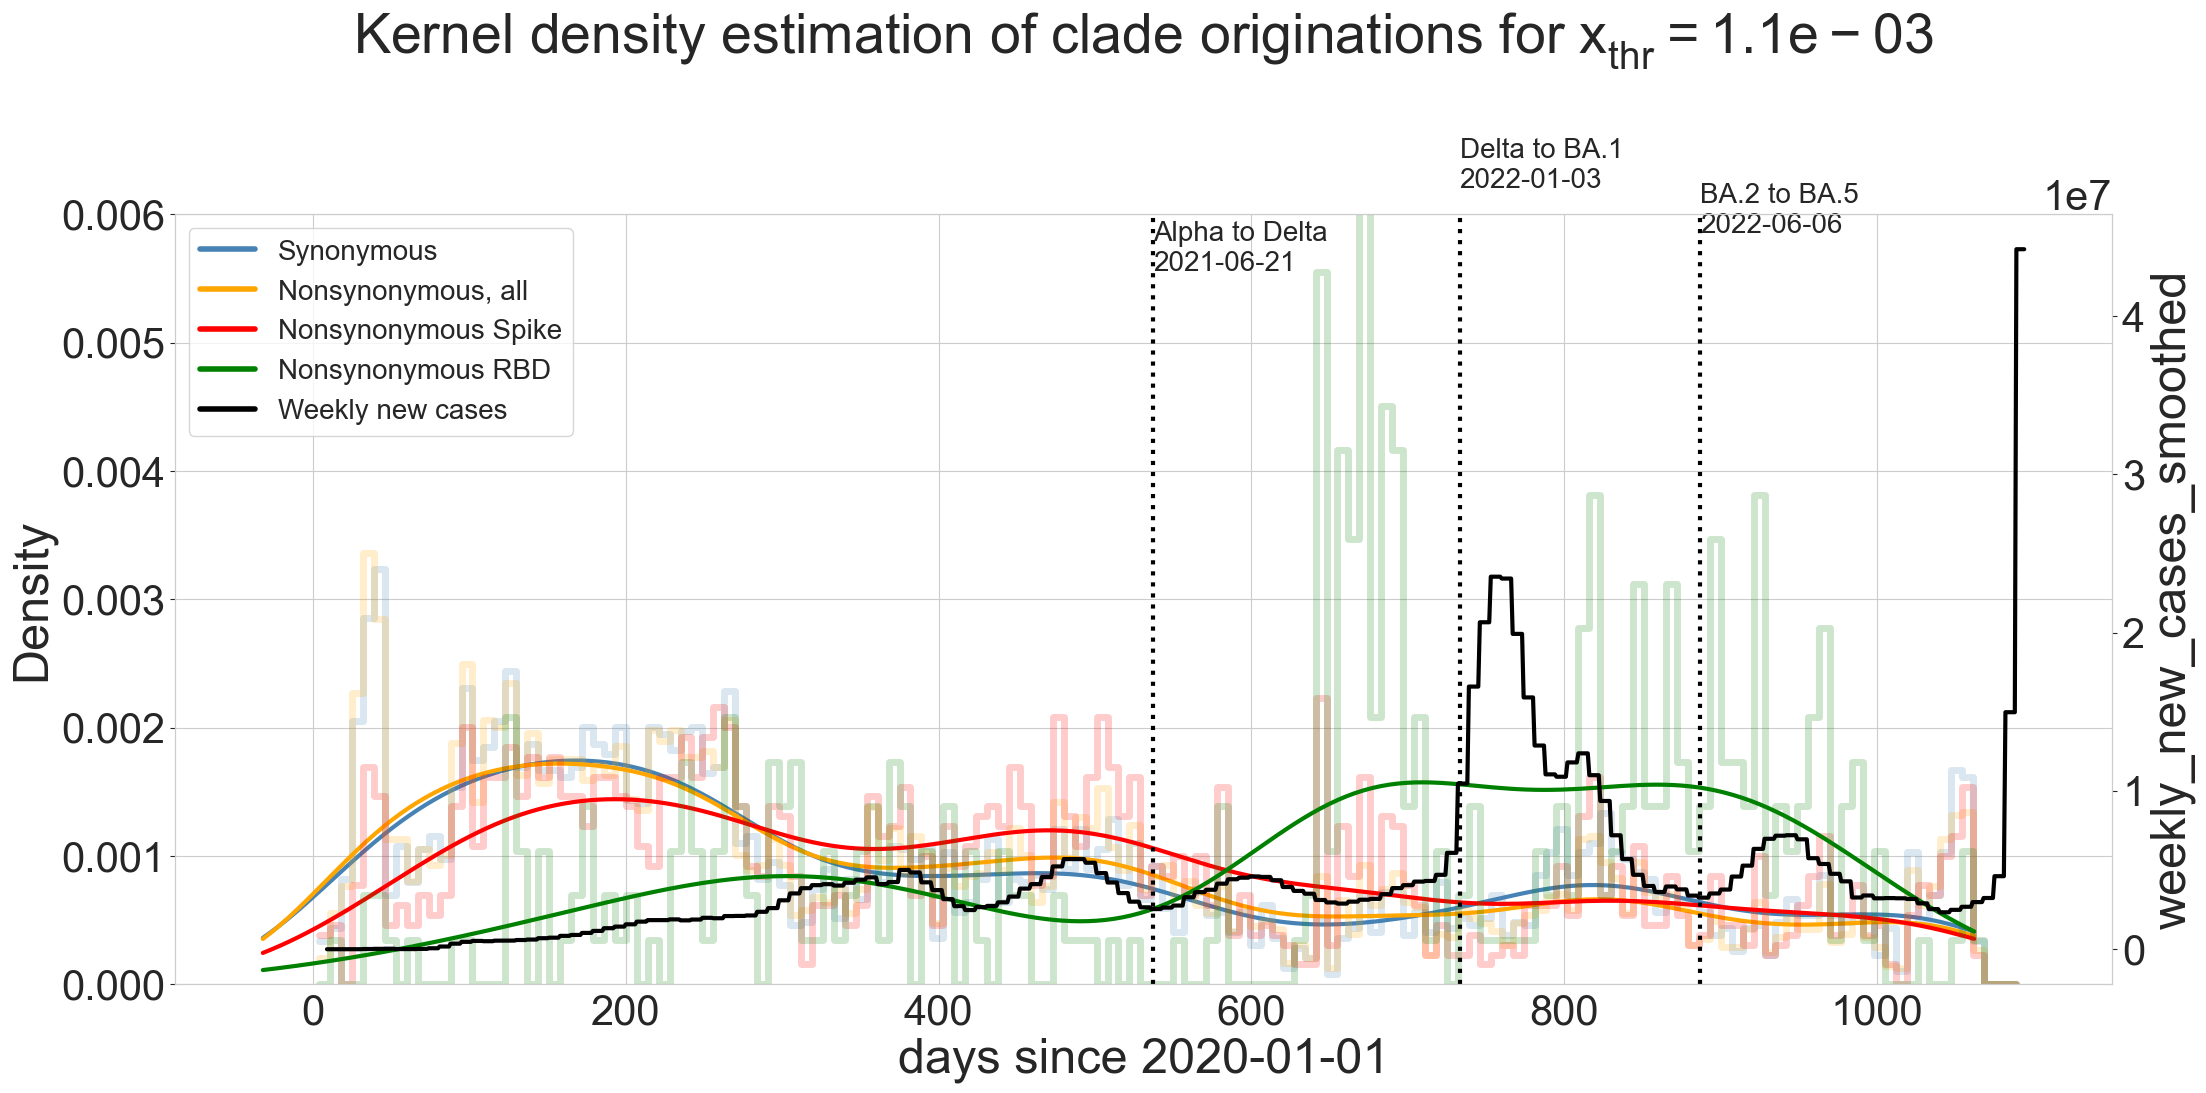

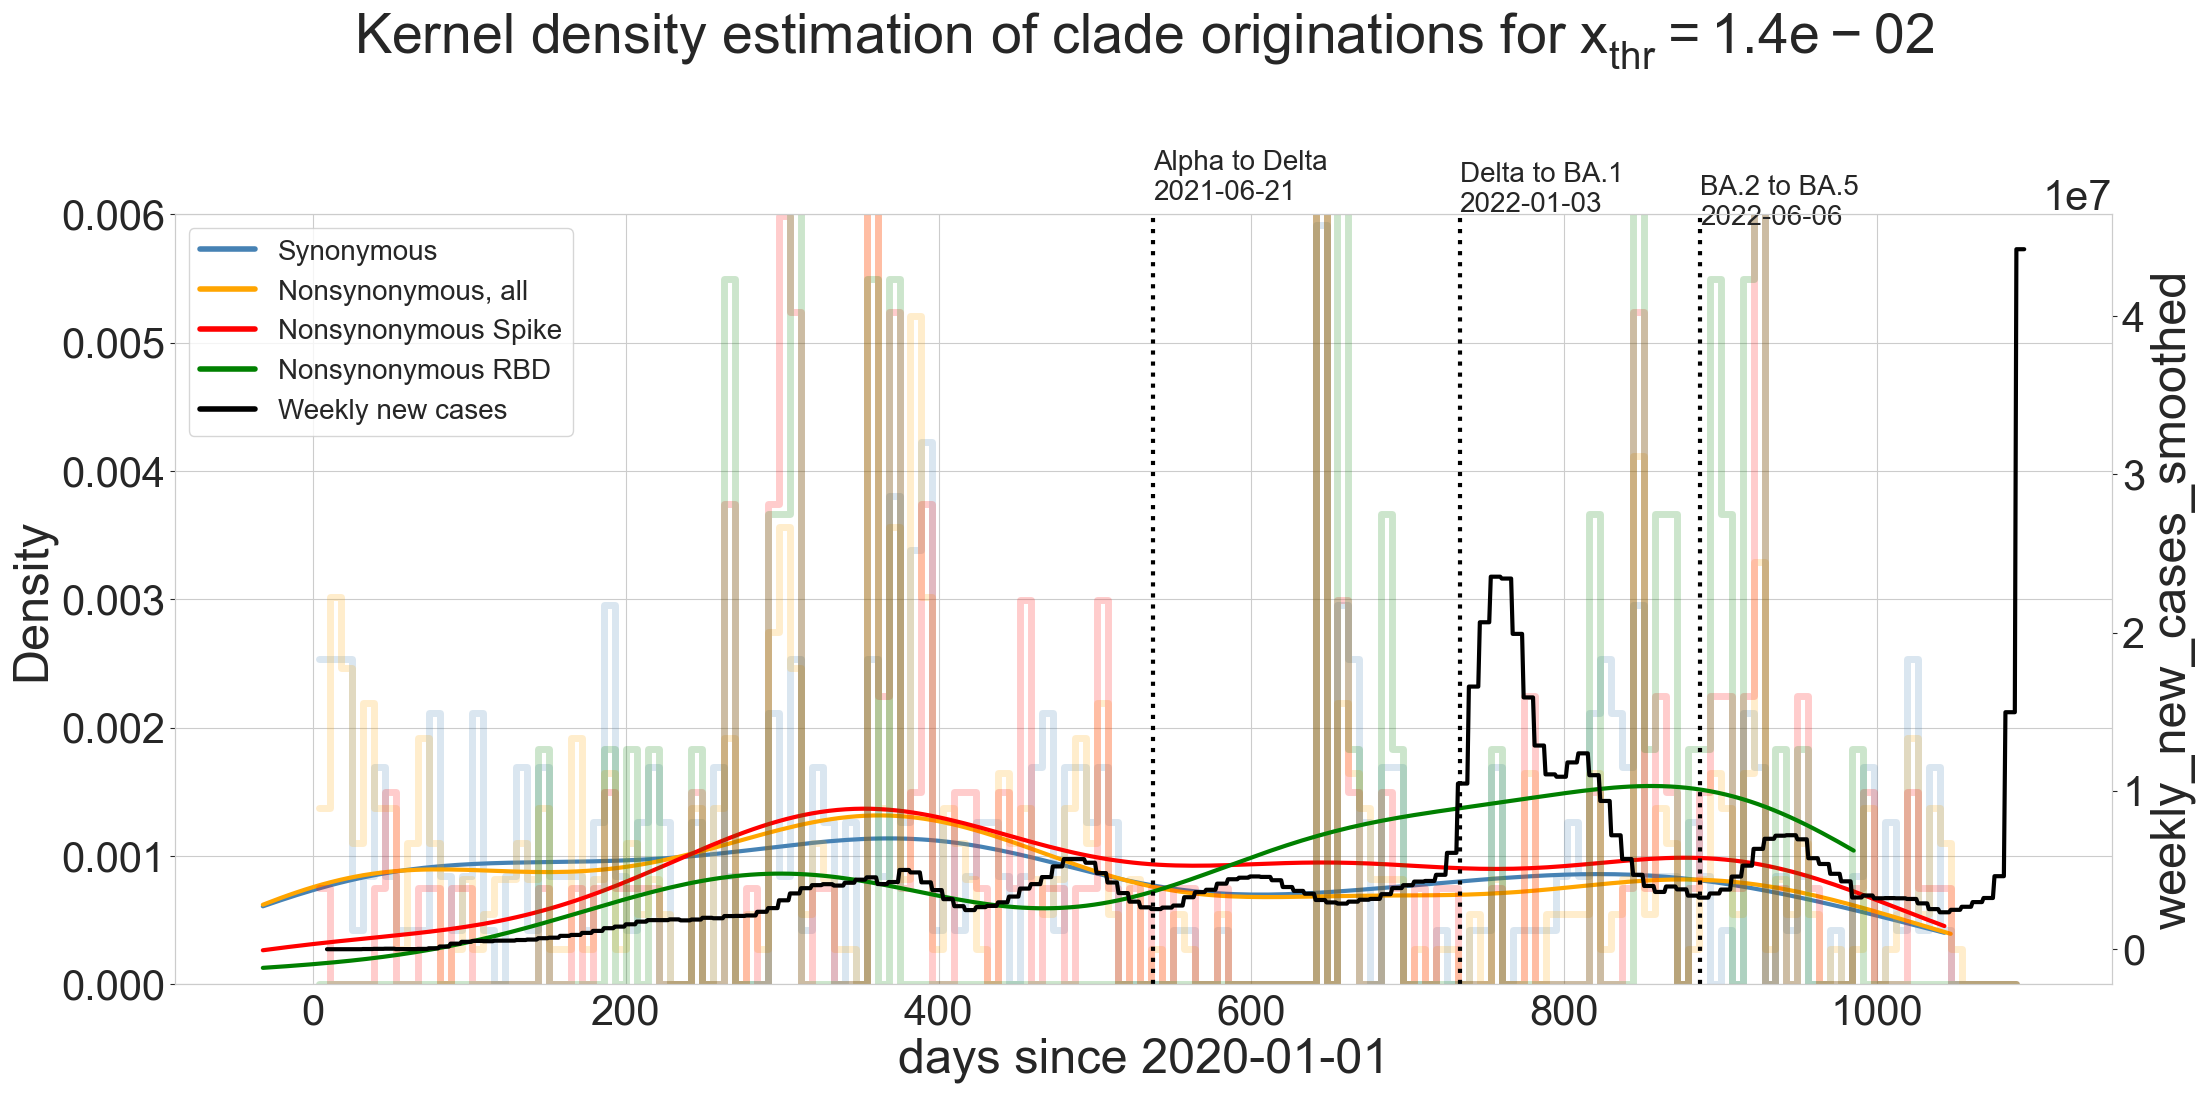

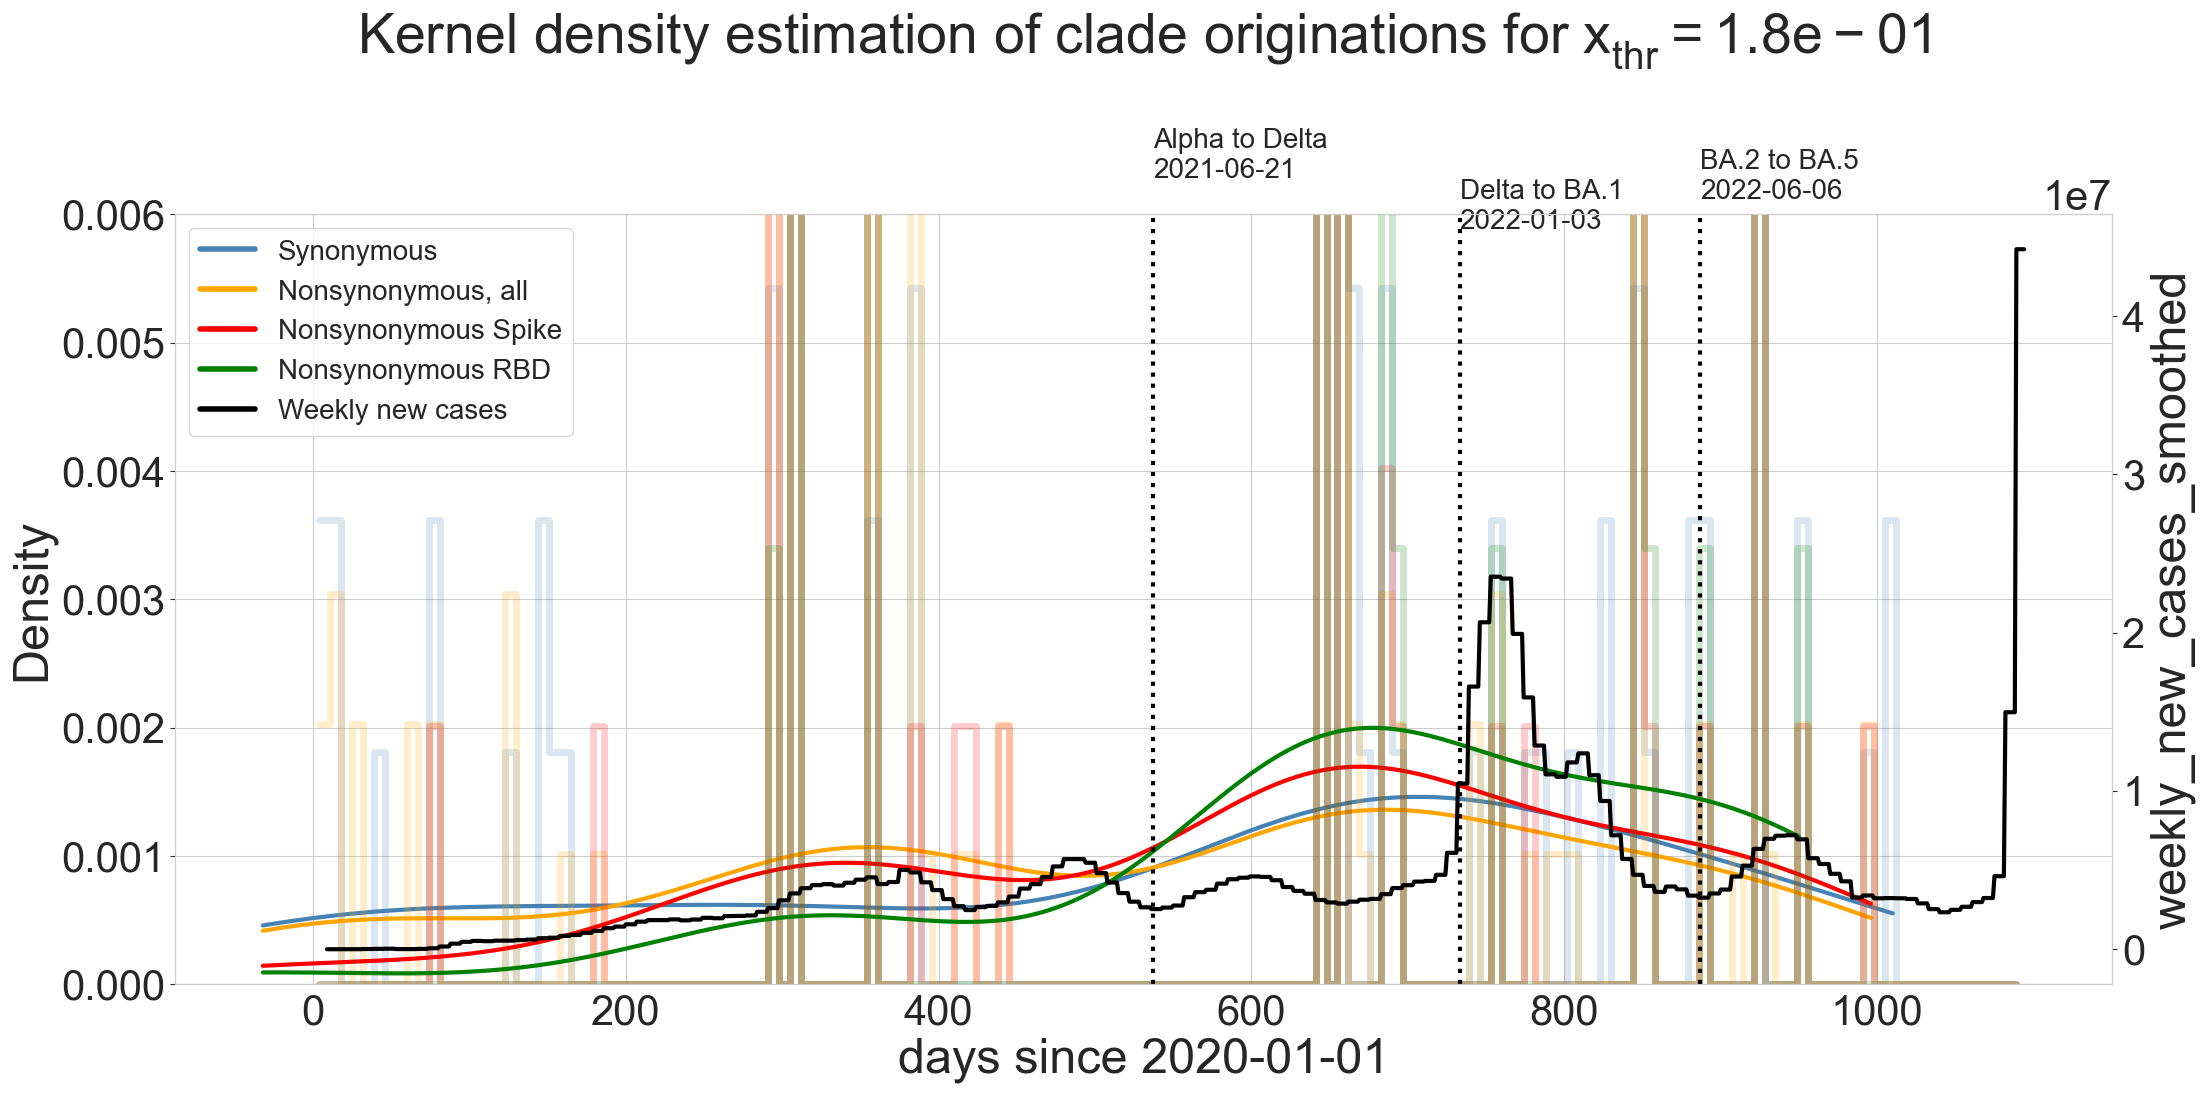

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(25,10))
sns.histplot(syn_clade_stats['day_diff'], alpha= .2,label='Syn', color='steelblue',ls='-',ax=ax,lw=5, kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
sns.histplot(nonsyn_all_clade_stats['day_diff'], alpha= .2,label='Nonsyn all',ax=ax,lw=5,ls='-', color='orange', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
sns.histplot(nonsyn_S_clade_stats['day_diff'], alpha= .2,label='Nonsyn S',ax=ax,lw=5,ls='-', color='red', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
sns.histplot(nonsyn_RBD_clade_stats['day_diff'], alpha= .2,label='Nonsyn RBD',ax=ax,lw=5,ls='-', color='green', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

ax.set_xlabel(f'days since {reference_date.date()}')
ax.set_title('Kernel density estimation of clade originations for $x_{thr}=0$', y= 1.2)
tax = ax.twinx()
tax.grid(False)
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
handles = [Line2D([0], [0], color='steelblue', lw=4, label='Synonymous'),
                Line2D([0], [0], color='orange', lw=4, label='Nonsynonymous, all'),
                Line2D([0], [0], color='red', lw=4, label='Nonsynonymous Spike'),
                Line2D([0], [0], color='green', lw=4, label='Nonsynonymous RBD'),
                Line2D([0], [0], color='black', lw=4, label='Weekly new cases')]
ax.legend(handles=handles,loc='upper left',fontsize=20)

for date,label in zip(crossover_dates,crossover_labels):
    ax.axvline((date-reference_date).days,linestyle=':',color='black')
    ax.text((date-reference_date).days,ax.get_ylim()[1]*(.99 + 0.05*np.random.randn()),label + '\n'+ f'{date.date()}',rotation=0,fontsize=20)

for xmin in xmin_vals[9::3]:
    
    fig,ax= plt.subplots(1,1,figsize=(25,10))
    sns.histplot(syn_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2,  color='steelblue',ax=ax,lw=5,ls='-',label='Syn', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

    sns.histplot(nonsyn_all_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2, color='orange',ax=ax,lw=5,ls='-',label='Nonsyn all', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

    sns.histplot(nonsyn_S_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2,  color='red',ax=ax,lw=5,ls='-',label='Nonsyn S', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2, color='green',ax=ax,lw=5,ls='-',label='Nonsyn RBD', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
    tax = ax.twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
    
    ax.set_xlabel(f'days since {reference_date.date()}')
    ax.set_title(f'Kernel density estimation of clade originations for $x_{{thr}}={xmin:.1e}$', y= 1.2)
    
    tax.grid(False)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0],np.min((ylim[1],6e-3)))
    for date,label in zip(crossover_dates,crossover_labels):
        ax.axvline((date-reference_date).days,linestyle=':',color='black')
        ax.text((date-reference_date).days,ax.get_ylim()[1]*(.99 + 0.05*np.random.randn()),label + '\n'+ f'{date.date()}',rotation=0,fontsize=20)
    handles = [Line2D([0], [0], color='steelblue', lw=4, label='Synonymous'),
                Line2D([0], [0], color='orange', lw=4, label='Nonsynonymous, all'),
                Line2D([0], [0], color='red', lw=4, label='Nonsynonymous Spike'),
                Line2D([0], [0], color='green', lw=4, label='Nonsynonymous RBD'),
                Line2D([0], [0], color='black', lw=4, label='Weekly new cases')]
    ax.legend(handles=handles,loc='upper left',fontsize=20)

(0.0, 0.006)

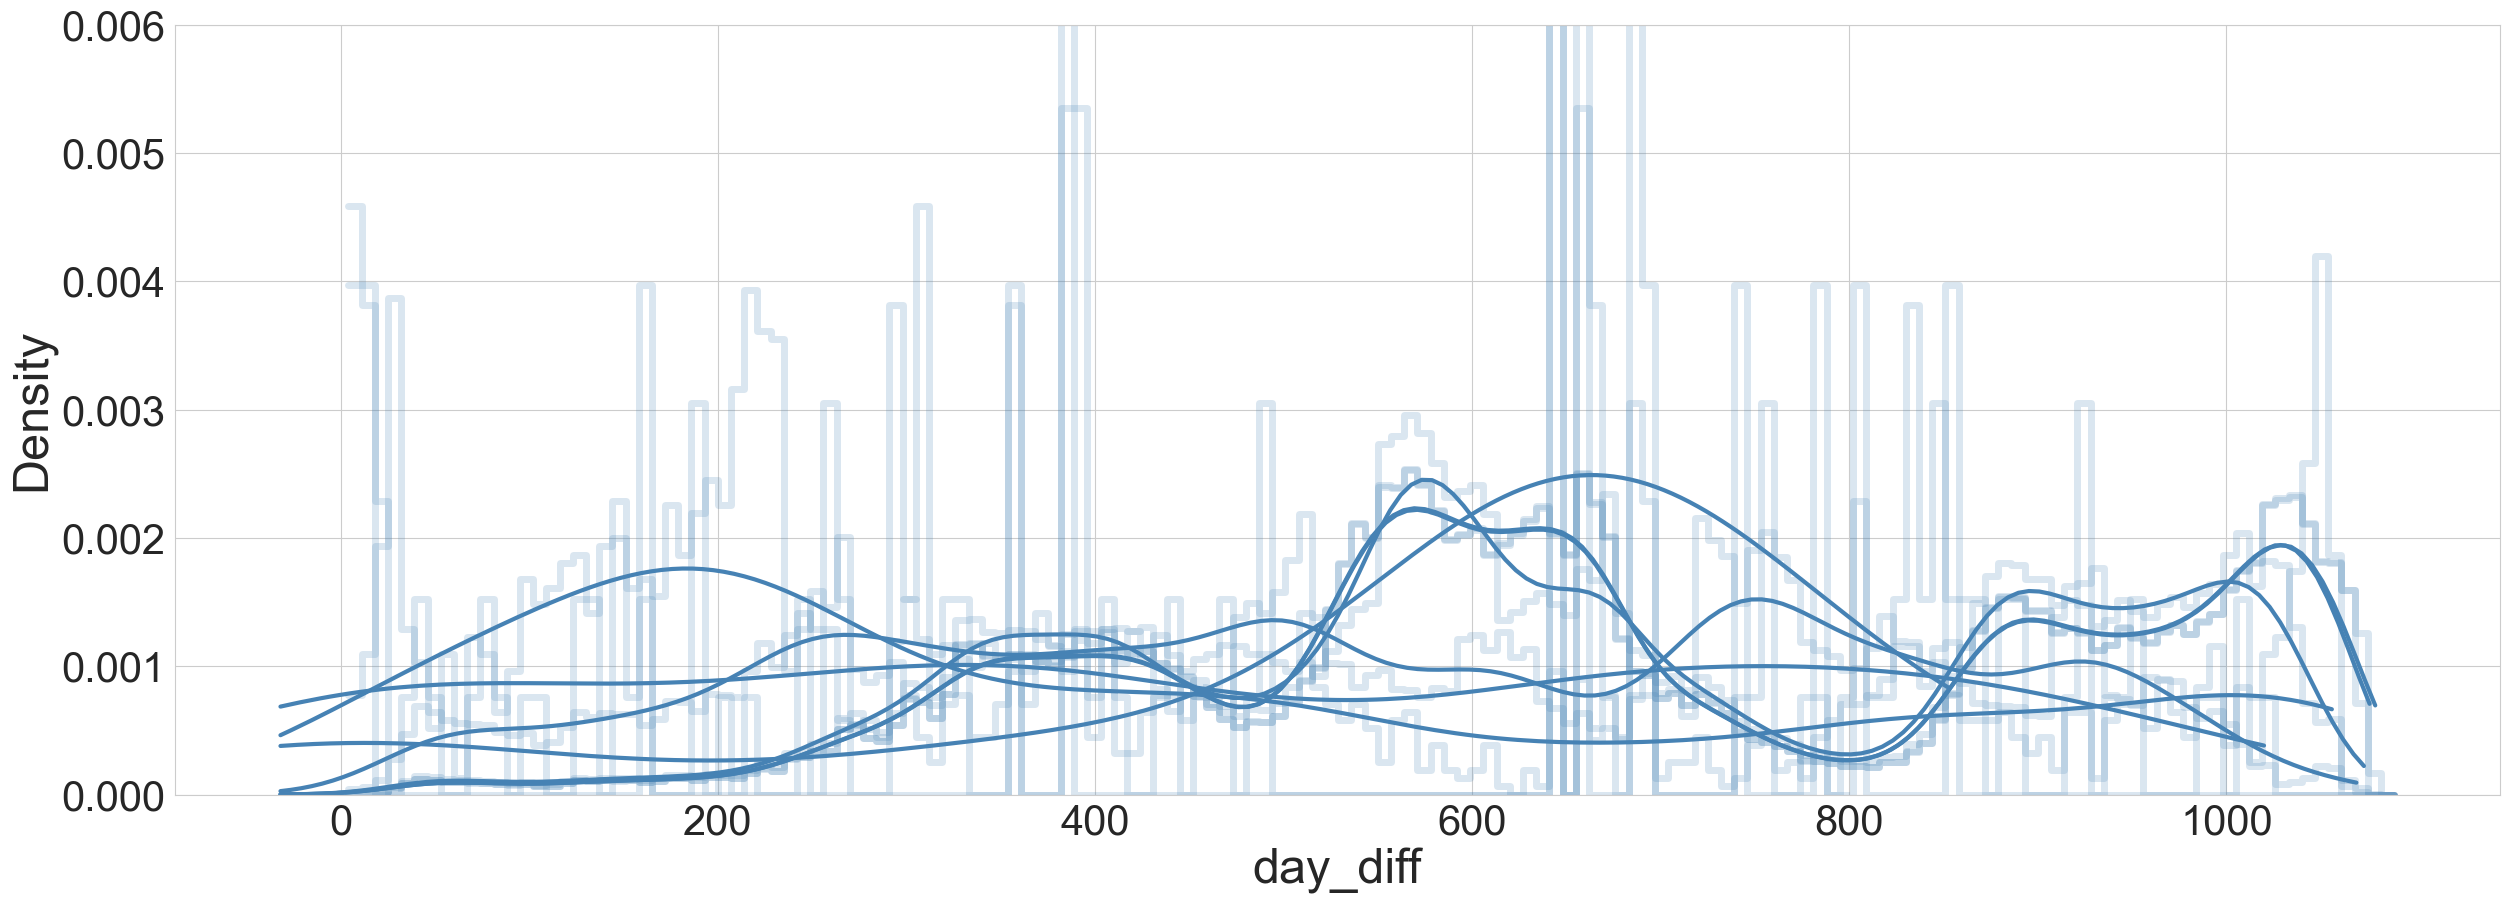

In [ ]:
fig,ax = plt.subplots(1,figsize = (30,10))
for xmin in xmin_vals[1::3]:
    sns.histplot(syn_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2,  color='steelblue',ax=ax,lw=5,ls='-',label='Syn', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

ylim = ax.get_ylim()
ax.set_ylim(ylim[0],np.min((ylim[1],6e-3)))

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(25,10))
sns.histplot(syn_clade_stats['day_diff'], alpha= .2,label='Syn', color='steelblue',ls=':',ax=ax,lw=5, kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
sns.histplot(nonsyn_all_clade_stats['day_diff'], alpha= .2,label='Nonsyn all',ax=ax,lw=5,ls='--', color='orange', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
sns.histplot(nonsyn_S_clade_stats['day_diff'], alpha= .2,label='Nonsyn S',ax=ax,lw=5,ls='-', color='red', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
sns.histplot(nonsyn_RBD_clade_stats['day_diff'], alpha= .2,label='Nonsyn RBD',ax=ax,lw=5,ls='-.', color='green', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

ax.set_xlabel(f'days since {reference_date.date()}')
ax.set_title('Kernel density estimation of clade originations for $x_{thr}=0$', y= 1.2)
tax = ax.twinx()
tax.grid(False)
sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
ax.legend(loc='best')

for date,label in zip(crossover_dates,crossover_labels):
    ax.axvline((date-reference_date).days,linestyle=':',color='black')
    ax.text((date-reference_date).days,ax.get_ylim()[1]*(.99 + 0.05*np.random.randn()),label + '\n'+ f'{date.date()}',rotation=0,fontsize=20)

for xmin in xmin_vals[9::3]:
    
    fig,ax= plt.subplots(1,1,figsize=(25,10))
    sns.histplot(syn_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2,  color='steelblue',ax=ax,lw=5,ls=':',label='Syn', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

    sns.histplot(nonsyn_all_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2, color='orange',ax=ax,lw=5,ls='--',label='Nonsyn all', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

    sns.histplot(nonsyn_S_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2,  color='red',ax=ax,lw=5,ls='-',label='Nonsyn S', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')

    sns.histplot(nonsyn_RBD_clade_stats.query(f'Max_Freq > {xmin}')['day_diff'], alpha= .2, color='green',ax=ax,lw=5,ls='-.',label='Nonsyn RBD', kde= True, element = 'step',fill=False,bins = day_diff_weekly,stat = 'density')
    tax = ax.twinx()
    sns.lineplot(data = covid_data_World, x = 'day_diff', y = 'weekly_new_cases_smoothed', ax = tax ,color='black')
    ax.legend(loc='best')
    ax.set_xlabel(f'days since {reference_date.date()}')
    ax.set_title(f'Kernel density estimation of clade originations for $x_{{thr}}={xmin:.1e}$', y= 1.2)
    for date,label in zip(crossover_dates,crossover_labels):
        ax.axvline((date-reference_date).days,linestyle=':',color='black')
        ax.text((date-reference_date).days,ax.get_ylim()[1]*(.99 + 0.05*np.random.randn()),label + '\n'+ f'{date.date()}',rotation=0,fontsize=20)
    tax.grid(False)

In [ ]:
immune_classes = pd.read_csv(os.getcwd()+'/data/immune_classes.txt',sep='\t')

In [ ]:
h,b = np.histogram(syn_clade_stats['day_diff'], bins = np.sort(covid_data_World['day_diff'].unique()),density=True)

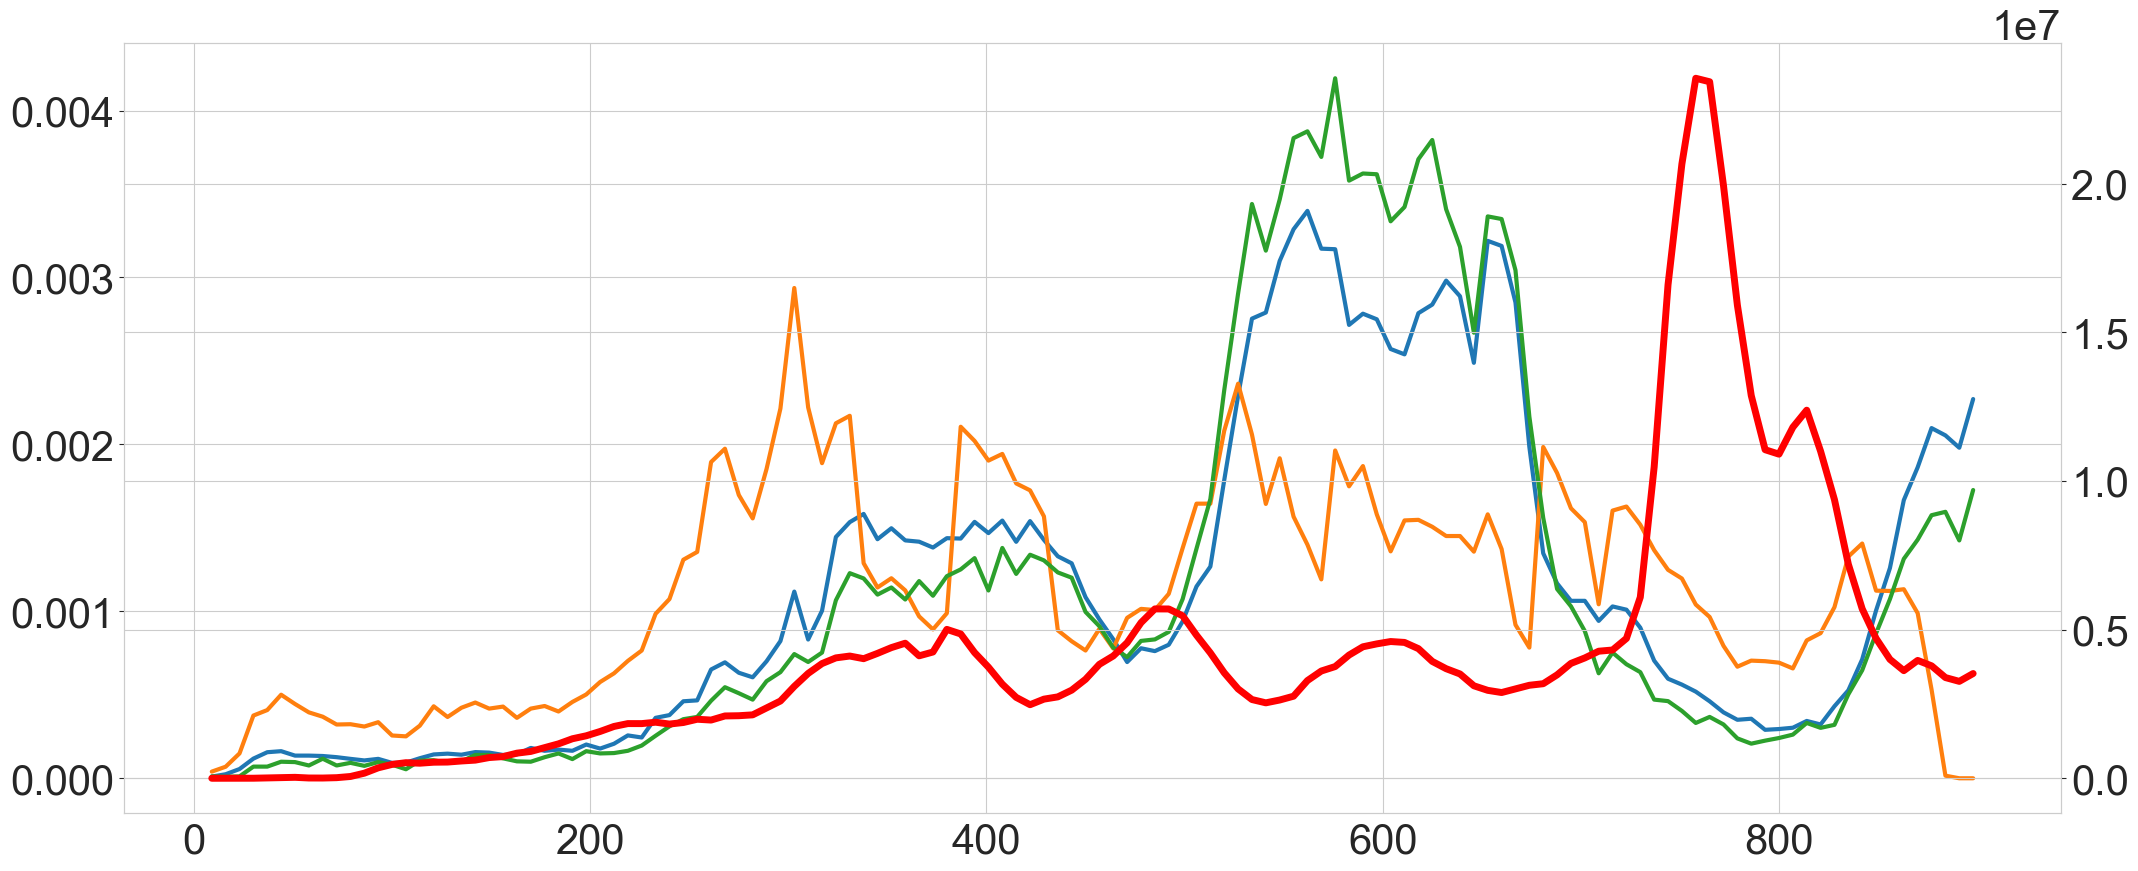

In [ ]:
fig,ax= plt.subplots(1,figsize=(25,10))
day_diff = covid_data_World['day_diff'][~np.isnan(covid_data_World['weekly_new_cases_smoothed'])][::7].values
cases = covid_data_World['weekly_new_cases_smoothed'][~np.isnan(covid_data_World['weekly_new_cases_smoothed'])][::7].values
h_syn_0,b_syn_0 = np.histogram(syn_clade_stats['day_diff'], bins = day_diff,density=True)
h_syn_1e_m4,b_syn_1e_m4 = np.histogram(nonsyn_all_clade_stats.query('Max_Freq > 1e-4')['day_diff'], bins = day_diff,density=True)

h_nnonsyn_spike_0, b_nonsyn_spike_0 = np.histogram(nonsyn_S_clade_stats['day_diff'], bins = day_diff,density=True)

day_diff = day_diff[:-1]
cases = cases[:-1]
plt.plot(b_syn_0[:-1],h_syn_0)


plt.plot(b_syn_1e_m4[:-1],h_syn_1e_m4)

plt.plot(day_diff,h_nnonsyn_spike_0)

tax = ax.twinx()
tax.plot(day_diff,cases,color='red',lw=5)

In [ ]:
fft_syn_0 = np.fft.fft(h_syn_0)
fft_cases = np.fft.fft(cases, n = len(h_syn_0))
ratio_syn_0 = fft_cases/fft_syn_0
ratio_ifft_syn_0 = np.fft.ifft(ratio_syn_0,n = len(h_syn_0))

ratio_ifft_syn_0 = np.fft.fftshift(ratio_ifft_syn_0)

fft_syn_1e_m4 = np.fft.fft(h_syn_1e_m4)
ratio_syn_1e_m4 = fft_cases/fft_syn_1e_m4

ratio_ifft_syn_1e_m4 = np.fft.ifft(ratio_syn_1e_m4,n = len(h_syn_1e_m4))


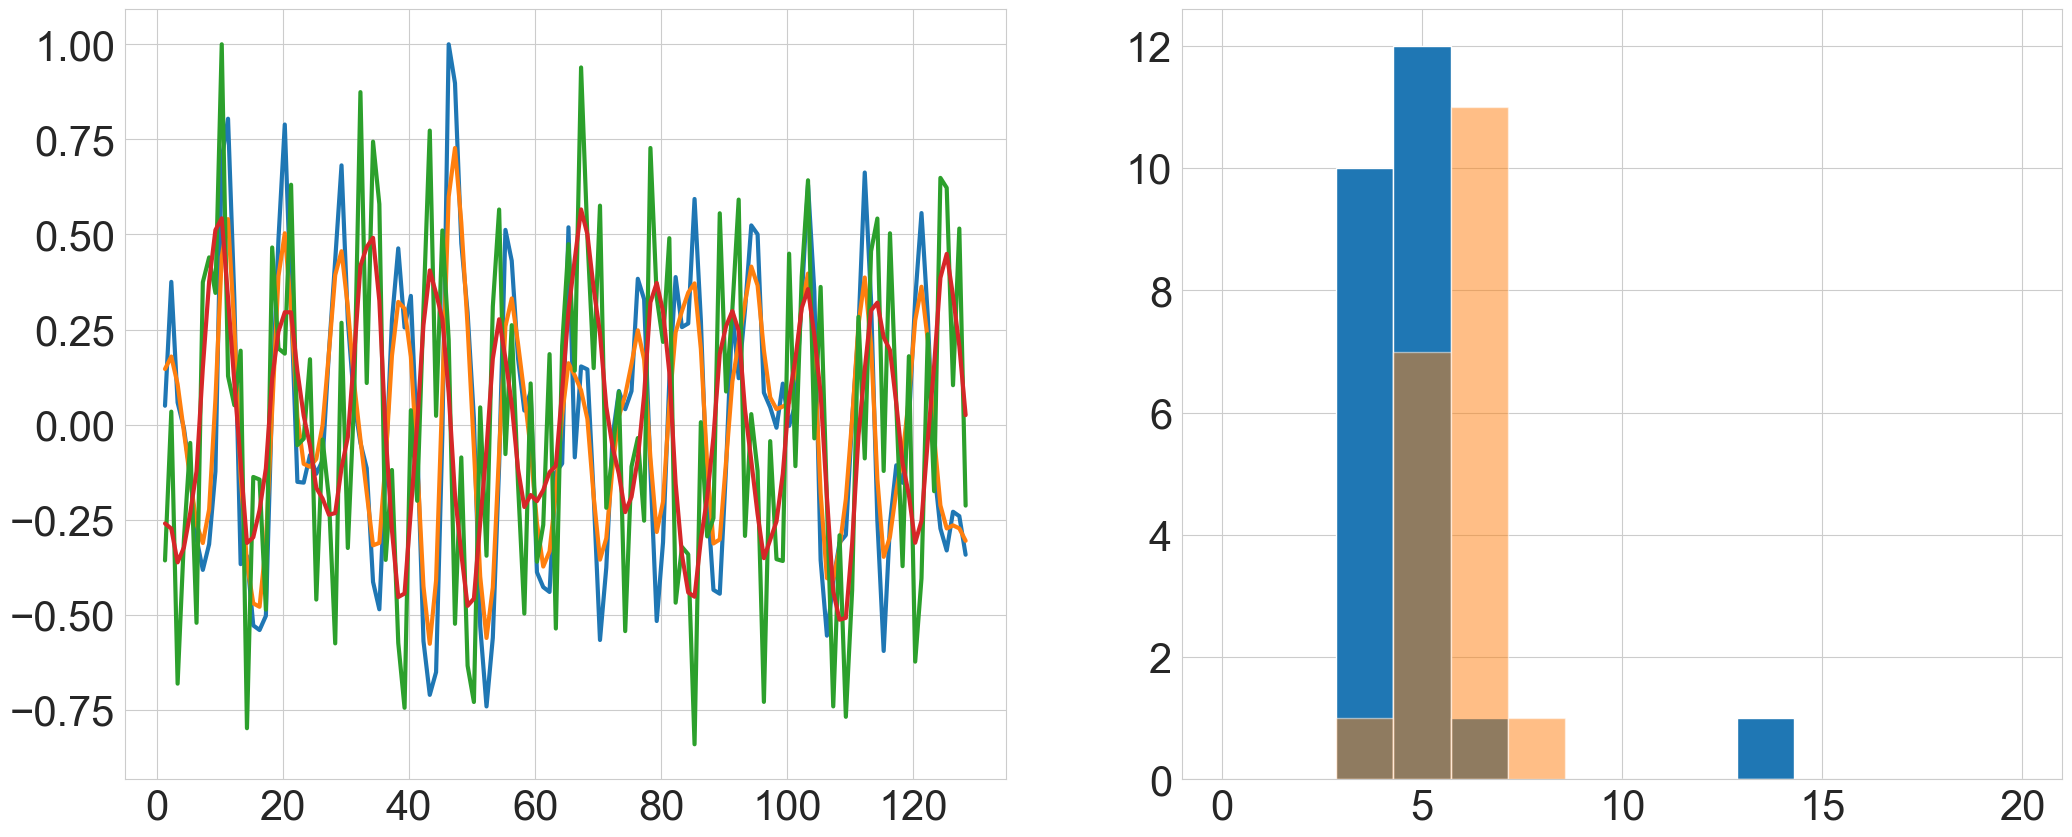

In [ ]:
# day_diff = day_diff.values
fig,ax= plt.subplots(1,2,figsize=(25,10))
norm_ratio_syn_0 = ratio_ifft_syn_0/np.max(ratio_ifft_syn_0)
smooth_norm_ratio_syn_0 = gaussian_filter1d(norm_ratio_syn_0, sigma=1)
c_syn, =ax[0].plot(day_diff/7,norm_ratio_syn_0,alpha=.5)
ax[0].plot(day_diff/7,smooth_norm_ratio_syn_0,color= c_syn.get_color())

norm_ratio_syn_1e_m4 = ratio_ifft_syn_1e_m4/np.max(ratio_ifft_syn_1e_m4)
smooth_norm_ratio_syn_1e_m4 = gaussian_filter1d(norm_ratio_syn_1e_m4, sigma=1)
ax[0].plot(day_diff/7,norm_ratio_syn_1e_m4)
ax[0].plot(day_diff/7,smooth_norm_ratio_syn_1e_m4)

#get zeros of the smoothed ratio
zero_crossings_syn_0 = np.where(np.diff(np.sign(smooth_norm_ratio_syn_0)))[0]
zero_crossings_syn_1e_m4 = np.where(np.diff(np.sign(smooth_norm_ratio_syn_1e_m4)))[0]
# day_diff[zero_crossings_syn_0[0]]/7
bins = np.linspace(0,20,15)
ax[1].hist(np.diff(day_diff[zero_crossings_syn_0]/7),bins = bins);
ax[1].hist(np.diff(day_diff[zero_crossings_syn_1e_m4]/7),bins = bins,cumulative=False,alpha=.5);

# for d in day_diff[zero_crossings_syn_0]/7:
#     ax[0].axvline(d,color='red')
    # ax[1].axvline(d,color='red')

(0.0, 898.0)

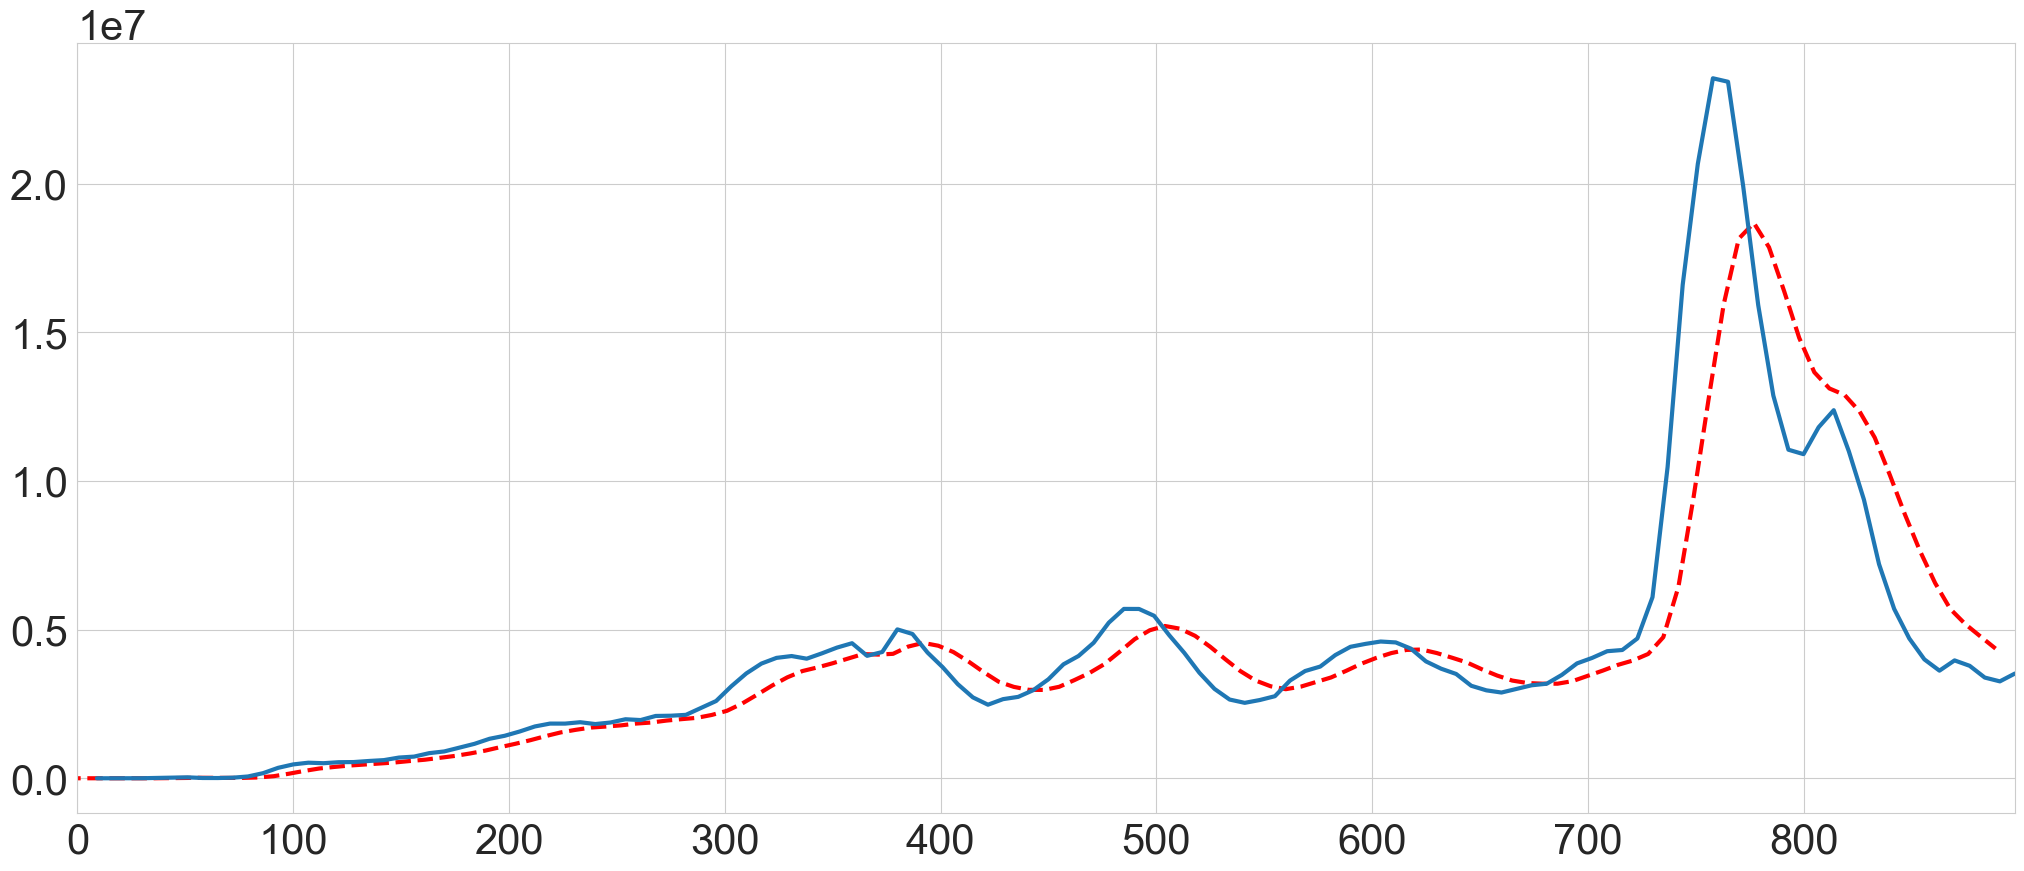

In [ ]:
#convolution of cases with an exponential kernel of rate 4
kernel = np.exp(-np.abs(day_diff)/20)
cases_conv = np.convolve(cases,kernel)/np.sum(kernel)
fig,ax= plt.subplots(1,figsize=(25,10))
day_diff_full = np.arange(-len(kernel)+1,len(kernel))*7
ax.plot(day_diff_full,np.roll(cases_conv,len(kernel)+1),ls='--',color='red')
ax.plot(day_diff,cases)
ax.set_xlim(0,day_diff[-1])

In [ ]:
cases_conv

array([43962.28361842])